# Initial Notebook

## Setup

In [1]:
# Note - uses early prototype initial_utilities, stored locally
# Later developed into hicdash and packaged
from utilities_lymphoma import *

from dataclasses import replace
from sklearn.decomposition import PCA
import copy
from collections import defaultdict
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = "Arial"

In [2]:
# Max value for H3K27ac bigwig tracks
GLOBAL_BW_MAX = 32

# Max value for observed/expected matrices
GLOBAL_OE_MAX = 2000

# Normalization for all Hi-C visualization (if unavailable, default to VC_SQRT normalization)
HIC_NORM        = "SCALE"
HIC_NORM_BACKUP = "VC_SQRT"
MCOOL_BALANCE   = "weight"

# Plotting colours
BIGWIG_COLOUR = "royalblue"
CTCF_COLOUR = "seagreen"
LOOP_COLOUR = "royalblue"
CROSS_COLOUR = "royalblue"

# Plotting constants
group_order_colors = [
   ('PCN', "rebeccapurple"),
   ('CNS DLBCL', "royalblue"),
   ( "DLBCL (Richter transformation)", "dodgerblue"),
   ( 'DLBCL', "deepskyblue"),
   ( 'PMLBCL', "darkturquoise"),
   ( 'B-cell lymphoma NOS', "paleturquoise"),
   ( 'Burkitt lymphoma', "lightgreen"),
   ( 'Classic Hodgkins lymphoma', "cadetblue"),
   ( 'MCL', "yellowgreen"),
   ( 'B-ALL', "gold"),
   ( 'ALCL', "salmon"),
   ( 'T-ALL', "tomato"),
   ( 'PC', "mediumpurple"),
   ( 'MBC', "mediumslateblue"),
   ( 'GCBC', "steelblue"),
   ( 'NBC', "lightsteelblue"),
   ( 'HMEC', "gray"),
   ( 'HUVEC', "gray"),
   ( 'IMR90', "gray"),
   ( 'NHEK', "gray"),
   ( 'K562', "pink"),
   ( 'KBM7', "pink"),
   ( 'GM12878', "cornflowerblue"),
]

prep_order = [
    "Arima_FFPE",
    "In-situ_Fresh-Frozen",
    "In-situ_Culture",
]

group_colors = { k: v for k, v in group_order_colors }
group_order = [ g[0] for g in group_order_colors ]
prep_order_dict = { s: i for i, s in enumerate(prep_order) }
group_order_dict = {s: i for i, s in enumerate(group_order) }

# Compartments (excluding blacklist)
COMPARTMENT_REGIONS_100kb = pd.read_csv("../annotations/compartment_regions_100kb_blacklisted.csv", sep=",", header=0)
compartment_subset_indices = np.array((COMPARTMENT_REGIONS_100kb["blacklisted"] == False).to_list())

# Utility type for sample
@dataclass 
class Sample:
    meta: object
    profile: DataProfile
    extra_comp_25kb: str
    uvp: float

# Utility function for saving plots
def figure_path(plot_name):
    return f"../figures/notebook_figures/master/{plot_name}"

In [3]:
BW_NAIVE = ("NBC", "../annotations/H3K27ac/01_naive_B_cell.H3K27ac.bw")
BW_PLASMA = ("PC", "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw")
BW_GERMINAL = ("GCBC", "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
BW_SUDHL5_LARGECELL = ("SUDHL5", "../annotations/H3K27ac/04_SUDHL5_H3K27ac.bw")
BW_KARPAS_DLBCL = ("Karpas422", "../annotations/H3K27ac/05_Karpas422_H3K27ac.bw")
BW_HT_BCL = ("HT", "../annotations/H3K27ac/06_HT_H3K27ac.bw")
BW_MYELOMA_ANBL6 = ("ANBL6", "../annotations/H3K27ac/07_ANBL6_H3K27ac.bw")
BW_PTCL_T8ML = ("T8ML1", "../annotations/H3K27ac/collaborators_Wilcox_lab_T8ML1_H3K27Ac_rep1.1m.bw")
BW_TALL = ("T-ALL°", "../annotations/H3K27ac/10_data-public_databases_blueprint_hg38bw_Tcell_Acute_Lymphocytic_Leukemia_S01S3FH1.ERX1347915.H3K27ac.bwa.GRCh38.bw")

BW_DICT = {
    "DLBCL": BW_GERMINAL,
    "CNS DLBCL": BW_GERMINAL,
    "DLBCL (Richter transformation)": BW_GERMINAL,
    "Burkitt lymphoma": BW_GERMINAL,
    "PCN": BW_PLASMA,
    "B-cell lymphoma NOS": BW_GERMINAL,
    "PMLBCL": BW_GERMINAL,
    "Follicular lymphoma": BW_GERMINAL,
    "MCL": BW_GERMINAL,
    "Classic Hodgkins lymphoma": BW_GERMINAL,
    "T-ALL": BW_TALL,
    "B-ALL": BW_NAIVE,
    "ALCL": BW_SUDHL5_LARGECELL,
}

ctcf_bed = pd.read_csv("../annotations/CTCF/CTCF_motifs_STORM_hg38.bed", names=["chr", "start", "end", "direction"], sep=r"\s+")


In [ ]:
samplesheet = pd.read_csv("../info/lymphoma/lymphoma_meta.csv")
assert set(group_order) == set(samplesheet.group.to_list())
assert set(prep_order) == set(samplesheet.prep.to_list())

samples           = []
samples_pub_rao   = []
samples_pub_merge = []
samples_pub_rep   = []

headers = " | ".join([f"{s[:5]:5}" for s in DataProfile.__annotations__.keys()])
for i, row in samplesheet.iterrows():
    hic_file_id = row.id_file
    profile = make_profile(hic_file_id, comp_res=100000)
    extra_comp_25kb = exists_or_none(f"../data/compartments/25000/{hic_file_id}.25000.bedgraph")
    if "merge" in hic_file_id:
        samples_pub_merge.append(Sample(row, profile, extra_comp_25kb, get_uvp(hic_file_id)))
    elif "GSE63525_" in hic_file_id:
        samples_pub_rao.append(Sample(row, profile, extra_comp_25kb, get_uvp(hic_file_id)))
    else:
        samples.append(Sample(row, profile, extra_comp_25kb, get_uvp(hic_file_id)))
    def x(path: str | None): return "X" if path is not None else " "
    checklist = " | ".join([f"{x(s):>5}" for s in profile.__dict__.values()])

for sample in samples_pub_merge:
    for rep in [1, 2, 3]:
        new_id_file = sample.meta.id_file.replace("_merge", f"_rep{rep}")
        new_id_paper = sample.meta.id_paper.replace("_merge", f"_rep{rep}")
        new_meta = sample.meta.copy()
        new_meta.id_file = new_id_file
        new_meta.id_paper = new_id_paper
        new_uvp = get_uvp(new_id_file)
        new_sample = Sample(
            new_meta,
            make_profile(new_id_file),
            None,
            new_uvp,
        )
        samples_pub_rep.append(new_sample)

def sort_samples(samples): return sorted(samples,  key=lambda x: (prep_order_dict[x.meta.prep], group_order_dict[x.meta.group], -x.uvp))
samples = sort_samples(samples)
samples_pub_rao = sort_samples(samples_pub_rao)
samples_pub_merge = sort_samples(samples_pub_merge)
samples_pub_rep = sort_samples(samples_pub_rep)

samples_all_merge = samples + samples_pub_merge + samples_pub_rao  
samples_all_reps = samples + samples_pub_rep + samples_pub_rao  

In [5]:
def get_min_max(letter, biotype_prefix="IG", contig="14", start=105586437, end=106879844):
    in_locus = GENE_ANNOTATIONS.genes_at_locus(contig, start, end)
    igh_genes = [ g for g in in_locus if g.biotype == f"{biotype_prefix}_{letter}_gene"]
    print(f"{len(igh_genes)} {biotype_prefix} {letter} genes.")
    rects = [(x.start, x.end) for x in igh_genes]
    igh_min = min(map(lambda x: x.start, igh_genes))
    igh_max = max(map(lambda x: x.end, igh_genes))
    return (igh_min, igh_max, rects)

igh_locus = { letter: get_min_max(letter) for letter in "VDJC" }
igl_locus = { letter : get_min_max(letter, contig="22", start=22026076, end=22922913) for letter in "VJC" }
tra_locus = { letter : get_min_max(letter, biotype_prefix="TR", contig="14", start=21621904, end=22552132) for letter in "VDJC" }

locus_colors = {
    "V": "#7d2424",
    "D": "#346634",
    "J": "#2a2a73",
    "C": "black"
}

49 IG V genes.
27 IG D genes.
6 IG J genes.
9 IG C genes.
37 IG V genes.
7 IG J genes.
4 IG C genes.
49 TR V genes.
3 TR D genes.
60 TR J genes.
2 TR C genes.


# Compartment Visualisation

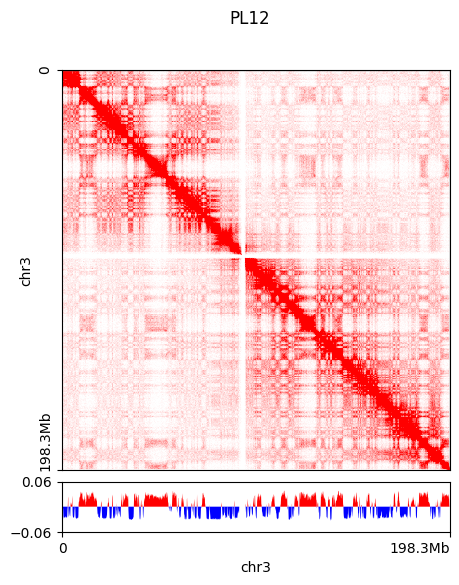

In [36]:
subset = COMPARTMENT_REGIONS_100kb[COMPARTMENT_REGIONS_100kb.chr == "chr3"]
subset_indices = subset.index
subset_x = (subset.start + subset.end) / 2

sample_id_paper = "PL12"
sample = [ s for s in samples if s.meta.id_paper == sample_id_paper][0]
arima_sample = read_sample(sample.meta.id_paper, sample.profile.hic, sample.profile.qc, None)
fig, ax = plt.subplots(2, 1, height_ratios=[8, 1], figsize=(5, 6))
fig.subplots_adjust(hspace=0.05)

ax_hic = ax[0]
ax_trace = ax[1]

plot_hic_chr_context(arima_sample, "chr3", "chr3", show_breakfinder_calls=False, ax=ax_hic, resolution=500000)
ax_hic.set_xticks([])
ymin, ymax = ax_hic.get_ylim()
ax_hic.set_yticks([ymax, ymin], [0, f"{CHROM_SIZES['chr3']/1e6:.1f}Mb"], rotation=90, ha="right")
ax_hic.get_yticklabels()[-1].set_va("bottom")
ax_hic.set_ylabel("chr3")
ax_hic.images[0].set_clim(0, 10)

compartments = read_compartments(sample.profile.compartments)
subset_values = compartments[subset_indices]
ax_trace.fill_between(subset_x, subset_values, where=subset_values>0, color="red", interpolate=True, ec="none")
ax_trace.fill_between(subset_x, subset_values, where=subset_values<0, color="blue", interpolate=True, ec="none")
ax_trace.set_xlim(0, CHROM_SIZES["chr3"])
ax_trace.set_ylim(-0.06, 0.06)
ax_trace.set_yticks([-0.06, 0.06])
ax_trace.set_xlabel("chr3")
ax_trace.set_xticks([0, CHROM_SIZES["chr3"]], [0, f"{CHROM_SIZES['chr3']/1e6:.1f}Mb"])
ax_trace.get_xticklabels()[-1].set_ha("right")
fig.suptitle("PL12")
fig.savefig(figure_path("supp1_compartments_example.svg"), bbox_inches="tight")

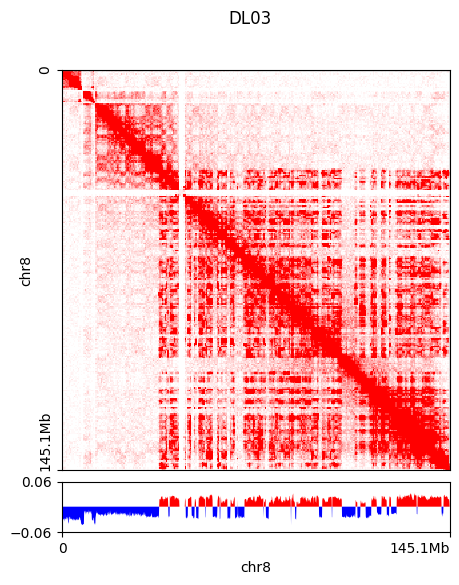

In [54]:
subset = COMPARTMENT_REGIONS_100kb[COMPARTMENT_REGIONS_100kb.chr == "chr8"]
subset_indices = subset.index
subset_x = (subset.start + subset.end) / 2

sample_id_paper = "DL03"
sample = [ s for s in samples if s.meta.id_paper == sample_id_paper][0]
arima_sample = read_sample(sample.meta.id_paper, sample.profile.hic, sample.profile.qc, None)
fig, ax = plt.subplots(2, 1, height_ratios=[8, 1], figsize=(5, 6))
fig.subplots_adjust(hspace=0.05)

ax_hic = ax[0]
ax_trace = ax[1]

plot_hic_chr_context(arima_sample, "chr8", "chr8", show_breakfinder_calls=False, ax=ax_hic, resolution=500000)
ax_hic.set_xticks([])
ymin, ymax = ax_hic.get_ylim()
ax_hic.set_yticks([ymax, ymin], [0, f"{CHROM_SIZES['chr8']/1e6:.1f}Mb"], rotation=90, ha="right")
ax_hic.get_yticklabels()[-1].set_va("bottom")
ax_hic.set_ylabel("chr8")
ax_hic.images[0].set_clim(0, 10)

compartments = read_compartments(sample.profile.compartments)
subset_values = compartments[subset_indices]
ax_trace.fill_between(subset_x, subset_values, where=subset_values>0, color="red", interpolate=True, ec="none")
ax_trace.fill_between(subset_x, subset_values, where=subset_values<0, color="blue", interpolate=True, ec="none")
ax_trace.set_xlim(0, CHROM_SIZES["chr8"])
ax_trace.set_ylim(-0.06, 0.06)
ax_trace.set_yticks([-0.06, 0.06])
ax_trace.set_xlabel("chr8")
ax_trace.set_xticks([0, CHROM_SIZES["chr8"]], [0, f"{CHROM_SIZES['chr8']/1e6:.1f}Mb"])
ax_trace.get_xticklabels()[-1].set_ha("right")
fig.suptitle(sample_id_paper)
fig.savefig(figure_path("supp5_compartments_tricky_chromothripsis.svg"), bbox_inches="tight")

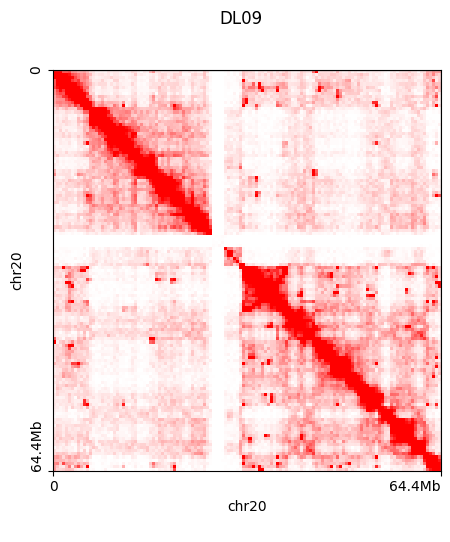

In [323]:
subset = COMPARTMENT_REGIONS_100kb[COMPARTMENT_REGIONS_100kb.chr == "chr20"]
subset_indices = subset.index
subset_x = (subset.start + subset.end) / 2

sample_id_paper = "DL09"
sample = [ s for s in samples if s.meta.id_paper == sample_id_paper][0]
arima_sample = read_sample(sample.meta.id_paper, sample.profile.hic, sample.profile.qc, None)
fig, ax = plt.subplots(2, 1, height_ratios=[8, 1], figsize=(5, 6))
fig.subplots_adjust(hspace=0.05)

ax_hic = ax[0]
ax_trace = ax[1]

plot_hic_chr_context(arima_sample, "chr20", "chr20", show_breakfinder_calls=False, ax=ax_hic, resolution=500000)
ax_hic.set_xticks([])
ymin, ymax = ax_hic.get_ylim()
ax_hic.set_yticks([ymax, ymin], [0, f"{CHROM_SIZES['chr20']/1e6:.1f}Mb"], rotation=90, ha="right")
ax_hic.get_yticklabels()[-1].set_va("bottom")
ax_hic.set_ylabel("chr20")
ax_hic.images[0].set_clim(0, 25)

compartments = read_compartments(sample.profile.compartments)
subset_values = compartments[subset_indices]
ax_trace.fill_between(subset_x, subset_values, where=subset_values>0, color="red", interpolate=True, ec="none")
ax_trace.fill_between(subset_x, subset_values, where=subset_values<0, color="blue", interpolate=True, ec="none")
ax_trace.set_xlim(0, CHROM_SIZES["chr20"])
ax_trace.set_ylim(-0.06, 0.06)
ax_trace.set_yticks([-0.06, 0.06])

ax_hic.set_xlabel("chr20")
xmin, xmax = ax_hic.get_xlim()
ax_hic.set_xticks([xmin,  xmax], [0, f"{CHROM_SIZES['chr20']/1e6:.1f}Mb"])
ax_hic.get_xticklabels()[-1].set_ha("right")

ax_trace.clear()
ax_trace.axis('off')
fig.suptitle(sample_id_paper)
fig.savefig(figure_path(f"supp5_compartments_other_chromothripsis_{sample_id_paper}.svg"), bbox_inches="tight")

# TADs Visualisation

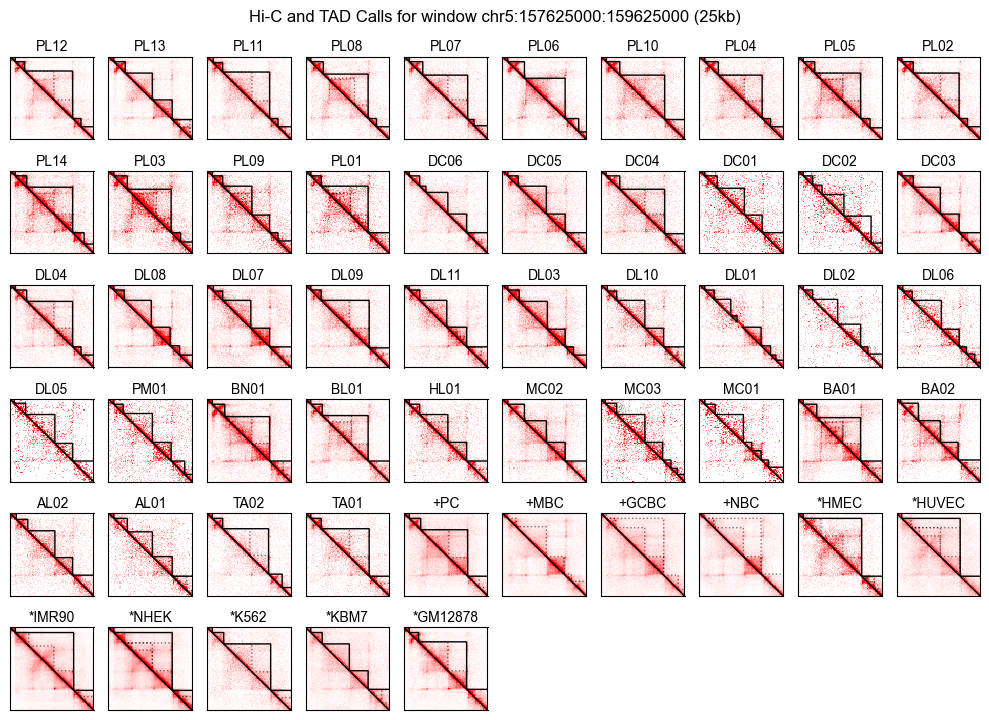

In [32]:
fig, axes = plt.subplots(6, 10, figsize=(10, 7.3))

region = Region("chr5", 157625000, 159625000)
resolution = 25000
num_plots = 0
for i, sample in enumerate(samples_all_merge):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    arima_sample = read_sample(sample.meta.id_paper, sample.profile.hic, sample.profile.qc, None)
    plot_hic_region_matrix(arima_sample, region, region, resolution, ax=ax, minimal=True, normalization=HIC_NORM, vmax=5)
    tads = read_tads(sample.profile.tads)
    for tad in tads:
        if tad.chr == region.chr and overlap(tad.to_region(), region):
            if tad.hierarchy == 0:
                alpha = 1
                linewidth=1.5
                ls="solid"
            else:
                alpha = 0.5
                linewidth=0.5
                ls=":"
            ax.add_patch(plt.Polygon([(tad.start, tad.start), (tad.end, tad.start), (tad.end, tad.end)], color="black", fill=False, alpha=alpha, linewidth=1, ls=ls))
    ax.set_xlabel(sample.meta.id_paper)
    ax.set_ylabel("")
    ax.xaxis.set_label_position("top")
    num_plots += 1
while num_plots < 6*10:
    row = num_plots // 10
    col = num_plots % 10
    ax = axes[row, col]
    ax.axis('off')
    num_plots += 1
fig.suptitle(f"Hi-C and TAD Calls for window {region.chr}:{region.start}:{region.end} ({int_to_resolution(resolution)})")
fig.tight_layout()
fig.savefig(figure_path("supp1_tads_all.svg"), bbox_inches="tight")

# Loop Visualisation

In [34]:
def plot_hic_region_matrix(
    sample: ArimaPipelineSample,
    regionX: Region,
    regionY: Region,
    resolution: int,
    ax: plt.Axes | None,
    minimal=False,
    show_breakfinder_calls=True,
    breakfinder_highlight:BreakfinderCall | BedpeLine | None=None,
    breakfinder_marker="+",
    breakfinder_color="black",
    normalization="NONE",
    vmax=None,
    cmap=REDMAP,
    title="",
    title_fontsize=11,
    label_fontsize=10,
    tick_fontsize=9,
    grid=False,
    crosshairs=False,
    show_submatrices=False,
    extra_bedpe: list[BedpeLine] = [],
) -> tuple[plt.Axes, tuple[int, int], tuple[int, int], list[tuple[str, int, str, float]]]:
    """Plots a specified Hi-C region.

    For most accurate alignment, the regions should be aligned at the start of a resolution bin.

    At the moment, only tested for regions of the same size (i.e. a square matrix).

    The color scale is capped at a quarter of the maximum value in the matrix by default.

    The axis limits have to be calculated here to ensure the plot is centered and axis limits are aligned with bins.

    """

    # Get plot axis (or get global axis if none provided)
    if ax is None:
        ax = plt.gca()

    # Get matrix data, then apply mask to values out of bounds (marked by -1s)
    data = get_hic_region_data(
        sample, regionX, regionY, resolution, normalization=normalization
    )
    masked = np.ma.masked_where(data < 0, data)

    # Unpack region for convenience
    chrX, startX, endX = regionX.chr, regionX.start, regionX.end
    chrY, startY, endY = regionY.chr, regionY.start, regionY.end

    # Get the "true" extent of the heatmap image (only an issue if the region start and end are not resolution bins)
    # True extent here is defined as the start of the first bin to the end of the last bin
    startTrueX, endTrueX = get_bin_extent(startX, endX, resolution)
    startTrueY, endTrueY = get_bin_extent(startY, endY, resolution)
    centerTrueX = (startTrueX + endTrueX) // 2
    centerTrueY = (startTrueY + endTrueY) // 2

    if vmax is None:
        vmax = np.max(masked) / 2

    ax.matshow(
        masked,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        aspect="auto",
        extent=[startTrueX, endTrueX, endTrueY, startTrueY],
    )
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Add axis labels (depending on level of detail)
    if minimal:
        # Minimal plot just has the hic matrix data and chromosome labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontdict={"fontsize": title_fontsize})
        ax.set_xlabel(f"{chrX}", fontdict={"fontsize": label_fontsize})
        ax.set_ylabel(f"{chrY}", fontdict={"fontsize": label_fontsize})

    else:
        # Make a start, center and end tick for each axis (and align appropriately on the axis)
        # Note: because of matshow, the bounds of the plot is actually offset by 0.5
        ax.set_xticks(
            [startTrueX, centerTrueX, endTrueX],
            map(lambda x: f"{x:,}", [startTrueX, centerTrueX, endTrueX]),
        )

        ax.set_yticks(
            [startTrueY, centerTrueY, endTrueY],
            map(lambda x: f"{x:,}", [startTrueY, centerTrueY, endTrueY]),
            rotation=90,
        )

        # Label the axes
        ax.set_xlabel(f"{chrX}", fontdict={"fontsize": label_fontsize})
        ax.set_ylabel(f"{chrY}", fontdict={"fontsize": label_fontsize}, rotation=90)
        ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)

        # Set tick param customizations
        ax.xaxis.set_tick_params(which="major", length=5)
        ax.yaxis.set_tick_params(which="major", length=5)
        ax.xaxis.tick_bottom()
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

        # Align the tick labels neatly
        xticklabels = ax.get_xticklabels()
        xticklabels[0].set_horizontalalignment("left")
        xticklabels[0].set_fontsize(tick_fontsize - 1)
        xticklabels[-1].set_horizontalalignment("right")
        xticklabels[-1].set_fontsize(tick_fontsize - 1)

        yticklabels = ax.get_yticklabels()
        yticklabels[0].set_verticalalignment("top")
        yticklabels[0].set_fontsize(tick_fontsize - 1)
        yticklabels[1].set_verticalalignment("center")
        yticklabels[-1].set_verticalalignment("bottom")
        yticklabels[-1].set_fontsize(tick_fontsize - 1)

        # Annotate the resolution of the heatmap
        scalebar = AnchoredSizeBar(
            ax.transData,
            resolution,
            int_to_resolution(resolution),
            "lower left",
            pad=0.5,
            frameon=False,
            fontproperties={"size": tick_fontsize},
            size_vertical=resolution,
        )
        ax.add_artist(scalebar)

    # Plot grid lines if specified (mostly just for tests)
    if grid:
        xminor_ticks = FixedLocator(np.arange(startTrueX, endTrueX, resolution))
        yminor_ticks = FixedLocator(np.arange(startTrueY, endTrueY, resolution))
        ax.xaxis.set_minor_locator(xminor_ticks)
        ax.yaxis.set_minor_locator(yminor_ticks)
        ax.grid(True, which="both", linestyle="solid", linewidth=0.5, color="gainsboro")

    # Plot annotations
    plotted_crosshairs = []
    if show_breakfinder_calls and sample.breakfinder_calls is not None:

        # Iterate through annotation sets: (annotations, color)
        for annotation_set, annotation_color in list(zip(extra_bedpe, BEDPE_COLORS)) + [
            (sample.breakfinder_calls, breakfinder_color)
        ]:

            # Select only breakpoints that involve these two chromosomes
            for call in annotation_set:

                # Check if call is a breakfinder call or a generic bedpe line type
                if isinstance(call, BreakfinderCall):
                    if call.breakpointA.chr == chrX and call.breakpointB.chr == chrY:
                        posX = call.breakpointA.pos
                        posY = call.breakpointB.pos
                        callStartX = call.breakpointA.start
                        callEndX = call.breakpointA.end
                        callStartY = call.breakpointB.start
                        callEndY = call.breakpointB.end
                    elif call.breakpointA.chr == chrY and call.breakpointB.chr == chrX:
                        posX = call.breakpointB.pos
                        posY = call.breakpointA.pos
                        callStartX = call.breakpointB.start
                        callEndX = call.breakpointB.end
                        callStartY = call.breakpointA.start
                        callEndY = call.breakpointA.end
                    else:
                        continue
                elif isinstance(call, BedpeLine):
                    # Default to start coordinate if a simple bedpe line
                    if call.chrA == chrX and call.chrB == chrY:
                        posX = call.startA
                        posY = call.startB
                        callStartX = call.startA
                        callEndX = call.endA
                        callStartY = call.startB
                        callEndY = call.endB
                    elif call.chrA == chrY and call.chrB == chrX:
                        posX = call.startB
                        posY = call.startA
                        callStartX = call.startB
                        callEndX = call.endB
                        callStartY = call.startA
                        callEndY = call.endA
                    else:
                        continue

                alpha = 1
                size = MARKER_SIZE_DICT[resolution]
                mew=size / 10
                if breakfinder_highlight is not None: 
                    if call != breakfinder_highlight:
                        alpha = 0.6
                        # size *= 0.6
                        mew *= 0.6

                # If the breakpoint is within the bounds of the plot, plot it
                if startTrueX <= posX <= endTrueX and startTrueY <= posY <= endTrueY:

                    # Plot the whole submatrix of breakfinder call if start and end are different
                    # Alternatively, if a bedpe and start and end are different, then plot the rectangle
                    if (
                        (show_submatrices or isinstance(call, BedpeLine))
                        and callStartX != callEndX
                        and callStartY != callEndY
                    ):
                        # Plot rectangle
                        rect = Rectangle(
                            (callStartX, callStartY),
                            callEndX - callStartX,
                            callEndY - callStartY,
                            linewidth=1,
                            edgecolor=annotation_color,
                            facecolor="none",
                            alpha=alpha,
                        )
                        ax.add_patch(rect)


                    # Plot the marker on the plot
                    # If a simple bedpe, then only plot a marker if the start and end are the same
                    if isinstance(call, BreakfinderCall) or (
                        callStartX == callEndX and callStartY == callEndY
                    ):
                        ax.plot(
                            posX,
                            posY,
                            marker=breakfinder_marker,
                            color=annotation_color,
                            markersize=size,
                            mew=mew,
                            alpha=alpha,
                        )

                        if crosshairs:
                            ax.axvline(
                                posX,
                                color=annotation_color,
                                linestyle=(0, (1, 5)),
                                linewidth=1,
                                alpha=alpha,
                            )
                            ax.axhline(
                                posY,
                                color=annotation_color,
                                linestyle=(0, (1, 5)),
                                linewidth=1,
                                alpha=alpha,
                            )
                            plotted_crosshairs.append((chrX, posX, annotation_color, alpha))
                            plotted_crosshairs.append((chrY, posY, annotation_color, alpha))

    # Reset x and y lim, in case the plotting of the markers changed it
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax, (startTrueX, endTrueX), (startTrueY, endTrueY), plotted_crosshairs

In [35]:
goi = GENE_ANNOTATIONS.genes_by_name("LMO2")[0]
roiA = Region("chr11", 33800000,33890000)
roiB = Region("chr11", 33950000, 34010000)

PL12 chr11:33850000-33860000 (chr11:33855000) - chr11:33980000-33990000 (chr11:33985000)
PL10 chr11:33860000-33870000 (chr11:33865000) - chr11:33970000-33980000 (chr11:33975000)
PL04 chr11:33840000-33850000 (chr11:33845000) - chr11:33960000-33970000 (chr11:33965000)
PL04 chr11:33850000-33860000 (chr11:33855000) - chr11:33960000-33970000 (chr11:33965000)
PL03 chr11:33860000-33870000 (chr11:33865000) - chr11:33980000-33990000 (chr11:33985000)
DC05 chr11:33850000-33860000 (chr11:33855000) - chr11:33960000-33970000 (chr11:33965000)
DC03 chr11:33850000-33860000 (chr11:33855000) - chr11:33960000-33970000 (chr11:33965000)
DL04 chr11:33850000-33860000 (chr11:33855000) - chr11:33980000-33990000 (chr11:33985000)
DL08 chr11:33840000-33850000 (chr11:33845000) - chr11:33970000-33980000 (chr11:33975000)
DL08 chr11:33840000-33850000 (chr11:33845000) - chr11:33980000-33990000 (chr11:33985000)
DL07 chr11:33850000-33860000 (chr11:33855000) - chr11:33970000-33980000 (chr11:33975000)
DL09 chr11:33850000-3

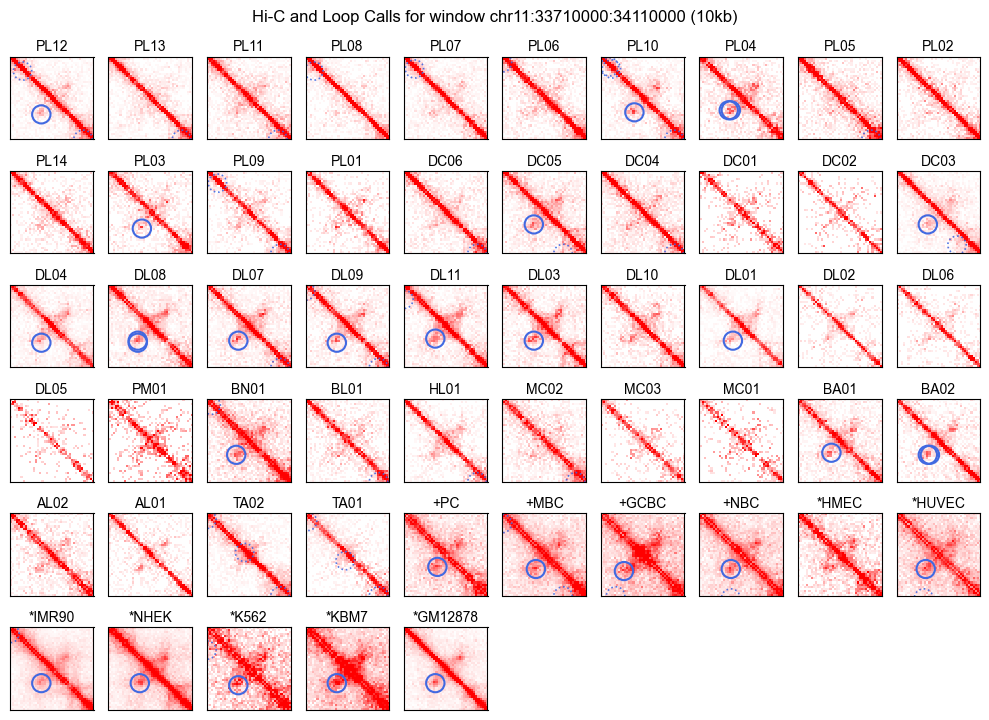

In [36]:
fig, axes = plt.subplots(6, 10, figsize=(10, 7.3))

region = Region("chr11", 33710000, 34110000)
resolution = 10000
num_plots = 0 
for i, sample in enumerate(samples_all_merge):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    arima_sample = read_sample(sample.meta.id_paper, sample.profile.hic, sample.profile.qc, None)
    plot_hic_region_matrix(arima_sample, region, region, resolution, ax=ax, minimal=True, normalization=HIC_NORM)
    loops = read_loops(sample.profile.loops_hicexplorer)
    for loop in loops:
        loop_regionA, loop_regionB = loop.to_regions()
        if overlap(loop_regionA, region) and overlap(loop_regionB, region):
            if overlap(loop_regionA, roiA) and overlap(loop_regionB, roiB): 
                alpha = 1
                lw=1.5
                ls="solid"
                print(sample.meta.id_paper, loop)
            else:
                alpha=0.9
                lw=1.2
                ls="dotted"
            ax.add_patch(plt.Circle((loop.posA+resolution/2, loop.posB+resolution/2), resolution * 4.4, color=LOOP_COLOUR, fill=False, alpha=alpha,linewidth=lw, ls=ls))
    ax.set_xlabel(sample.meta.id_paper)
    ax.set_ylabel("")
    ax.xaxis.set_label_position("top")
    num_plots += 1

while num_plots < 6*10:
    row = num_plots // 10
    col = num_plots % 10
    ax = axes[row, col]
    ax.axis('off')
    num_plots += 1
fig.suptitle(f"Hi-C and Loop Calls for window {region.chr}:{region.start}:{region.end} ({int_to_resolution(resolution)})")
fig.tight_layout()
fig.savefig(figure_path("supp1_loop_all.svg"), bbox_inches="tight")

# Neoloop Compartments

In [263]:
regions = COMPARTMENT_REGIONS_100kb

def get_compartment_score_at_position(compartments: np.array, regions: pd.DataFrame, chr: str, pos: int):
    try:
        region_index = regions[(regions["chr"] == chr) & (regions["start"] <= pos) & (regions["end"] >= pos)].index[0]
    except:
        print(chr, pos)
    return compartments[region_index]

all_compartment_pairings_neoloop = []
all_compartment_pairings_sv = []

for sample in samples:
    neoloops = read_neoloops(sample.profile.neoloops)
    svs = read_curated_calls(sample.profile.curated)
    compartments = read_compartments(sample.profile.compartments)
    for neoloop in neoloops:
        if neoloop.chrA not in {"chrX", "chrY"} and neoloop.chrB not in {"chrX", "chrY"}:
            compA = get_compartment_score_at_position(compartments, regions, neoloop.chrA, neoloop.posA)
            compB = get_compartment_score_at_position(compartments, regions, neoloop.chrB, neoloop.posB)
            all_compartment_pairings_neoloop.append((compA, compB))
    for sv in svs:
        if sv.chrA not in {"chrX", "chrY"} and sv.chrB not in {"chrX", "chrY"}:
            compA = get_compartment_score_at_position(compartments, regions, sv.chrA, sv.posA)
            compB = get_compartment_score_at_position(compartments, regions, sv.chrB, sv.posB)
            all_compartment_pairings_sv.append((compA, compB))

In [278]:
neoloop_compartment_groups = []
sv_compartment_groups = []

for pairing in all_compartment_pairings_neoloop:
    if pairing[0] < 0 and pairing[1] < 0:
        neoloop_compartment_groups.append("B-B")
    elif (pairing[0] > 0 and pairing[1] <0 ) or (pairing[0] < 0 and pairing[1] > 0 ):
        neoloop_compartment_groups.append("A-B")
    elif pairing[0] > 0 and pairing[1] > 0:
        neoloop_compartment_groups.append("A-A")
    else:
        print("Invalid or ambiguous group.")

for pairing in all_compartment_pairings_sv:
    if pairing[0] < 0 and pairing[1] < 0:
        sv_compartment_groups.append("B-B")
    elif (pairing[0] > 0 and pairing[1] <0 ) or (pairing[0] < 0 and pairing[1] > 0 ):
        sv_compartment_groups.append("A-B")
    elif pairing[0] > 0 and pairing[1] > 0:
        sv_compartment_groups.append("A-A")
    else:
        print("Invalid or ambiguous group.")

Invalid or ambiguous group.
Invalid or ambiguous group.
Invalid or ambiguous group.
Invalid or ambiguous group.
Invalid or ambiguous group.


In [279]:
neoloop_group_counts = Counter(neoloop_compartment_groups)
sv_group_counts = Counter(sv_compartment_groups)

In [ ]:
# Compare to randomly selected genomic regions

random_compartment_pairings = []

# Randomly choose a chromosome with weights based on chromosome size
chr_choices = [ chr for chr in CHROMS if chr not in {"chrX", "chrY"}]
chr_weights = np.array([ CHROM_SIZES[chr] for chr in chr_choices ])
chr_weights = chr_weights / np.sum(chr_weights)

for sample in samples:
    neoloops = read_neoloops(sample.profile.neoloops)
    svs = read_curated_calls(sample.profile.curated)
    compartments = read_compartments(sample.profile.compartments)
    n = len([ neoloop for neoloop in neoloops if neoloop.chrA not in {"chrX", "chrY"} and neoloop.chrB not in {"chrX", "chrY"}])
    chr_selectedA = np.random.choice(chr_choices, size=n, p=chr_weights)
    chr_selectedB = np.random.choice(chr_choices, size=n, p=chr_weights)
    random_paired_pos = []
    for chrA, chrB in zip(chr_selectedA, chr_selectedB):
        posA = random.randint(0, CHROM_SIZES[chrA]-1)
        posB = random.randint(0, CHROM_SIZES[chrB]-1)
        random_paired_pos.append((chrA, posA, chrB, posB))
    for (chrA, posA, chrB, posB) in random_paired_pos:
        compA = get_compartment_score_at_position(compartments, regions, chrA, posA)
        compB = get_compartment_score_at_position(compartments, regions, chrB, posB)
        random_compartment_pairings.append((compA, compB))

random_compartment_groups = []

for pairing in random_compartment_pairings:
    if pairing[0] < 0 and pairing[1] < 0:
        random_compartment_groups.append("B-B")
    elif (pairing[0] > 0 and pairing[1] <0 ) or (pairing[0] < 0 and pairing[1] > 0 ):
        random_compartment_groups.append("A-B")
    elif pairing[0] > 0 and pairing[1] > 0:
        random_compartment_groups.append("A-A")
    else:
        print(pairing)
        print("Invalid or ambiguous group.")

    
random_group_counts = Counter(random_compartment_groups)

random_group_counts

In [281]:
groups = ["A-A", "A-B", "B-B"]

counts_random = np.array([ random_group_counts[g] for g in groups ]) / sum(random_group_counts.values())
counts_sv =np.array([ sv_group_counts[g] for g in groups ]) / sum(sv_group_counts.values())
counts_neoloops =np.array([ neoloop_group_counts[g] for g in groups ]) / sum(neoloop_group_counts.values())

In [293]:
print(counts_random)
print(counts_sv)
print(counts_neoloops)

[0.23054755 0.50129683 0.26815562]
[0.56641221 0.27022901 0.16335878]
[0.81584665 0.08102236 0.10313099]


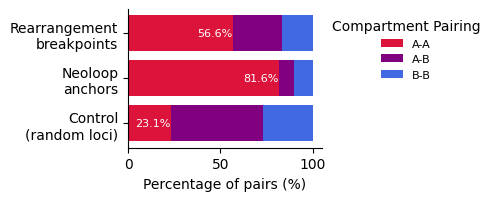

In [307]:
fig, ax = plt.subplots(figsize=(2.5, 1.8))
y = 0
ypos = []
ylabels = []
for i, label, counts in zip(range(3), ["Rearrangement\nbreakpoints", "Neoloop\nanchors", "Control\n(random loci)"], [counts_sv, counts_neoloops, counts_random,]):
    alpha = 1
    if label == "Random":
        y += 0.25
        # alpha = 0.5
    ax.barh(y, counts[0]*100, color="crimson", label="A-A", alpha=alpha)
    ax.text(counts[0]*100, y, f"{counts[0]*100:.1f}%", ha="right", va="center", color="white", fontsize=8)
    ax.barh(y, counts[1]*100, left=counts[0]*100, color="purple", label="A-B", alpha=alpha)
    ax.barh(y, counts[2]*100, left=counts[0]*100+counts[1]*100, color="royalblue", label="B-B", alpha=alpha)
    ylabels.append(label)
    ypos.append(y)
    y += 1

ax.set_yticks(ypos, ylabels)
ax.spines[["top", "right"]].set_visible(False)

# Deduplicate legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left", frameon=False, prop={'size': 8}, bbox_to_anchor=(1, 1), title="Compartment Pairing")
ax.set_xlabel("Percentage of pairs (%)")
ax.invert_yaxis()

fig.savefig(figure_path("supp_compartment_pairing_groups.svg"), bbox_inches="tight")


# Composite Virtual 4C

In [69]:
# # First get all samples with a rearrangement between genes of interest
def plot_composite_virtual4c(geneA, strandA, geneB, strandB, anchor_chr, anchor_pos, highlight_id, bigwig_file, bigwig_label, assembly, clim_oe_max=GLOBAL_OE_MAX, bigwig_max=GLOBAL_BW_MAX, figsize=(9,7.2), exclude=[]):
    
    lymphoma_sample_ids = [ s.meta.id_file for s in samples if s.meta.availability == "internal"]
    subset_ids = []
    for sample_id in lymphoma_sample_ids:
        if sample_id in exclude:
            continue
        svs = pd.read_csv(f"../data/curated_breakpoints/{sample_id}_curated_breakpoints.tsv", sep='\s+', header=None, names=["chrA", "chrB", "strands", "posA", "posB", "sv_type"])
        for i, sv in svs.iterrows():
            chrA = sv["chrA"]
            posA = sv["posA"]
            this_strandA = Strand.POS if sv["strands"][0] == "+" else Strand.NEG
            chrB = sv["chrB"]
            posB = sv["posB"]
            this_strandB = Strand.POS if sv["strands"][1] == "+" else Strand.NEG
            genesA, genesB = show_nearby_genes_stranded_unrolled(chrA, posA, this_strandA, chrB, posB, this_strandB, width=1000000, buffer=25000, protein_coding=False)
            if (geneA in genesA and geneB in genesB and this_strandA == strandA and this_strandB == strandB):
                subset_ids.append((sample_id, sv))
                break
            elif (geneA in genesB and geneB in genesA and this_strandB == strandA and this_strandA == strandB):
                # Swap sv A and B chr, strands and positions
                sv["chrA"], sv["chrB"] = sv["chrB"], sv["chrA"]
                sv["strands"] = sv["strands"][::-1]
                sv["posA"], sv["posB"] = sv["posB"], sv["posA"]
                subset_ids.append((sample_id, sv))
                break


    subset_ids.sort(key=lambda x: get_uvp(x[0]), reverse=True)

    # Retrieve the highlight id, put it at the top of the list
    highlight_index = None
    for i, (sample_id, sv) in enumerate(subset_ids):
        if sample_id == highlight_id:
            highlight_index = i
            break
    if highlight_index is not None:
        subset_ids = [subset_ids[highlight_index]] + subset_ids[:highlight_index] + subset_ids[highlight_index+1:]


    sample = [ s for s in samples if s.meta.id_file == highlight_id ][0]
    hic_file = read_hic(f"../data/hic/{highlight_id}_inter_30.hic")
    assembled = assemble_hic(hic_file, assembly, gap_size=0, norm=HIC_NORM)


    track_specs = [ 
        TrackSpec(
            track_type = TrackType.TRACK_VIRTUAL_4C,
            track_kwargs = {
                "hic_file": read_hic(f"../data/hic/{subset_ids[0][0]}_inter_30.hic"),
                "anchor_chr": anchor_chr,
                "anchor_pos": anchor_pos,
                "anchor_bin_radius": 0,
                "measure": "oe",
                "norm": HIC_NORM,
                "adjust_with_sv": sv
            },
            ylabel = [ s.meta.id_paper for s in samples if s.meta.id_file == subset_ids[0][0]][0],
            rel_height=0.5
        ),
        TrackSpec(
            track_type = TrackType.TRACK_CHR_ARROWS,
            track_kwargs = {
                "label_chr": False,
                "adjust_with_sv": subset_ids[0][1],
            },
            rel_height=0.25
        ),
        TrackSpec(
            track_type = TrackType.TRACK_GENES, 
            track_kwargs = {
                "fontsize": 12,
                "centered_names": False,
                "max_rows": 1,
                "min_rows": 1,
                "gene_filter": ["CCND1", "MYC",  "BCL2"]
            },
            ylabel="Genes",
        ),
        TrackSpec(
            track_type = TrackType.TRACK_BIGWIG,
            track_kwargs = {
                "bw_handle": pyBigWig.open(bigwig_file),
                "color": BIGWIG_COLOUR,
                "show_ylim": True,
                "ymax": GLOBAL_BW_MAX,
            },
            ylabel=f"H3K27ac\n({bigwig_label})",
            rel_height=1.5,
        ),
        TrackSpec(
            track_type = TrackType.TRACK_BED_DIRECTIONAL,
            track_kwargs = {
                "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
                "color": CTCF_COLOUR,
            },
            ylabel="CTCF",
            rel_height=0.5
        ),
        TrackSpec(
            track_type = TrackType.TRACK_CHR_ARROWS,
            track_kwargs = {
                "label_chr": True
            },
            ylabel="Region",
            rel_height=1,
        ),
        TrackSpec(
            track_type = TrackType.TRACK_BLANK,
            rel_height=0.5,
        )
    ]


    for sample_id, sv in subset_ids[1:]:
        new_track = TrackSpec(
            track_type = TrackType.TRACK_VIRTUAL_4C,
            track_kwargs = {
                "hic_file": read_hic(f"../data/hic/{sample_id}_inter_30.hic"),
                "anchor_chr": anchor_chr,
                "anchor_pos": anchor_pos,
                "anchor_bin_radius": 0,
                "measure": "oe",
                "norm": HIC_NORM,
                "adjust_with_sv": sv
            },
            ylabel = [ s.meta.id_paper for s in samples if s.meta.id_file == sample_id][0],
            rel_height=0.5
        )
        new_chr_arrows = TrackSpec(
            track_type = TrackType.TRACK_CHR_ARROWS,
            track_kwargs = {
                "label_chr": False,
                "adjust_with_sv": sv
            },
            rel_height=0.25
        )
        track_specs.append(new_track)
        track_specs.append(new_chr_arrows)

    track_specs.append(TrackSpec(
        track_type = TrackType.TRACK_BLANK,
        rel_height=0.5,
    ))

    track_specs.append(TrackSpec(
        track_type = TrackType.TRACK_VIRTUAL_4C,
        track_kwargs = {
            "hic_file": read_hic("../data/hic/GSE63525_GM12878_inter_30.hic"),
            "anchor_chr": anchor_chr,
            "anchor_pos": anchor_pos,
            "anchor_bin_radius": 0,
            "measure": "oe",
            "norm": HIC_NORM,
        },
        ylabel = "GM12878",
        rel_height=0.5
    ))
    track_specs.append(TrackSpec(
        track_type = TrackType.TRACK_CHR_ARROWS,
        track_kwargs = {
            "label_chr": False
        },
        rel_height=0.25
    ))

    fig = plt.figure(figsize=figsize)
    gs_cols = len(assembled.plot_regions)
    width_ratios = [r.bin_range[1] - r.bin_range[0] for r in assembled.plot_regions]
    gs_rows = 1 + len(track_specs)
    height_ratios = [16] + [ r.rel_height for r in track_specs ]
    gs = fig.add_gridspec(gs_rows, gs_cols, width_ratios=width_ratios, height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0, wspace=0)

    # Plot neoloops
    points_to_plot = []
    neoloops = read_neoloops(sample.profile.neoloops)
    for neoloop in neoloops:
        neoloop_regionA, neoloop_regionB = neoloop.to_regions()
        if (neoloop_regionA.chr == assembly.segments[0].segment.chr and neoloop_regionB.chr == assembly.segments[1].segment.chr) or \
            (neoloop_regionB.chr == assembly.segments[0].segment.chr and neoloop_regionA.chr == assembly.segments[1].segment.chr):
            points_to_plot.append(neoloop)

    ax_triangle = fig.add_subplot(gs[0, :])
    mask_sv = subset_ids[0][1]
    plot_assembled_triangle(assembled, ax_triangle, vmax=np.nanmax(assembled.data) / 12, aspect="auto", mask=mask_sv, rasterized=True, plot_points=points_to_plot,
                           plot_point_kwargs={"ec": LOOP_COLOUR, "ls": ":", "lw": 1.5})



    track_ax = []
    for row, track_spec in enumerate(track_specs):
        row_plots = [] 
        for col, plot_region in enumerate(assembled.plot_regions):
            ax = fig.add_subplot(gs[row+1, col])
            plot_track(ax, plot_region, track_spec, is_first=(col==0), is_last=(col==gs_cols-1))
            row_plots.append(ax)
        track_ax.append(row_plots)

    # Modifications
    # - Set colormap for virtual 4C tracks in each row to be the same
    # - Remove ylabel for the second column 
    # - Change bigwig track limits to be the same 
    # - Remove gray axis facecolor if blank track 
    first_virtual_track = None
    for i, row in enumerate(track_specs):
        if row.track_type == TrackType.TRACK_VIRTUAL_4C:
            first_virtual_track = i
            break
    clim_oe_max = clim_oe_max
    for i, row in enumerate(track_specs):

        for j in range(gs_cols):
            if j > 0:
                track_ax[i][j].set_ylabel("")

        if row.track_type == TrackType.TRACK_VIRTUAL_4C:

            # Set clim max global 
            for j in range(gs_cols):
                if track_ax[i][j].images:
                    track_ax[i][j].images[0].set_clim(0, clim_oe_max)

                # Add scatter point corresponding to anchor
                if  assembled.plot_regions[j].matched_segment and assembled.plot_regions[j].matched_segment.segment.chr == anchor_chr:
                    s = assembled.plot_regions[j].matched_segment 
                    bin_start, bin_end = assembled.plot_regions[j].bin_range
                    plot_width = bin_end - bin_start
                    if s.segment.is_minus_strand:
                        pos = (1 - (anchor_pos - s.segment.start) / (s.segment.end  - s.segment.start)) * plot_width - 0.5
                    else:
                        pos = (anchor_pos - s.segment.start) / (s.segment.end - s.segment.start) * plot_width - 0.5
                    # track_ax[i][j].scatter([pos], [0], marker="d", color="black")
                    track_ax[i][j].axvspan(pos-0.5, pos+0.5, color="yellow", alpha=0.25)
            
            
        elif row.track_type == TrackType.TRACK_BIGWIG:
            for j in range(gs_cols):
                # Change bigwig y limit
                track_ax[i][j].set_ylim(0, bigwig_max)


        elif row.track_type == TrackType.TRACK_BLANK:
            for j in range(gs_cols):
                track_ax[i][j].set_facecolor("white")
    return fig

<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_2477729/171918443.py:9: DeprecationWarning: invalid escape sequence '\s'
  svs = pd.read_csv(f"../data/curated_breakpoints/{sample_id}_curated_breakpoints.tsv", sep='\s+', header=None, names=["chrA", "chrB", "strands", "posA", "posB", "sv_type"])


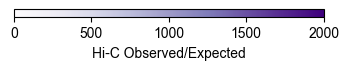

In [70]:
cmap = matplotlib.colormaps.get("Purples")
norm = matplotlib.colors.Normalize(vmin=0, vmax=GLOBAL_OE_MAX)

fig, ax = plt.subplots(figsize=(4, 0.1))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Hi-C Observed/Expected')
fig.savefig(figure_path("fig2_composite_oe_colorbar.svg"), bbox_inches="tight")

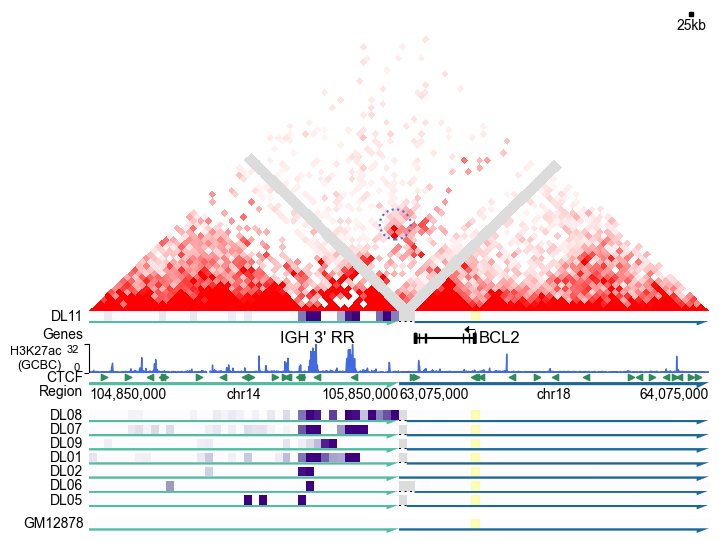

In [71]:
geneA = "IGHM"
strandA = Strand.POS
geneB = "BCL2"
strandB = Strand.NEG
anchor_chr = "chr18"
anchor_pos = 63320128
highlight_id = "internal_id2"
bigwig_file = "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw"
bigwig_label = "GCBC"
assembly = Assembly([
    bin_align_segment(Segment("chr14", 104850000, 105850000), 25000),
    bin_align_segment(Segment("chr18", 63080000, 64080000), 25000),
])

fig = plot_composite_virtual4c(geneA, strandA, geneB, strandB, anchor_chr, anchor_pos, highlight_id, bigwig_file, bigwig_label, assembly, bigwig_max=GLOBAL_BW_MAX, figsize=(8, 6.8))

fig.axes[5].text(105586437, 0.25, "IGH 3' RR", ha="center", va="center", clip_on=False, fontsize=12)
fig.axes[7].yaxis.label.set_size(9)
fig.savefig(figure_path(f"fig2_{geneA}_{geneB}_triangle.svg"), bbox_inches="tight")

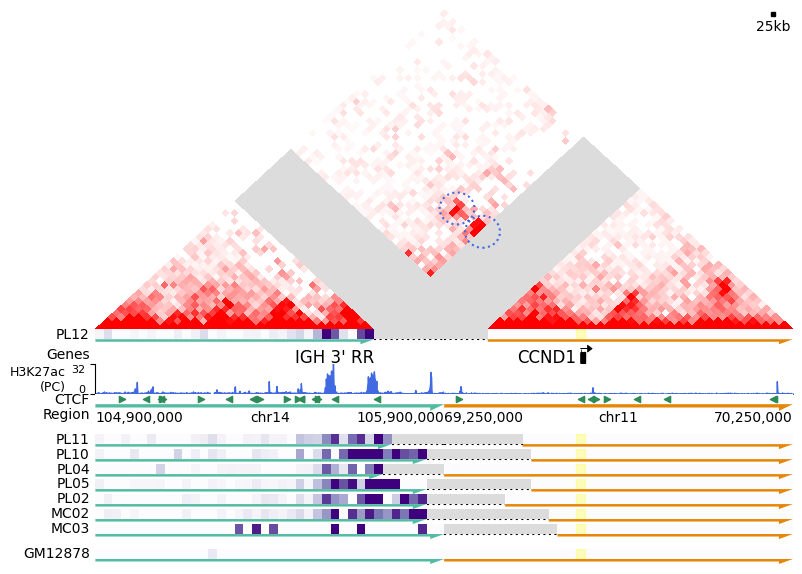

In [22]:
geneA = "IGHA2"
strandA = Strand.POS
geneB = "CCND1"
strandB = Strand.NEG
anchor_chr = "chr11"
anchor_pos = 69640000
highlight_id = "internal_id3"
bigwig_file = "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"
bigwig_label = "PC"
assembly = Assembly([
    bin_align_segment(Segment("chr14", 104900000, 105900000), 25000),
    bin_align_segment(Segment("chr11", 69250000, 70250000), 25000),
])

fig = plot_composite_virtual4c(geneA, strandA, geneB, strandB, anchor_chr, anchor_pos, highlight_id, bigwig_file, bigwig_label, assembly)
fig.axes[5].text(105586437, 0.25, "IGH 3' RR", ha="center", va="center", clip_on=False, fontsize=12)
fig.axes[7].yaxis.label.set_size(9)
fig.savefig(figure_path(f"fig2_{geneA}_{geneB}_triangle.svg"), bbox_inches="tight")

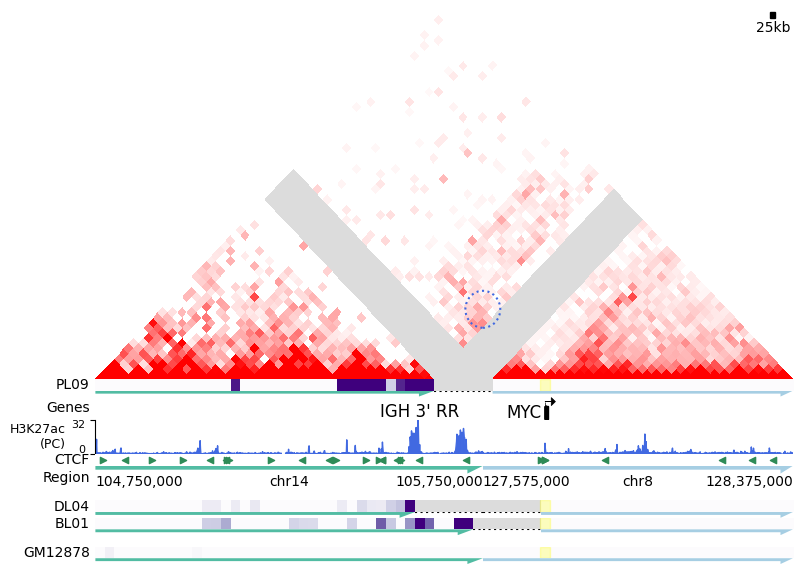

In [143]:
geneA = "IGHA2"
strandA = Strand.POS
geneB = "MYC"
strandB = Strand.NEG
anchor_chr = "chr8"
anchor_pos = 127735434
highlight_id = "internal_id21"
bigwig_file = "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"
bigwig_label = "PC"
assembly = Assembly([
    bin_align_segment(Segment("chr14", 104750000, 105750000), 25000),
    bin_align_segment(Segment("chr8", 127575000, 128380000), 25000),
])

fig = plot_composite_virtual4c(geneA, strandA, geneB, strandB, anchor_chr, anchor_pos, highlight_id, bigwig_file, bigwig_label, assembly, clim_oe_max=GLOBAL_OE_MAX)
fig.axes[5].text(105586437, 0.25, "IGH 3' RR", ha="center", va="center", clip_on=False, fontsize=12)
fig.axes[7].yaxis.label.set_size(9)
fig.savefig(figure_path(f"fig2_{geneA}_{geneB}_triangle.svg"), bbox_inches="tight")

# ROI Snapshots

<>:45: DeprecationWarning: invalid escape sequence '\s'
<>:45: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_928338/198896674.py:45: DeprecationWarning: invalid escape sequence '\s'
  svs = pd.read_csv(f"../data/curated_breakpoints/{sample_id}_curated_breakpoints.tsv", sep='\s+', header=None, names=["chrA", "chrB", "strands", "posA", "posB", "sv_type"])
/tmp/ipykernel_928338/198896674.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


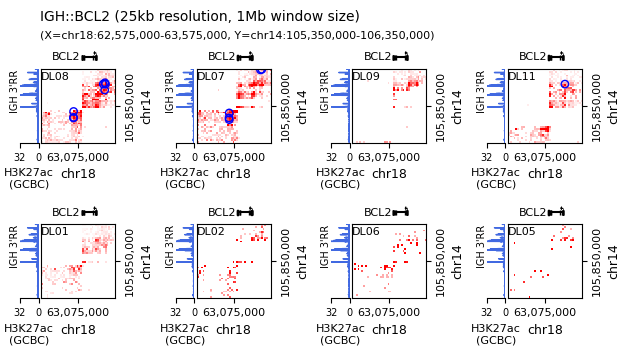

In [85]:
geneA = "IGHM"
strandA = Strand.POS
geneB = "BCL2"
strandB = Strand.NEG
anchor_chr = "chr18"
anchor_pos = 63320128
highlight_id = "internal_id6"
bigwig_file = "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw"
bigwig_label = "GCBC"
assembly = Assembly([
    bin_align_segment(Segment("chr14", 104850000, 105850000), 25000),
    bin_align_segment(Segment("chr18", 63080000, 64080000), 25000),
])

exclude = []
ncols = 4
nrows = 2
resolution = 25000
title = "IGH::BCL2"
enhancer_label="IGH 3'RR"
enhancer_label_loc = 105650000

segmentA = assembly.segments[1]
segmentB = assembly.segments[0]

startA = segmentA.segment.start - 500000
endA = segmentA.segment.end - 500000
chrA = segmentA.segment.chr

startB = segmentB.segment.start + 500000
endB = segmentB.segment.end + 500000
chrB = segmentB.segment.chr
assert endA - startA == endB - startB


def plot_supp_recurrent(geneA, strandA, geneB, strandB, bigwig_file, bigwig_label, chrA, startA, endA, chrB, startB, endB, exclude, ncols, nrows, resolution, title, enhancer_label, enhancer_label_loc,
                       replace_pl=False):
    
    gene_filter = [geneA, geneB]
    lymphoma_sample_ids = [ s.meta.id_file for s in samples if s.meta.availability == "internal"]
    subset_ids = []
    for sample_id in lymphoma_sample_ids:
        if sample_id in exclude:
            continue
        svs = pd.read_csv(f"../data/curated_breakpoints/{sample_id}_curated_breakpoints.tsv", sep='\s+', header=None, names=["chrA", "chrB", "strands", "posA", "posB", "sv_type"])
        for i, sv in svs.iterrows():
            sv_chrA = sv["chrA"]
            sv_posA = sv["posA"]
            this_strandA = Strand.POS if sv["strands"][0] == "+" else Strand.NEG
            sv_chrB = sv["chrB"]
            sv_posB = sv["posB"]
            this_strandB = Strand.POS if sv["strands"][1] == "+" else Strand.NEG
            genesA, genesB = show_nearby_genes_stranded_unrolled(sv_chrA, sv_posA, this_strandA, sv_chrB, sv_posB, this_strandB, width=1000000, buffer=25000, protein_coding=False)
            if (geneA in genesA and geneB in genesB and this_strandA == strandA and this_strandB == strandB):
                subset_ids.append((sample_id, sv))
                break
            elif (geneA in genesB and geneB in genesA and this_strandB == strandA and this_strandA == strandB):
                # Swap sv A and B chr, strands and positions
                sv["chrA"], sv["chrB"] = sv["chrB"], sv["chrA"]
                sv["strands"] = sv["strands"][::-1]
                sv["posA"], sv["posB"] = sv["posB"], sv["posA"]
                subset_ids.append((sample_id, sv))
                break
    
    
    subset_ids.sort(key=lambda x: get_uvp(x[0]), reverse=True)
    

    
    fig = plt.figure(figsize=(ncols * 2, nrows*2))
    
    height_ratios = [1, 4, 3] * nrows
    width_ratios = [1, 4, 3] * ncols
    spec = fig.add_gridspec(nrows*3, ncols*3, height_ratios=height_ratios, width_ratios=width_ratios, hspace=0.05, wspace=0.05)
    
    nplots = 0 
    while nplots < nrows * ncols:
        row = 3 * (nplots // ncols)
        col = 3 * (nplots % ncols)
        ax_bigwig_left = fig.add_subplot(spec[row+1, col])
        ax_gene_top = fig.add_subplot(spec[row, col+1])
        ax_hic = fig.add_subplot(spec[row+1, col+1])
        if nplots >= len(subset_ids):
            blank_axis(ax_gene_top)
            blank_axis(ax_bigwig_left)
            blank_axis(ax_hic)
        else:
            sample_id_file, sv = subset_ids[nplots]
            sample = [s for s in samples if s.meta.id_file == sample_id_file][0]
           
            plot_gene_track(chrA, startA, endA, ax=ax_gene_top, max_rows=5, gene_filter=gene_filter, all_same_line=True, min_rows=0 )
            ax_gene_top.set_ylim([-0.7, 0.7])

            if replace_pl:
                if sample.meta.group == "PCN":
                    bigwig_file = "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"
                    bigwig_label="PC"
            plot_bigwig_track(pyBigWig.open(bigwig_file), chrB, startB, endB, ax=ax_bigwig_left, vertical=True, ymax=GLOBAL_BW_MAX, color=BIGWIG_COLOUR)
            ax_bigwig_left.xaxis.set_visible(True)
            ax_bigwig_left.set_xticks([GLOBAL_BW_MAX, 0], [GLOBAL_BW_MAX, 0], fontsize=7)
            ax_bigwig_left.set_xlabel(f"H3K27ac\n({bigwig_label})", fontsize=8)
            ax_bigwig_left.spines[["bottom"]].set_visible(True)
            ax_bigwig_left.text(GLOBAL_BW_MAX, enhancer_label_loc, enhancer_label, ha="right", va="center", rotation=90, fontsize=7)

            ax_bigwig_left.text
            
            arima_sample = read_sample(sample.meta.id_file, sample.profile.hic, sample.profile.qc, None)
            arima_sample = replace(arima_sample, breakfinder_calls=[BreakfinderCall(Breakpoint(sv.chrA, sv.posA, sv.posA, sv.posA, sv.strands[0]), Breakpoint(sv.chrB, sv.posB, sv.posB, sv.posB, sv.strands[1]), 0, 0, Pairing.INTER, VariantCategory.TRANSLOCATION)])
            plot_hic_region_matrix(arima_sample, Region(chrA, startA, endA), Region(chrB, startB, endB), resolution, ax=ax_hic, minimal=True, normalization=HIC_NORM, breakfinder_marker=" ")

            # Plot loops
            neoloops = read_neoloops(sample.profile.neoloops)
            for neoloop in neoloops:
                if neoloop.chrA == chrA and neoloop.chrB == chrB:
                    if startA <= neoloop.posA <= endA and startB <= neoloop.posB <= endB:
                        width = (endA - startA) / 10
                        ellipse = Ellipse((neoloop.posA, neoloop.posB), width, width, ec="blue", fc="none")
                        ax_hic.add_patch(ellipse)
                elif neoloop.chrA == chrB and neoloop.chrB == chrA:
                    if startA <= neoloop.posB <= endA and startB <= neoloop.posA <= endB:
                        width = (endA - startA) / 10
                        ellipse = Ellipse((neoloop.posB, neoloop.posA), width, width, ec="blue", fc="none")
                        ax_hic.add_patch(ellipse)
                
                                   
            posA = (startA + endA) // 2
            posB = (startB + endB) // 2
            ax_hic.yaxis.set_label_position("right")
            ax_hic.set_yticks([posB], [f"{posB:,}"], fontsize=8, rotation=90, ha="left", va="center")
            ax_hic.set_xticks([posA], [f"{posA:,}"], fontsize=8)
            ax_hic.xaxis.tick_bottom()
            ax_hic.yaxis.tick_right()
            ax_hic.yaxis.label.set_size(9)
            ax_hic.xaxis.label.set_size(9)
            ax_hic.set_title(sample.meta.id_paper, va="top", ha="left", fontsize=8, x=0, y=0.85)
        nplots += 1
    fig.suptitle(f"{title} ({int_to_resolution(resolution)} resolution, {int_to_resolution(endA-startA)} window size)\n", ha="left", x=0.15, va="bottom", y=0.9, fontsize=10)
    fig.axes[0].text(0.15, 0.9, f"(X={chrA}:{startA:,}-{endA:,}, Y={chrB}:{startB:,}-{endB:,})", fontsize=8, ha="left", va="bottom", transform=fig.transFigure)
    fig.tight_layout()
    return fig
fig = plot_supp_recurrent(geneA, strandA, geneB, strandB, bigwig_file, bigwig_label, chrA, startA, endA, chrB, startB, endB, exclude, ncols, nrows, resolution, title, enhancer_label, enhancer_label_loc)
fig.savefig(figure_path("supp2_recurrent_IGH_BCL2.svg"), bbox_inches="tight")

chr11 68875000 69875000 chr14 105275000 106275000


/tmp/ipykernel_928338/198896674.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


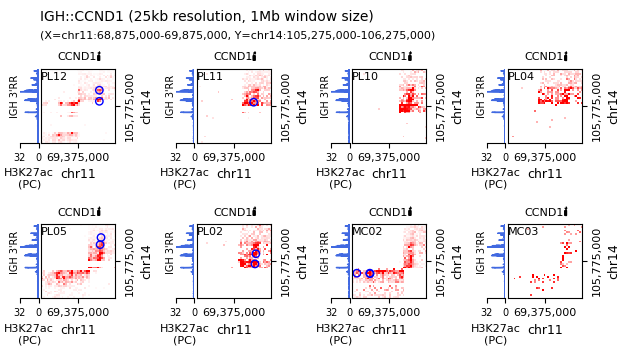

In [86]:
geneA = "IGHA2"
strandA = Strand.POS
geneB = "CCND1"
strandB = Strand.NEG
anchor_chr = "chr11"
anchor_pos = 69640000
highlight_id = ""
bigwig_file = "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"
bigwig_label = "PC"
assembly = Assembly([
    bin_align_segment(Segment("chr14", 104900000, 105900000), 25000),
    bin_align_segment(Segment("chr11", 69250000, 70250000), 25000),
])
enhancer_label="IGH 3'RR"
enhancer_label_loc = 105650000

exclude = []
ncols = 4
nrows = 2
resolution = 25000
title = "IGH::CCND1"

segmentA = assembly.segments[1]
segmentB = assembly.segments[0]

startA = segmentA.segment.start - 375000
endA = segmentA.segment.end - 375000
chrA = segmentA.segment.chr

startB = segmentB.segment.start + 375000
endB = segmentB.segment.end + 375000
chrB = segmentB.segment.chr
print(chrA, startA, endA, chrB, startB, endB)
assert endA - startA == endB - startB


fig = plot_supp_recurrent(geneA, strandA, geneB, strandB, bigwig_file, bigwig_label, chrA, startA, endA, chrB, startB, endB, exclude, ncols, nrows, resolution, title, enhancer_label, enhancer_label_loc)
fig.savefig(figure_path("supp2_recurrent_IGH_CCND1.svg"), bbox_inches="tight")

chr8 127175000 128175000 chr14 105150000 106150000


/tmp/ipykernel_335634/4109843753.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


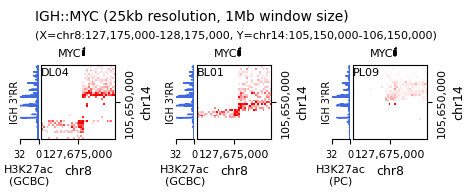

In [57]:
geneA = "IGHA2"
strandA = Strand.POS
geneB = "MYC"
strandB = Strand.NEG
anchor_chr = "chr8"
anchor_pos = 127735434
bigwig_file = "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw"
bigwig_label = "GCBC"
assembly = Assembly([
    bin_align_segment(Segment("chr14", 104750000, 105750000), 25000),
    bin_align_segment(Segment("chr8", 127375000, 128375000), 25000),
])
enhancer_label="IGH 3'RR"
enhancer_label_loc = 105650000

exclude = []
ncols = 3
nrows = 1
resolution = 25000
title = "IGH::MYC"

segmentA = assembly.segments[1]
segmentB = assembly.segments[0]

startA = segmentA.segment.start - 200000
endA = segmentA.segment.end - 200000
chrA = segmentA.segment.chr

startB = segmentB.segment.start + 400000
endB = segmentB.segment.end + 400000
chrB = segmentB.segment.chr
print(chrA, startA, endA, chrB, startB, endB)
assert endA - startA == endB - startB


fig = plot_supp_recurrent(geneA, strandA, geneB, strandB, bigwig_file, bigwig_label, chrA, startA, endA, chrB, startB, endB, exclude, ncols, nrows, resolution, title, enhancer_label, enhancer_label_loc, replace_pl=True)
fig.savefig(figure_path("supp2_recurrent_IGH_MYC.svg"), bbox_inches="tight")

# Virtual 4C Traces

In [89]:
def get_sample_by_short_id(samples: list[Sample], short_id: str) -> Sample:
    return [ s for s in samples if s.meta.id_paper == short_id][0]

def to_arima_sample(sample: Sample) -> ArimaPipelineSample: 
    return read_sample(sample.meta.id_file, sample.profile.hic, sample.profile.qc, None)

def sample_svs_with_gene(sample: Sample, gene: str):
    involving = []
    for sv in read_curated_calls(sample.profile.curated, threshold=1000000):
        if sv_involves_gene(sv, gene):
            involving.append(sv)
    return involving

def sv_to_region_radius(sv: CuratedCall, radius: int):
    regionA = Region(sv.chrA, sv.posA-radius, sv.posA+radius)
    regionB = Region(sv.chrB, sv.posB-radius, sv.posB+radius)
    return regionA, regionB

def get_virtual_data_for_segments(sample: Sample, anchor_chr, anchor_pos, intra_segment, inter_segment, resolution, radius, norm="NONE", measure="observed", uvp_norm=True,anchor_bin_radius=0):
    hic_file = read_hic(sample.profile.hic)
    anchor_pos_bin = bin_align_value(anchor_pos, resolution)
    anchor_start = anchor_pos_bin - (anchor_bin_radius * resolution)
    anchor_end = anchor_pos_bin + resolution + (anchor_bin_radius * resolution)
    
    intra_data = get_hic_for_segment_pair(
        hic_file,
        BinAlignedSegmentPair(
            segmentX = intra_segment.segment,
            segmentY = Segment(anchor_chr, anchor_start, anchor_end),
            resolution = resolution
        ),
        norm=norm,
        measure=measure,
    ).mean(axis=0)
    
    inter_data = get_hic_for_segment_pair(
        hic_file,
        BinAlignedSegmentPair(
            segmentX = inter_segment.segment,
            segmentY = Segment(anchor_chr, anchor_start, anchor_end),
            resolution = resolution
        ),
        norm=norm,
        measure=measure,
    ).mean(axis=0)   

    if inter_data.shape == (1,):
        inter_data = np.zeros((inter_segment.segment.end - inter_segment.segment.start) // resolution)
    
    # Invert if is minus strand
    if intra_segment.segment.is_minus_strand:
        intra_data = intra_data[::-1]
    if inter_segment.segment.is_minus_strand:
        inter_data = inter_data[::-1]

    # Normalize per million reads if uvp_norm
    if uvp_norm:
        intra_data = intra_data / (sample.uvp / 1e6)
        inter_data = inter_data / (sample.uvp / 1e6)
        
    return intra_data , inter_data 


In [90]:

def fig3_plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=1, norm=HIC_NORM, measure="observed", resolution=10000, radius=25*10000, uvp_norm=True, gene_filter=None,):

    intra_dataA, inter_dataA = get_virtual_data_for_segments(sampleA, anchor_chr, anchor_pos, intra_segment, inter_segment, resolution, radius, norm, measure, anchor_bin_radius=anchor_bin_radius, uvp_norm=uvp_norm)
    intra_dataB, inter_dataB = get_virtual_data_for_segments(sampleB, anchor_chr, anchor_pos, intra_segment, inter_segment, resolution, radius, norm, measure, anchor_bin_radius=anchor_bin_radius,uvp_norm=uvp_norm)
    
    tracks = [ 
        TrackSpec(track_type=TrackType.TRACK_BIGWIG, track_kwargs={ "bw_handle": bw, "color": BIGWIG_COLOUR, "ymax": GLOBAL_BW_MAX, "show_ylim": True }, ylabel=f"H3K27ac\n({bw_label})", rel_height=0.3),
        TrackSpec(track_type=TrackType.TRACK_GENES, track_kwargs={ "gene_filter": gene_filter, "max_rows": 1, "min_rows": 0, "fontsize": 10, "all_same_line": True }, ylabel="Genes", rel_height=0.15),
        TrackSpec(track_type=TrackType.TRACK_CHR_ARROWS, track_kwargs={"label_chr": True}, ylabel="Region", rel_height=0.2),
    ]
    
    height_ratios = [1] + [x.rel_height for x in tracks]
    
    fig, ax = plt.subplots(4, 2, figsize=(5, 2.8), sharey="row", height_ratios=height_ratios)
    fig.subplots_adjust(wspace=0, hspace=0.2)
    
    ax_line_intra = ax[0, 0]
    ax_line_inter = ax[0, 1]
    
    x_intra = np.arange(len(intra_dataA)) * resolution + intra_segment.segment.start + resolution / 2
    x_inter = np.arange(len(inter_dataA)) * resolution + inter_segment.segment.start + resolution / 2
    
    # Plot lines
    ax_line_intra.plot(x_intra, intra_dataA, color=CHROM_COLORS[intra_segment.segment.chr], lw=1.5, ls="solid")
    ax_line_inter.plot(x_inter, inter_dataA, color=CHROM_COLORS[inter_segment.segment.chr], lw=1.5, ls="solid")
    ax_line_intra.plot(x_intra, intra_dataB, color=CHROM_COLORS[intra_segment.segment.chr], lw=1.5, ls="dotted")
    ax_line_inter.plot(x_inter, inter_dataB, color=CHROM_COLORS[inter_segment.segment.chr], lw=1.5, ls="dotted")
    
    # Plot a connector
    if sample_asterisk == "A":
        ax_line_intra.plot([x_intra.max(), x_intra.max() + resolution], [intra_dataA[-1], inter_dataA[0]], color="gray", clip_on=False, lw=1.5)
        ax_line_inter.plot([x_inter.min()-resolution, x_inter.min()], [intra_dataA[-1], inter_dataA[0]], color="gray", clip_on=False, lw=1.5)
    elif sample_asterisk == "B":
        ax_line_intra.plot([x_intra.max(), x_intra.max() + resolution], [intra_dataB[-1], inter_dataB[0]], color="lightgray", clip_on=False, ls=":", lw=1.5)
        ax_line_inter.plot([x_inter.min()-resolution, x_inter.min()], [intra_dataB[-1], inter_dataB[0]], color="lightgray", clip_on=False, ls=":", lw=1.5)
    
    ax_line_intra.axvspan(anchor_pos-resolution/2, anchor_pos+resolution/2, color="yellow", alpha=0.25)
    ax_line_intra.set_xlim((intra_segment.segment.start, intra_segment.segment.end))
    ax_line_intra.set_ylabel(f"Sliding\nVirtual 4C\n({int_to_resolution(resolution + 2 * anchor_bin_radius * resolution)} window)")
    ax_line_inter.set_xlim((inter_segment.segment.start, inter_segment.segment.end))
    ax_line_intra.spines[["top", "right"]].set_visible(False)
    ax_line_inter.spines[["top", "right"]].set_visible(False)
    ax_line_inter.spines[["left"]].set_linewidth(0.1)
    ax_line_inter.tick_params("y", left=False)
    
    ax_line_intra.set_xticks([])
    ax_line_inter.set_xticks([])
    
    sampleA_adder = "*" if sample_asterisk == "A" else ""
    sampleB_adder = "*" if sample_asterisk == "B" else ""
    legend_handles = [
        Line2D([], [], color="gray", ls="solid", label=sampleA.meta.id_paper+sampleA_adder, lw=1.5), 
        Line2D([], [], color="gray", ls=":", label=sampleB.meta.id_paper+sampleB_adder, lw=1.5)
    ]
    ax_line_inter.legend(handles=legend_handles, loc="upper right", frameon=False)
    
    intra_region = PlotRegion((0, len(intra_dataA)), PlotRegionType.DATA_SEGMENT, matched_segment=intra_segment)
    inter_region = PlotRegion((0, len(inter_dataA)), PlotRegionType.DATA_SEGMENT, matched_segment=inter_segment)
    # Plot other tracks
    row_count = 1
    for i, track in enumerate(tracks):
        ax_left = ax[row_count+i,0]
        ax_right = ax[row_count+i,1]
        plot_track(ax_left, intra_region, track, is_first=True)
        plot_track(ax_right, inter_region, track, is_last=True)
        ax_right.set_ylabel("")
        ax_right.spines[["left"]].set_visible(True)
        ax_right.spines[["left"]].set_linewidth(0.1)
    
    ax[1, 0].set_ylim(0, GLOBAL_BW_MAX)
    ax[1, 0].set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=8)
    
    chr_text = ax[3,0].findobj(lambda artist: isinstance(artist, matplotlib.text.Text) and artist.get_text() == intra_segment.segment.chr)[0]
    chr_text.set_y(-2)
    
    chr_text = ax[3,1].findobj(lambda artist: isinstance(artist, matplotlib.text.Text) and artist.get_text() == inter_segment.segment.chr)[0]
    chr_text.set_y(-2)
    
    return fig

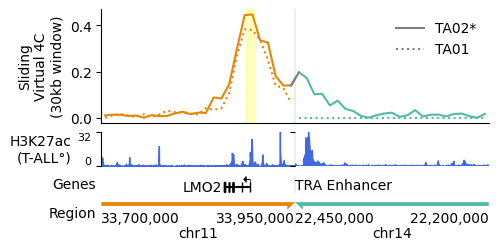

In [25]:
sampleA = get_sample_by_short_id(samples, "TA02")
sampleB = get_sample_by_short_id(samples, "TA01")

anchor_chr = "chr11"
anchor_pos = 33892076
anchor_bin_radius=1
norm = HIC_NORM
measure = "observed"
resolution = 10000
radius = 25 * resolution
uvp_norm=True
sample_asterisk = "A"
gene_filter=["LMO2", ]

svs = sample_svs_with_gene(sampleA, gene_filter[0])
assert len(svs) >0
sv = svs[0]

intra_segment = bin_align_segment(Segment(sv.chrA, sv.posA - radius, sv.posA), resolution)
inter_segment = bin_align_segment(Segment(sv.chrB, sv.posB-radius, sv.posB, True), resolution)

bw = pyBigWig.open("../annotations/H3K27ac/10_data-public_databases_blueprint_hg38bw_Tcell_Acute_Lymphocytic_Leukemia_S01S3FH1.ERX1347915.H3K27ac.bwa.GRCh38.bw")
bw_label="T-ALL°"

fig = fig3_plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=anchor_bin_radius, norm=norm, measure=measure, resolution=resolution, radius=radius, uvp_norm=uvp_norm, gene_filter=gene_filter)

ax_label = fig.axes[5]
ax_label.text(0, 0.45, "TRA Enhancer", transform=ax_label.transAxes, ha="left", va="center")
fig.savefig(figure_path(f"fig3_{sampleA.meta.id_paper}_{sampleB.meta.id_paper}_{sample_asterisk}.svg"), bbox_inches ="tight")

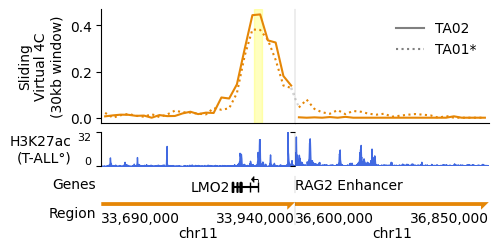

In [27]:
anchor_chr = "chr11"
anchor_pos = 33892076
anchor_bin_radius=1
norm = HIC_NORM
measure = "observed"
resolution = 10000
radius = 25 * resolution
uvp_norm=True
sample_asterisk = "B"
gene_filter=["LMO2", "RAG2"]

svs = sample_svs_with_gene(sampleB, gene_filter[0])
assert len(svs) >0
sv = svs[0]

intra_segment = bin_align_segment(Segment(sv.chrA, sv.posA - radius, sv.posA), resolution)
inter_segment = bin_align_segment(Segment(sv.chrB, sv.posB, sv.posB + radius, False), resolution)

bw = pyBigWig.open("../annotations/H3K27ac/10_data-public_databases_blueprint_hg38bw_Tcell_Acute_Lymphocytic_Leukemia_S01S3FH1.ERX1347915.H3K27ac.bwa.GRCh38.bw")
bw_label="T-ALL°"

fig = fig3_plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=anchor_bin_radius, norm=norm, measure=measure, resolution=resolution, radius=radius, uvp_norm=uvp_norm, gene_filter=gene_filter)

ax_label = fig.axes[5]
ax_label.text(0, 0.45, "RAG2 Enhancer", transform=ax_label.transAxes, ha="left", va="center")

fig.savefig(figure_path(f"fig3_{sampleA.meta.id_paper}_{sampleB.meta.id_paper}_{sample_asterisk}.svg"), bbox_inches ="tight")

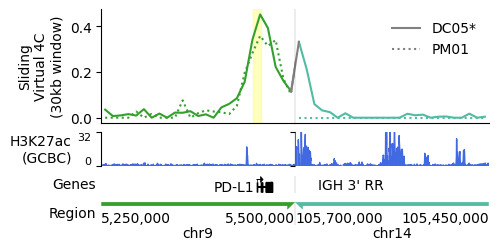

In [28]:
sampleA = get_sample_by_short_id(samples, "DC05")
sampleB = get_sample_by_short_id(samples, "PM01")

anchor_chr = "chr9"
anchor_pos = 5450503
norm = HIC_NORM
measure = "observed"
resolution = 10000
radius = 25 * resolution
gene_filter = ["CD274"]
uvp_norm = True
anchor_bin_radius=1
sample_asterisk="A"

svs = sample_svs_with_gene(sampleA, gene_filter[0])
assert len(svs) >0
sv = svs[0]

intra_segment = bin_align_segment(Segment(sv.chrA, sv.posA - radius, sv.posA), resolution)
inter_segment = bin_align_segment(Segment(sv.chrB, sv.posB-radius, sv.posB, True), resolution)

bw = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
bw_label="GCBC"


fig = fig3_plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=anchor_bin_radius, norm=norm, measure=measure, resolution=resolution, radius=radius, uvp_norm=uvp_norm, gene_filter=gene_filter)
ax_label = fig.axes[5]
ax_label.text(0.12, 0.45, "IGH 3' RR", transform=ax_label.transAxes, ha="left", va="center")


ax_gene = fig.axes[4]
gene_text = ax_gene.findobj(match=matplotlib.text.Text)[0]
gene_text.set_text("PD-L1")

fig.savefig(figure_path(f"fig3_{sampleA.meta.id_paper}_{sampleB.meta.id_paper}_{sample_asterisk}.svg"), bbox_inches ="tight")

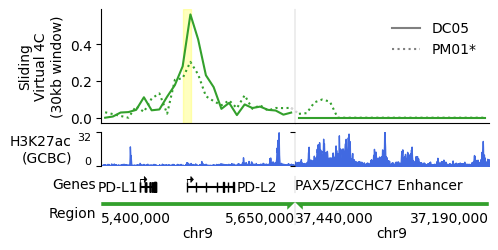

In [29]:

anchor_chr = "chr9"
anchor_pos = 5510531
norm = HIC_NORM
measure = "observed"
resolution = 10000
radius = 25 * resolution
gene_filter = ["PDCD1LG2", "CD274"]
uvp_norm = True
anchor_bin_radius=1
sample_asterisk="B"

svs = sample_svs_with_gene(sampleB, gene_filter[0])
assert len(svs) >0
sv = svs[0]

intra_segment = bin_align_segment(Segment(sv.chrA, sv.posA - radius, sv.posA), resolution)
inter_segment = bin_align_segment(Segment(sv.chrB, sv.posB-radius, sv.posB, True), resolution)

fig = fig3_plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=anchor_bin_radius, norm=norm, measure=measure, resolution=resolution, radius=radius, uvp_norm=uvp_norm, gene_filter=gene_filter)
ax_label = fig.axes[5]
ax_label.text(0, 0.45, "PAX5/ZCCHC7 Enhancer", transform=ax_label.transAxes, ha="left", va="center")


ax_gene = fig.axes[4]
gene_texts = ax_gene.findobj(match=matplotlib.text.Text)
gene_texts[1].set_x(5575000)
gene_texts[1].set_text("PD-L2")
gene_texts[1].set_ha("left")
gene_texts[0].set_text("PD-L1")
gene_texts[0].set_clip_on(False)

fig.savefig(figure_path(f"fig3_{sampleA.meta.id_paper}_{sampleB.meta.id_paper}_{sample_asterisk}.svg"), bbox_inches ="tight")

# BCL6 Locus

In [7]:
bcl6_rearranged = []
for sample in samples:
    bcl6_rearrangements = []
    for sv in read_curated_calls(sample.profile.curated):
        if sv.chrA != sv.chrB and (sv_involves_gene(sv, "BCL6") or sv_involves_gene(sv, "LPP")):
            bcl6_rearrangements.append(sv)
    bcl6_rearrangements = sorted(bcl6_rearrangements, key=lambda x: x.posA if x.chrA == "chr3" else x.posB)
    if len(bcl6_rearrangements) > 0:
        bcl6_rearranged.append((sample, bcl6_rearrangements))
bcl6_rearranged = sorted(bcl6_rearranged, key=lambda x: x[1][0].posA if x[1][0].chrA == "chr3" else x[1][0].posB)

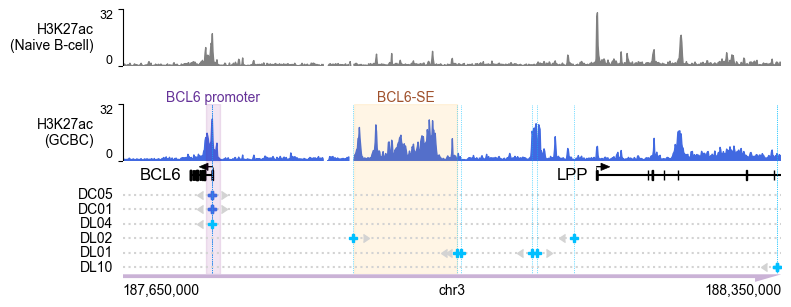

In [19]:
fig, ax = plt.subplots(5, 1, figsize=(8.5, 3.735), height_ratios=[1.5, 1, 1.5,3, 0.6])
fig.subplots_adjust(hspace=0)


bw = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
ax_start = 187650000
ax_end = 188350000
chrom = "chr3"

ax_bigwig_naive = ax[0]
ax_none = ax[1]
blank_axis(ax_none)
ax_bigwig = ax[2]
ax_gene = ax[3]
ax_region = ax[4]

####----
bw_naive = pyBigWig.open("../annotations/H3K27ac/01_naive_B_cell.H3K27ac.bw")
plot_bigwig_track(bw_naive, chrom, ax_start, ax_end, color="gray", ax=ax_bigwig_naive)
ax_bigwig_naive.set_ylim((0, GLOBAL_BW_MAX))
ax_bigwig_naive.yaxis.set_visible(True)
ax_bigwig_naive.spines[["left"]].set_visible(True)
ax_bigwig_naive.set_ylabel("H3K27ac\n(Naive B-cell)", rotation=0, ha="right", va="center", fontsize=10)
ax_bigwig_naive.yaxis.set_visible(True)
ax_bigwig_naive.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=9)
ax_bigwig_naive.get_yticklabels()[0].set_va("bottom")
ax_bigwig_naive.get_yticklabels()[-1].set_va("top")

####----

plot_bigwig_track(bw, chrom, ax_start, ax_end, color=BIGWIG_COLOUR, ax=ax_bigwig)
ax_bigwig.set_ylim((0, GLOBAL_BW_MAX))
ax_bigwig.yaxis.set_visible(True)
ax_bigwig.spines[["left"]].set_visible(True)
ax_bigwig.set_ylabel("H3K27ac\n(GCBC)", rotation=0, ha="right", va="center", fontsize=10)
ax_bigwig.yaxis.set_visible(True)
ax_bigwig.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=9)
ax_bigwig.get_yticklabels()[0].set_va("bottom")
ax_bigwig.get_yticklabels()[-1].set_va("top")

plot_gene_track(chrom, ax_start, ax_end, gene_filter=["BCL6", "LPP"], min_rows=0, fontsize=12, ax=ax_gene, arrowhead_width=0.3, arrow_length=5000, all_same_line=True)
ax_gene.set_ylim((-4.1, 0.6))

markers = ["P"] * 6
marker_y = -0.8
sample_markers = {}

legend_handles = []
for (sample, rearrangements), marker in zip(bcl6_rearranged, markers):
    # Get the breakpoint on chr3
    color = group_colors[sample.meta.group]
    ax_gene.axhline(marker_y, ls=":", color="lightgray")
    ax_gene.text(ax_start-1e4, marker_y, sample.meta.id_paper, ha="right", va="center", fontsize=10)
    for sv in rearrangements:
        if sv.chrA == chrom:
            pos = sv.posA
            strand = sv.strandA
        elif sv.chrB == chrom:
            pos = sv.posB
            strand = sv.strandB
        strand_m = 8 if strand == Strand.POS else 9
        strand_d = 10000
        strand_d = -strand_d if strand == Strand.POS else strand_d
        ax_gene.plot(pos + strand_d, marker_y, marker=strand_m, color="lightgray")
        ax_gene.plot(pos, marker_y, marker=marker, color=color)
        ax_gene.axvline(pos, lw=0.5, ls=":", color=color)
        ax_bigwig.axvline(pos, lw=0.5, ls=":", color=color)
    legend_handles.append(Line2D([], [], lw=0, marker=marker, color=color, label=sample.meta.id_paper))
    sample_markers[sample.meta.id_paper] = marker
    marker_y -= 0.6


plot_track(ax_region, PlotRegion((0,0), PlotRegionType.DATA_SEGMENT, matched_segment=BinAlignedSegment(Segment(chrom, ax_start, ax_end), 0)), 
           TrackSpec(TrackType.TRACK_CHR_ARROWS, {"label_chr": True}))

bcl6_prom_start = 187745725 - 7500
bcl6_prom_end = 187745725 + 7500
enhancer_start = 187745725 +150000
enhancer_end = 187745725 +260000
for ax in [ax_gene, ax_bigwig]:
    ax.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
    ax.axvspan(bcl6_prom_start,bcl6_prom_end, color="purple", alpha=0.1)

ax_bigwig.text((bcl6_prom_start+bcl6_prom_end)/2, GLOBAL_BW_MAX, "BCL6 promoter",  va="bottom", ha="center", color="rebeccapurple")
ax_bigwig.text((enhancer_start+enhancer_end)/2, GLOBAL_BW_MAX, "BCL6-SE",  va="bottom", ha="center", color="sienna")

fig.savefig(figure_path("fig4_summary_bcl6_breakpoints.svg"), bbox_inches="tight")

In [12]:
def plot_hic_centered_wrapper(sample: Sample, centerX: Position, centerY: Position, resolution: int, radius: int, norm=HIC_NORM, ax=None, crosshair: None | tuple[Position, Position] | str=None, decorate=False, **kwargs) -> tuple[plt.Axes, tuple[int, int], tuple[int, int]]:
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    arima_sample = read_sample(sample.meta.id_file, sample.profile.hic, sample.profile.qc, None)
    ax, xlim, ylim, _ = plot_hic_centered_matrix(arima_sample, centerX.chr, centerX.pos, centerY.chr, centerY.pos, ax=ax, resolution=resolution, radius=radius, normalization=norm, **kwargs)

    # Remove center xtick and ytick 
    ax.get_xticklabels()[1].set_visible(False)
    ax.get_yticklabels()[1].set_visible(False)
    ax.get_xticklabels()[0].set_fontsize(11)
    ax.get_yticklabels()[0].set_fontsize(11)
    ax.get_xticklabels()[1].set_fontsize(11)
    ax.get_yticklabels()[1].set_fontsize(11)
    ax.set_xlabel(ax.get_xlabel(), fontsize=11)
    ax.set_ylabel(ax.get_ylabel(), fontsize=11)

    if crosshair is not None:
        if crosshair == "center":
            ax.axvline(centerX.pos // resolution * resolution, color="gray", linestyle=":")
            ax.axhline(centerY.pos // resolution * resolution, color="gray", linestyle=":")
        elif isinstance(crosshair, tuple):
            posA, posB = crosshair
            ax.axvline(posA.pos // resolution * resolution, color="gray", linestyle=":")
            ax.axhline(posB.pos // resolution * resolution, color="gray", linestyle=":")

    if decorate is True:
        if sample.availability == "internal":
            extra = f" ({sample.group})"
        else:
            extra = ""
        ax.set_title(f"{sample.id_short}" + extra, loc="left", fontsize=12, x=0.1)
        ax.add_patch(Rectangle((0, 1.05), 0.06, 0.06, transform=ax.transAxes, color=COLOR_DICT[sample.group], clip_on=False))

    return ax, xlim, ylim

def plot_hic_centered_with_genes(
        sample_id: str, 
        chr_search: str, 
        pos_search: int, 
        resolution: int=25000, 
        radius: int=20*25000, 
        gene_filter: list[str] = None,
        figsize: tuple[int, int] = (2.5, 2.5),
        savefig=False,
        sv_index=0,
        all_same_line=False,
        show_arrows_top=True,
        show_arrows_left=True,
        **kwargs
):

    sample = [ s for s in samples if s.meta.id_file == sample_id ][0]
    svs = [ sv for sv in read_curated_calls(sample.profile.curated)
          if (sv.chrA == chr_search and sv.posA == pos_search) or \
             (sv.chrB == chr_search and sv.posB == pos_search) ]
    if len(svs) == 0:
        raise ValueError("No SVs found at specified position")
    sv = svs[sv_index]
    centerX, centerY = sv.to_positions()

    fig = plt.figure(figsize=figsize)
    gene_track_width_ratio = 0.125
    spec = fig.add_gridspec(2, 2, width_ratios=[gene_track_width_ratio, 1], height_ratios=[gene_track_width_ratio, 1], wspace=0.05, hspace=0.05)

    ax_center = fig.add_subplot(spec[1, 1])
    ax_gene_left_y = fig.add_subplot(spec[1, 0])
    ax_gene_top_x = fig.add_subplot(spec[0, 1])

    _, (xmin, xmax), (ymin, ymax) = plot_hic_centered_wrapper(sample, centerX, centerY, resolution, radius, crosshair=True, ax=ax_center, **kwargs)
    print(ax_center.get_ylim())

    # Reduce fontsize of x and y tick labels
    ax_center.tick_params(axis="both", labelsize=9)

    # Remove center tick 
    ax_center.xaxis.get_major_ticks()[1].set_visible(False)
    ax_center.yaxis.get_major_ticks()[1].set_visible(False)

    # Draw marker at SV and crosshairs
    ax_center.plot(centerX.pos, centerY.pos, marker="+", color=CROSS_COLOUR, markersize=20)
    ax_center.axvline(centerX.pos, color=CROSS_COLOUR, lw=1, linestyle=":")
    ax_center.axhline(centerY.pos, color=CROSS_COLOUR, lw=1, linestyle=":")

    plot_gene_track(centerX.chr, xmin, xmax, gene_filter=gene_filter, centered_names=False, max_rows=1, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=10, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line, show_arrows=show_arrows_top)
    plot_gene_track(centerY.chr, ymin, ymax, vertical=True, gene_filter=gene_filter, centered_names=False, protein_coding_only=False, ax=ax_gene_left_y, fontsize=10, max_rows=1, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line, show_arrows=show_arrows_left)

    # Add title with sample id (and colored box next to it with group color)
    group_color = group_colors[sample.meta.group]
    title = f"{sample.meta.id_paper} ({sample.meta.group})"

    label_marker = "■"
    
    fig.text(0.11, 0.998, label_marker, ha="left", va="top", fontsize=10, color=group_color, fontweight="bold")
    fig.text(0.22, 0.99, title, ha="left", va="top", fontsize=10, fontweight="bold")

    for ax in [ax_center, ax_gene_top_x]:
        ax.axvspan(bcl6_prom_start,bcl6_prom_end, color="purple", alpha=0.1)

    if savefig:
        fig.savefig(figure_path(f"fig2_hic_{sample_id}_{'-'.join(gene_filter)}.svg"), bbox_inches="tight")

    return fig, (xmin, xmax), (ymin, ymax)

In [13]:
def make_triangle_tracks(bigwig_filename: str, bigwig_label: str, gene_filter=None, all_same_line=False):
    return [
        TrackSpec(
            track_type=TrackType.TRACK_GENES,
            track_kwargs={
                "min_rows": 0,
                "max_rows": 1,
                "gene_filter": gene_filter,
                "all_same_line": all_same_line,
            },
            ylabel="Genes",
            rel_height=0.2
        ),
        TrackSpec(
            track_type=TrackType.TRACK_BIGWIG,
            track_kwargs={
                "bw_handle": pyBigWig.open(bigwig_filename),
                "color": BIGWIG_COLOUR,
                "ymax": GLOBAL_BW_MAX,
                "show_ylim": True
            },
            ylabel=bigwig_label,
            rel_height=0.3,
        ),
        TrackSpec(
            track_type=TrackType.TRACK_BED_DIRECTIONAL,
            track_kwargs={
                "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
                "color": CTCF_COLOUR,
            },
            ylabel="CTCF Motifs",
            rel_height=0.15,
        ),
        TrackSpec(
            track_type=TrackType.TRACK_CHR_ARROWS,
            track_kwargs={
                "label_chr": True
            },
            ylabel="Region",
            rel_height=0.2,
        )
    ]

def plot_extra_triangles(sample, chrA, approxA, chrB, approxB, width, resolution, gene_filter, tracks, bw_handle=None, swap_matrix=False, all_same_line=False, bw_label="", vmax=25, return_figs=False, swap_triangle=False):
    sample_id = sample.meta.id_file
    svs = read_curated_calls(sample.profile.curated)
    sv_found = []
    found = []
    for sv in svs:
        if sv.chrA == chrA and abs(sv.posA - approxA) < 2000000 and sv.chrB == chrB and abs(sv.posB - approxB) < 2000000:
            chrA = sv.chrA
            posA = sv.posA
            strandA = sv.strandA
            chrB = sv.chrB
            posB = sv.posB
            strandB = sv.strandB
            found.append((chrA, posA, strandA, chrB, posB, strandB))
            sv_found.append(sv)
        elif sv.chrB == chrA and abs(sv.posB - approxA) < 2000000 and sv.chrA == chrB and abs(sv.posA - approxB) < 2000000:
            chrA = sv.chrB
            posA = sv.posB
            strandA = sv.strandB
            chrB = sv.chrA
            posB = sv.posA
            strandB = sv.strandA
            found.append((chrA, posA, strandA, chrB, posB, strandB))
            sv_found.append(sv)
    
    assert(len(found) > 0)
    figs = []
    for i_found in range(len(found)):
        (chrA, posA, strandA, chrB, posB, strandB) = found[i_found]
        if swap_triangle:
            chrA, posA, strandA, chrB, posB, strandB = chrB, posB, strandB, chrA, posA, strandA
        if strandA == Strand.POS: 
            startA = posA - width 
            endA = posA
            is_minus_strand_A = False
        else:
            startA = posA
            endA = posA + width
            is_minus_strand_A = True
        if strandB == Strand.NEG: 
            startB = posB
            endB = posB + width
            is_minus_strand_B = False
        else:
            startB = posB - width
            endB = posB
            is_minus_strand_B = True
        
        segmentA = bin_align_segment(Segment(chrA, startA, endA, is_minus_strand=is_minus_strand_A), resolution)
        segmentB = bin_align_segment(Segment(chrB, startB, endB, is_minus_strand=is_minus_strand_B), resolution)
        
        assembly = Assembly([
            segmentA,
            segmentB,
        ])
        
        hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
        assembled = assemble_hic(hic_file, assembly, gap_size=1, norm=HIC_NORM)
        
        points_to_plot = []
        
        fig = plot_triangle_and_tracks(sample.meta.id_paper, assembled, tracks=tracks, size_base=1.3, vmax=vmax, plot_points=points_to_plot, plot_point_kwargs={"ec": LOOP_COLOUR, "ls": ":", "lw": 1.5})

        if all_same_line:
            ax_gene = fig.axes[3]
            texts = ax_gene.findobj(lambda x: isinstance(x, matplotlib.text.Text))
            arrows = ax_gene.findobj(lambda x: isinstance(x, matplotlib.patches.FancyArrow))
            lines = ax_gene.findobj(lambda x: isinstance(x, matplotlib.lines.Line2D))
            for obj in texts + arrows + lines:
                obj.set_visible(False)
            ymin, ymax = ax_gene.get_ylim()
        
        # Set bigwig limits the same
        fig.axes[4].set_ylim(0, GLOBAL_BW_MAX)
        fig.axes[6].set_ylim(0, GLOBAL_BW_MAX)
        

        if not return_figs:
            fig.savefig(figure_path(f"supp4_triangle_{sample.meta.id_paper}_{chrA}_{chrB}_{i_found}.svg"), bbox_inches="tight")
        figs.append(fig)

    if return_figs:
        return figs


(106060000.0, 105660000.0)
(106850000.0, 104850000.0)


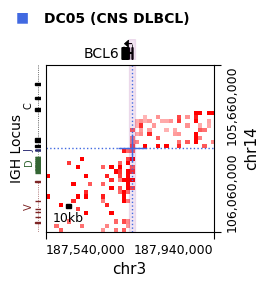

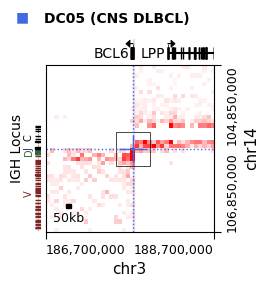

In [14]:
sample, rearrangements = bcl6_rearranged[0]
sample_id = sample.meta.id_file

resolution=10000
radius=20*resolution

sv = rearrangements[0]
chr_search = sv.chrA
pos_search = sv.posA
gene_filter = ["BCL6", "LPP"]
gene_filter += [name for name in GENE_ANNOTATIONS.gene_names_at_locus("14", 105100000, 106100000) if "IGH" in name]

fig, (box_xmin, box_xmax), (box_ymin, box_ymax) = plot_hic_centered_with_genes(
    sample_id, chr_search, pos_search, gene_filter=gene_filter, savefig=False, all_same_line=True,show_arrows_left=False, resolution=resolution, radius=radius,
)

ax_gene = fig.get_axes()[1]
ymax, ymin = ax_gene.get_ylim()
ax_gene.clear()
ax_gene.set_ylim((ymax, ymin))
ax_gene.set_xlim(5, 0)
ax_gene.text(4, (ymin+ymax)/2, "IGH Locus", rotation=90, fontsize=10, ha="right", va="center")
for letter, (rmin, rmax, rects) in igh_locus.items():
    mid = (max(rmin, ymin) + min(rmax, ymax)) / 2
    color = locus_colors[letter]
    ax_gene.vlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
    ax_gene.text(4, mid, letter, ha="left", va="center", rotation=90, fontsize=7, color=color)
    for (rectmin, rectmax) in rects:
        ax_gene.add_patch(Rectangle((0, rectmin), 1.5, rectmax-rectmin, fc=color, ec=color))

fig.savefig(figure_path(f"fig4_hic_{sample_id}_{'-'.join(['IGH', 'BCL6'])}.svg"), bbox_inches="tight")

# Extra bounds plot
outer_resolution = 50000
outer_radius = 20*outer_resolution
fig, _, _ = plot_hic_centered_with_genes(
    sample_id, chr_search, pos_search, gene_filter=gene_filter, savefig=False, all_same_line=True,show_arrows_left=False, resolution=outer_resolution, radius=outer_radius,
)
ax_hic = fig.get_axes()[0]
rect = Rectangle((box_xmin, box_ymin), box_xmax-box_xmin, box_ymax-box_ymin, ec="black", fc="none", lw=0.5)
ax_hic.add_patch(rect)

ax_gene = fig.get_axes()[1]
ymax, ymin = ax_gene.get_ylim()
ax_gene.clear()
ax_gene.set_ylim((ymax, ymin))
ax_gene.set_xlim(5, 0)
ax_gene.text(4, (ymin+ymax)/2, "IGH Locus", rotation=90, fontsize=10, ha="right", va="center")
for letter, (rmin, rmax, rects) in igh_locus.items():
    mid = (max(rmin, ymin) + min(rmax, ymax)) / 2
    color = locus_colors[letter]
    ax_gene.vlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
    ax_gene.text(4, mid, letter, ha="left", va="center", rotation=90, fontsize=7, color=color)
    for (rectmin, rectmax) in rects:
        ax_gene.add_patch(Rectangle((0, rectmin), 1.5, rectmax-rectmin, fc=color, ec=color))

fig.savefig(figure_path(f"supp4_hic_{sample_id}_{'-'.join(['IGH', 'BCL6'])}.svg"), bbox_inches="tight")


(23100000.0, 22700000.0)
(23900000.0, 21900000.0)


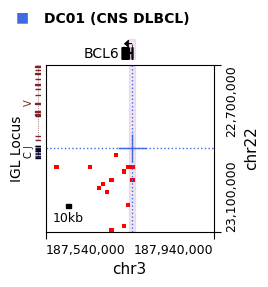

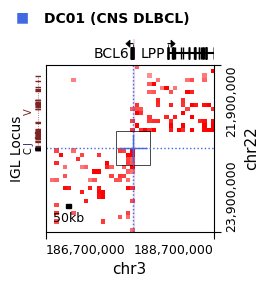

In [17]:
sample, rearrangements = bcl6_rearranged[1]
sample_id = sample.meta.id_file

resolution=10000
radius=20*resolution

sv = rearrangements[0]
chr_search = sv.chrA
pos_search = sv.posA
gene_filter = ["BCL6", "LPP"]
gene_filter += [name for name in GENE_ANNOTATIONS.gene_names_at_locus("22", 22700000, 23100000) if "IGL" in name]

fig, (box_xmin, box_xmax), (box_ymin, box_ymax) = plot_hic_centered_with_genes(
    sample_id, chr_search, pos_search, gene_filter=gene_filter, savefig=False, all_same_line=True,show_arrows_left=False, resolution=resolution, radius=radius,
)

ax_gene = fig.get_axes()[1]
ymax, ymin = ax_gene.get_ylim()
ax_gene.clear()
ax_gene.set_ylim((ymax, ymin))
ax_gene.set_xlim(5, 0)
ax_gene.text(4, (ymin+ymax)/2, "IGL Locus", rotation=90, fontsize=10, ha="right", va="center")
for letter, (rmin, rmax, rects) in igl_locus.items():
    mid = (max(rmin, ymin) + min(rmax, ymax)) / 2
    if letter == "J":
        mid -= 1e4
    elif letter == "C":
        mid += 5e3
    color = locus_colors[letter]
    ax_gene.vlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
    ax_gene.text(4, mid, letter, ha="left", va="center", rotation=90, fontsize=7, color=color)
    for (rectmin, rectmax) in rects:
        ax_gene.add_patch(Rectangle((0, rectmin), 1.5, rectmax-rectmin, fc=color, ec=color))

fig.savefig(figure_path(f"fig4_hic_{sample_id}_{'-'.join(['IGL', 'BCL6'])}.svg"), bbox_inches="tight")

# Outer box
outer_resolution = 50000
outer_radius = 20*outer_resolution
fig, _, _ = plot_hic_centered_with_genes(
    sample_id, chr_search, pos_search, gene_filter=gene_filter, savefig=False, all_same_line=True,show_arrows_left=False, resolution=outer_resolution, radius=outer_radius,
)
ax_hic = fig.get_axes()[0]
rect = Rectangle((box_xmin, box_ymin), box_xmax-box_xmin, box_ymax-box_ymin, ec="black", fc="none", lw=0.5)
ax_hic.add_patch(rect)

ax_gene = fig.get_axes()[1]
ymax, ymin = ax_gene.get_ylim()
ax_gene.clear()
ax_gene.set_ylim((ymax, ymin))
ax_gene.set_xlim(5, 0)
ax_gene.text(4, (ymin+ymax)/2, "IGL Locus", rotation=90, fontsize=10, ha="right", va="center")
for letter, (rmin, rmax, rects) in igl_locus.items():
    mid = (max(rmin, ymin) + min(rmax, ymax)) / 2
    if letter == "J":
        mid -= 5e4
    elif letter == "C":
        mid += 1e4
    color = locus_colors[letter]
    ax_gene.vlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
    ax_gene.text(4, mid, letter, ha="left", va="center", rotation=90, fontsize=7, color=color)
    for (rectmin, rectmax) in rects:
        ax_gene.add_patch(Rectangle((0, rectmin), 1.5, rectmax-rectmin, fc=color, ec=color))

fig.savefig(figure_path(f"supp4_hic_{sample_id}_{'-'.join(['IGL', 'BCL6'])}.svg"), bbox_inches="tight")

In [21]:
all_regulatory = pd.read_csv("../annotations/regulatory/ensembl_regulation_112_GRCh38_biomart_export.txt", sep="\t")
promoters_chr4 = all_regulatory[(all_regulatory["Feature type"] == "Promoter") & (all_regulatory["Chromosome/scaffold name"] == 4)]
jchain = GENE_ANNOTATIONS.genes_by_name("JCHAIN")[0]
promoters = promoters_chr4[(promoters_chr4["Start (bp)"] >= jchain.start) & (promoters_chr4["End (bp)"] <= jchain.end)]

/tmp/ipykernel_235698/2431414019.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  all_regulatory = pd.read_csv("../annotations/regulatory/ensembl_regulation_112_GRCh38_biomart_export.txt", sep="\t")


(70860000.0, 70460000.0)
(71650000.0, 69650000.0)


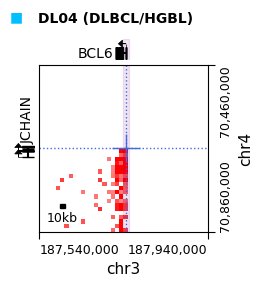

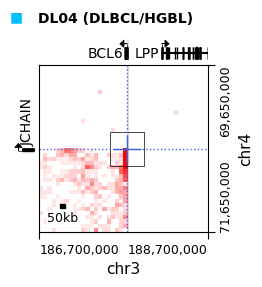

In [22]:
sample, rearrangements = bcl6_rearranged[2]
sample_id = sample.meta.id_file

resolution=10000
radius=20*resolution

sv = rearrangements[0]
chr_search = sv.chrA
pos_search = sv.posA
gene_filter = ["BCL6", "JCHAIN", "LPP"]
gene_filter += [name for name in GENE_ANNOTATIONS.gene_names_at_locus("22", 22700000, 23100000) if "IGL" in name]

fig, (box_xmin, box_xmax), (box_ymin, box_ymax) = plot_hic_centered_with_genes(
    sample_id, chr_search, pos_search, gene_filter=gene_filter, savefig=False, all_same_line=True,show_arrows_left=True, resolution=resolution, radius=radius,
)

ax_gene = fig.get_axes()[1]
arrow = ax_gene.findobj(match=matplotlib.patches.FancyArrow)[0]
extra_prom_arrow = copy.copy(arrow)
xmin, xmax = ax_gene.get_xlim()
for _, promoter in promoters.iterrows():
    pos = (promoter["Start (bp)"] + promoter["End (bp)"]) / 2
    extra_prom_arrow.set_xy([(x, y-jchain.end+pos) for x, y in arrow.get_xy()])
    ax_gene.add_patch(extra_prom_arrow)
    ax_gene.hlines(pos, arrow.get_xy()[0][0], 0, color="black")

fig.savefig(figure_path(f"fig4_hic_{sample_id}_{'-'.join(['JCHAIN', 'BCL6'])}.svg"), bbox_inches="tight")

outer_resolution = 50000
outer_radius = 20*outer_resolution
fig, _, _ = plot_hic_centered_with_genes(
    sample_id, chr_search, pos_search, gene_filter=gene_filter, savefig=False, all_same_line=True,show_arrows_left=True, resolution=outer_resolution, radius=outer_radius,
)
ax_hic = fig.get_axes()[0]
rect = Rectangle((box_xmin, box_ymin), box_xmax-box_xmin, box_ymax-box_ymin, ec="black", fc="none", lw=0.5)
ax_hic.add_patch(rect)

fig.savefig(figure_path(f"supp4_hic_{sample_id}_{'-'.join(['JCHAIN', 'BCL6'])}.svg"), bbox_inches="tight")

In [24]:
def plot_hic_region_with_curated(sample: Sample, regionX: Region, regionY: Region, resolution: int, norm=HIC_NORM, ax=None, crosshairs=True, **kwargs) -> tuple[plt.Axes, tuple[int, int], tuple[int, int]]:
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    breakfinder = curated_calls_to_breakfinder_calls(read_curated_calls(sample.profile.curated))
    arima_sample = replace(read_sample(sample.meta.id_file, sample.profile.hic, sample.profile.qc, None), breakfinder_calls=breakfinder)
    ax, xlim, ylim, _ = plot_hic_region_matrix(arima_sample, regionX, regionY, resolution=resolution, ax=ax, show_breakfinder_calls=True, breakfinder_color=CROSS_COLOUR, normalization=norm, crosshairs=crosshairs, **kwargs)

    # Remove center xtick and ytick 
    ax.get_xticklabels()[1].set_visible(False)
    ax.get_yticklabels()[1].set_visible(False)
    ax.get_xticklabels()[0].set_fontsize(11)
    ax.get_yticklabels()[0].set_fontsize(11)
    ax.get_xticklabels()[1].set_fontsize(11)
    ax.get_yticklabels()[1].set_fontsize(11)
    ax.set_xlabel(ax.get_xlabel(), fontsize=11)
    ax.set_ylabel(ax.get_ylabel(), fontsize=11)

    return ax, xlim, ylim

def plot_hic_region_with_genes_and_bigwig(
        sample: Sample,
        regionX: Region,
        regionY: Region,
        resolution: int=25000, 
        gene_filter: list[str] = None,
        figsize: tuple[int, int] = (3, 3),
        savefig=False,
        sv_index=0,
        show_arrows_top=True,
        show_arrows_left=True,
        bw_handle=None,
        bw_label="",
        all_same_line=False,
        **kwargs
):

    fig = plt.figure(figsize=figsize)
    gene_track_width_ratio = 0.125
    spec = fig.add_gridspec(3, 3, width_ratios=[gene_track_width_ratio, gene_track_width_ratio, 1], height_ratios=[gene_track_width_ratio, gene_track_width_ratio, 1], wspace=0.02, hspace=0.02)

    ax_center = fig.add_subplot(spec[2, 2])
    ax_gene_left_y = fig.add_subplot(spec[2, 0])
    ax_gene_top_x = fig.add_subplot(spec[0, 2])
    ax_bigwig_left_y = fig.add_subplot(spec[2, 1])
    ax_bigwig_top_x = fig.add_subplot(spec[1, 2])

    _, (xmin, xmax), (ymin, ymax) = plot_hic_region_with_curated(sample, regionX, regionY, resolution, crosshairs=True, ax=ax_center, **kwargs)
    print(ax_center.get_ylim())

    # Reduce fontsize of x and y tick labels
    ax_center.tick_params(axis="both", labelsize=9)

    # Remove center tick 
    ax_center.xaxis.get_major_ticks()[1].set_visible(False)
    ax_center.yaxis.get_major_ticks()[1].set_visible(False)

    plot_gene_track(regionX.chr, xmin, xmax, gene_filter=gene_filter, centered_names=False, max_rows=1, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=10, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line, show_arrows=show_arrows_top)
    plot_gene_track(regionY.chr, ymin, ymax, vertical=True, gene_filter=gene_filter, centered_names=False, protein_coding_only=False, ax=ax_gene_left_y, fontsize=10, max_rows=1, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line, show_arrows=show_arrows_left)

    plot_bigwig_track(bw_handle, regionX.chr, xmin, xmax, ax=ax_bigwig_top_x, color=BIGWIG_COLOUR, label=bw_label) 
    plot_bigwig_track(bw_handle, regionY.chr, ymin, ymax, vertical=True, ax=ax_bigwig_left_y, color=BIGWIG_COLOUR, label=bw_label)
    ax_bigwig_top_x.set_ylim((0, GLOBAL_BW_MAX))
    ax_bigwig_top_x.yaxis.set_visible(True)
    ax_bigwig_top_x.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=8)
    ax_bigwig_top_x.yaxis.tick_right()
    ax_bigwig_top_x.spines[["right"]].set_visible(True)
    ax_bigwig_top_x.get_yticklabels()[0].set_va("bottom")
    ax_bigwig_top_x.get_yticklabels()[-1].set_va("top")
    ax_bigwig_left_y.set_xlim((GLOBAL_BW_MAX, 0))
    ax_bigwig_left_y.xaxis.set_visible(True)
    ax_bigwig_left_y.set_xticks([GLOBAL_BW_MAX, 0], [ GLOBAL_BW_MAX, 0], fontsize=8)
    ax_bigwig_left_y.xaxis.tick_bottom()
    ax_bigwig_left_y.spines[["bottom"]].set_visible(True)
    ax_bigwig_left_y.get_xticklabels()[0].set_ha("left")
    ax_bigwig_left_y.get_xticklabels()[-1].set_ha("right")
    
    # Add title with sample id (and colored box next to it with group color)
    label_marker = "■"

    group_color = group_colors[sample.meta.group]
    title = f"{sample.meta.id_paper} ({sample.meta.group})"
    fig.text(0.11, 0.998, label_marker, ha="left", va="top", fontsize=10, color=group_color, fontweight="bold")
    fig.text(0.22, 0.99, title, ha="left", va="top", fontsize=10, fontweight="bold")

    if savefig:
        fig.savefig(figure_path(f"fig4_large_hic_{sample.meta.id_paper}_{'-'.join(gene_filter[:2])}.svg"), bbox_inches="tight")

    return fig, (xmin, xmax), (ymin, ymax)

(128800000.0, 126800000.0)


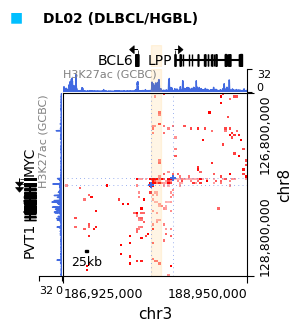

In [25]:
sample, svs = bcl6_rearranged[3]

resolution=25000
centerX = 187930000
widthX = 40*resolution
regionX = Region("chr3", centerX-widthX, centerX+widthX)
centerY = 127800000
widthY = 40*resolution
regionY = Region("chr8", centerY-widthY, centerY+widthY)
gene_filter = ["MYC", "PVT1", "BCL6", "LPP"]
all_same_line=True

bw_handle = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
bw_label = "H3K27ac (GCBC)"

fig, (xmin, xmax), (ymin, ymax) = plot_hic_region_with_genes_and_bigwig(sample, regionX, regionY, resolution, gene_filter=gene_filter, all_same_line=all_same_line, savefig=True, bw_label=bw_label, bw_handle=bw_handle)

ax_hic = fig.axes[0]
lines = ax_hic.findobj(Line2D)
for line in lines:
    line.set_markersize(5)
    if line.get_linewidth() > 0:
        line.set_linewidth(0.5)
ax_genes = fig.axes[1]
texts = ax_genes.findobj(match=matplotlib.text.Text)
texts[1].set_y(ymax-2e5)
texts[1].set_clip_on(False)

for ax in [ax_hic, fig.axes[2], fig.axes[4]]:
    ax.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
    
fig.savefig(figure_path(f"fig4_large_hic_{sample.meta.id_paper}_{'-'.join(gene_filter[:2])}.svg"), bbox_inches="tight")

(128800000.0, 126800000.0)


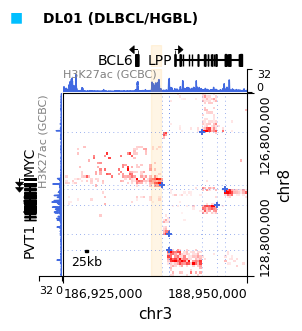

In [26]:
sample, svs = bcl6_rearranged[4]

gene_filter = ["MYC", "PVT1", "BCL6", "LPP"]
all_same_line=True

fig, (xmin, xmax), (ymin, ymax) = plot_hic_region_with_genes_and_bigwig(sample, regionX, regionY, resolution, gene_filter=gene_filter, all_same_line=all_same_line, savefig=True, bw_label=bw_label, bw_handle=bw_handle)

ax_hic = fig.axes[0]
lines = ax_hic.findobj(Line2D)
for line in lines:
    line.set_markersize(5)
    if line.get_linewidth() > 0:
        line.set_linewidth(0.5)
ax_genes = fig.axes[1]
texts = ax_genes.findobj(match=matplotlib.text.Text)
texts[1].set_y(ymax-2e5)
texts[1].set_clip_on(False)

for ax in [ax_hic, fig.axes[2], fig.axes[4]]:
    ax.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
    
fig.savefig(figure_path(f"fig4_large_hic_{sample.meta.id_paper}_{'-'.join(gene_filter[:2])}.svg"), bbox_inches="tight")

(61525000.0, 59525000.0)


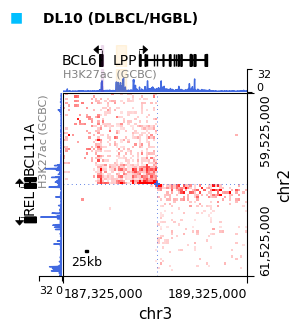

In [27]:
sample, svs = bcl6_rearranged[5]

gene_filter = ["MYC", "PVT1", "BCL6", "BCL11A", "LPP", "REL", "XPO"]
all_same_line=True

resolution=25000
centerX = 188325000
widthX = 40*resolution
regionX = Region("chr3", centerX-widthX, centerX+widthX)
centerY = 60525000
widthY = 40*resolution
regionY = Region("chr2", centerY-widthY, centerY+widthY)
all_same_line=True

fig, (xmin, xmax), (ymin, ymax) = plot_hic_region_with_genes_and_bigwig(sample, regionX, regionY, resolution, gene_filter=gene_filter, all_same_line=all_same_line, savefig=True, bw_label=bw_label, bw_handle=bw_handle)

ax_hic = fig.axes[0]
lines = ax_hic.findobj(Line2D)
for line in lines:
    line.set_markersize(5)
    if line.get_linewidth() > 0:
        line.set_linewidth(0.5)

for ax in [fig.axes[2], fig.axes[4]]:
    ax.axvspan(bcl6_prom_start, bcl6_prom_end, color="purple", alpha=0.1)
    ax.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
    
fig.savefig(figure_path(f"fig4_large_hic_{sample.meta.id_paper}_{'-'.join(gene_filter[:2])}.svg"), bbox_inches="tight")

### Virtual 4C for BCL6::MYC

In [28]:
def get_sample_by_short_id(samples: list[Sample], short_id: str) -> Sample:
    return [ s for s in samples if s.meta.id_paper == short_id][0]

def to_arima_sample(sample: Sample) -> ArimaPipelineSample: 
    return read_sample(sample.meta.id_file, sample.profile.hic, sample.profile.qc, None)

def sample_svs_with_gene(sample: Sample, gene: str):
    involving = []
    for sv in read_curated_calls(sample.profile.curated, threshold=1000000):
        if sv_involves_gene(sv, gene):
            involving.append(sv)
    return involving

def sv_to_region_radius(sv: CuratedCall, radius: int):
    regionA = Region(sv.chrA, sv.posA-radius, sv.posA+radius)
    regionB = Region(sv.chrB, sv.posB-radius, sv.posB+radius)
    return regionA, regionB

def get_virtual_data_for_segments(sample: Sample, anchor_chr, anchor_pos, intra_segment, inter_segment, resolution, radius, norm="NONE", measure="observed", uvp_norm=True,anchor_bin_radius=0):
    hic_file = read_hic(sample.profile.hic)
    anchor_pos_bin = bin_align_value(anchor_pos, resolution)
    anchor_start = anchor_pos_bin - (anchor_bin_radius * resolution)
    anchor_end = anchor_pos_bin + resolution + (anchor_bin_radius * resolution)
    
    intra_data = get_hic_for_segment_pair(
        hic_file,
        BinAlignedSegmentPair(
            segmentX = intra_segment.segment,
            segmentY = Segment(anchor_chr, anchor_start, anchor_end),
            resolution = resolution
        ),
        norm=norm,
        measure=measure,
    ).mean(axis=0)
    
    inter_data = get_hic_for_segment_pair(
        hic_file,
        BinAlignedSegmentPair(
            segmentX = inter_segment.segment,
            segmentY = Segment(anchor_chr, anchor_start, anchor_end),
            resolution = resolution
        ),
        norm=norm,
        measure=measure,
    ).mean(axis=0)   

    if inter_data.shape == (1,):
        inter_data = np.zeros((inter_segment.segment.end - inter_segment.segment.start) // resolution)
    
    # Invert if is minus strand
    if intra_segment.segment.is_minus_strand:
        intra_data = intra_data[::-1]
    if inter_segment.segment.is_minus_strand:
        inter_data = inter_data[::-1]

    # Normalize per million reads if no other norm
    if uvp_norm:
        intra_data = intra_data / (sample.uvp / 1e6)
        inter_data = inter_data / (sample.uvp / 1e6)
        
    return intra_data , inter_data 

def plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=1, norm=HIC_NORM, measure="observed", resolution=10000, radius=25*10000, uvp_norm=True, gene_filter=None,):

    intra_dataA, inter_dataA = get_virtual_data_for_segments(sampleA, anchor_chr, anchor_pos, intra_segment, inter_segment, resolution, radius, norm, measure, anchor_bin_radius=anchor_bin_radius, uvp_norm=uvp_norm)
    intra_dataB, inter_dataB = get_virtual_data_for_segments(sampleB, anchor_chr, anchor_pos, intra_segment, inter_segment, resolution, radius, norm, measure, anchor_bin_radius=anchor_bin_radius,uvp_norm=uvp_norm)
    
    tracks = [ 
        TrackSpec(track_type=TrackType.TRACK_BIGWIG, track_kwargs={ "bw_handle": bw, "color": BIGWIG_COLOUR, "ymax": GLOBAL_BW_MAX, "show_ylim": True }, ylabel=f"H3K27ac\n({bw_label})", rel_height=0.3),
        TrackSpec(track_type=TrackType.TRACK_GENES, track_kwargs={ "gene_filter": gene_filter, "max_rows": 1, "min_rows": 0, "fontsize": 10, "all_same_line": True}, ylabel="Genes", rel_height=0.15),
        TrackSpec(track_type=TrackType.TRACK_CHR_ARROWS, track_kwargs={"label_chr": True}, ylabel="Region", rel_height=0.2),
    ]
    
    height_ratios = [1] + [x.rel_height for x in tracks]
    
    fig, ax = plt.subplots(4, 2, figsize=(6.5, 2.8), sharey="row", height_ratios=height_ratios)
    fig.subplots_adjust(wspace=0, hspace=0.2)
    
    ax_line_intra = ax[0, 0]
    ax_line_inter = ax[0, 1]

    x_intra = np.arange(len(intra_dataA)) * resolution + intra_segment.segment.start + resolution / 2
    x_inter = np.arange(len(inter_dataA)) * resolution + inter_segment.segment.start + resolution / 2
    if intra_segment.segment.is_minus_strand:
        x_intra = x_intra[::-1]
    if inter_segment.segment.is_minus_strand:
        x_inter = x_inter[::-1]
    
    # Plot lines
    ax_line_intra.plot(x_intra, intra_dataA, color=CHROM_COLORS[intra_segment.segment.chr], lw=1.5, ls="solid")
    ax_line_inter.plot(x_inter, inter_dataA, color=CHROM_COLORS[inter_segment.segment.chr], lw=1.5, ls="solid")
    ax_line_intra.plot(x_intra, intra_dataB, color=CHROM_COLORS[intra_segment.segment.chr], lw=1.5, ls="dotted")
    ax_line_inter.plot(x_inter, inter_dataB, color=CHROM_COLORS[inter_segment.segment.chr], lw=1.5, ls="dotted")
    
    # Plot a connector
    if sample_asterisk == "A":
        if intra_segment.segment.is_minus_strand:
            ax_line_intra.plot([x_intra.min(), x_intra.min() - resolution], [intra_dataA[-1], inter_dataA[0]], color="lightgray", clip_on=False, lw=1)
        else:
            ax_line_intra.plot([x_intra.max(), x_intra.max() + resolution], [intra_dataA[-1], inter_dataA[0]], color="lightgray", clip_on=False, lw=1)
        if inter_segment.segment.is_minus_strand:
            ax_line_inter.plot([x_inter.max()+resolution, x_inter.max()], [intra_dataA[-1], inter_dataA[0]], color="lightgray", clip_on=False, lw=1)
        else:
            ax_line_inter.plot([x_inter.min()-resolution, x_inter.min()], [intra_dataA[-1], inter_dataA[0]], color="lightgray", clip_on=False, lw=1)
    elif sample_asterisk == "B":
        ax_line_intra.plot([x_intra.max(), x_intra.max() + resolution], [intra_dataB[-1], inter_dataB[0]], color="lightgray", clip_on=False, ls=":", lw=1)
        ax_line_inter.plot([x_inter.min()-resolution, x_inter.min()], [intra_dataB[-1], inter_dataB[0]], color="lightgray", clip_on=False, ls=":", lw=1)
    
    ax_line_intra.axvspan(anchor_pos-resolution/2, anchor_pos+resolution/2, color="yellow", alpha=0.25)
    
    if intra_segment.segment.is_minus_strand:
        ax_line_intra.set_xlim((intra_segment.segment.end, intra_segment.segment.start))
    else:
        ax_line_intra.set_xlim((intra_segment.segment.start, intra_segment.segment.end))
    if inter_segment.segment.is_minus_strand:
        ax_line_inter.set_xlim((inter_segment.segment.end, inter_segment.segment.start))
    else:
        ax_line_inter.set_xlim((inter_segment.segment.start, inter_segment.segment.end))
        
    print(ax_line_intra.get_xlim())
    ax_line_intra.set_ylabel(f"Sliding\nVirtual 4C\n({int_to_resolution(resolution + 2 * anchor_bin_radius * resolution)} window)")
    ax_line_intra.spines[["top", "right"]].set_visible(False)
    ax_line_inter.spines[["top", "right"]].set_visible(False)
    ax_line_inter.spines[["left"]].set_linewidth(0.1)
    ax_line_inter.tick_params("y", left=False)
    
    ax_line_intra.set_xticks([])
    ax_line_inter.set_xticks([])
    
    sampleA_adder = "" if sample_asterisk == "A" else ""
    sampleB_adder = "" if sample_asterisk == "B" else ""
    legend_handles = [
        Line2D([], [], color="gray", ls="solid", label=sampleA.meta.id_paper+sampleA_adder, lw=1), 
        Line2D([], [], color="gray", ls=":", label=sampleB.meta.id_paper.replace("*","")+sampleB_adder, lw=1)
    ]
    ax_line_inter.legend(handles=legend_handles, loc="upper right", frameon=False)
    
    intra_region = PlotRegion((0, len(intra_dataA)), PlotRegionType.DATA_SEGMENT, matched_segment=intra_segment)
    inter_region = PlotRegion((0, len(inter_dataA)), PlotRegionType.DATA_SEGMENT, matched_segment=inter_segment)
    # Plot other tracks
    row_count = 1
    for i, track in enumerate(tracks):
        ax_left = ax[row_count+i,0]
        ax_right = ax[row_count+i,1]
        plot_track(ax_left, intra_region, track, is_first=True)
        plot_track(ax_right, inter_region, track, is_last=True)
        ax_right.set_ylabel("")
        ax_right.spines[["left"]].set_visible(True)
        ax_right.spines[["left"]].set_linewidth(0.1)
    
    ax[1, 0].set_ylim(0, GLOBAL_BW_MAX)
    ax[1, 0].set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=8)
    ax[1,0].axvspan(anchor_pos-resolution/2, anchor_pos+resolution/2, color="yellow", alpha=0.25)
    ax[2,0].axvspan(anchor_pos-resolution/2, anchor_pos+resolution/2, color="yellow", alpha=0.25)

    
    chr_text = ax[3,0].findobj(lambda artist: isinstance(artist, matplotlib.text.Text) and artist.get_text() == intra_segment.segment.chr)[0]
    chr_text.set_y(-2)
    
    chr_text = ax[3,1].findobj(lambda artist: isinstance(artist, matplotlib.text.Text) and artist.get_text() == inter_segment.segment.chr)[0]
    chr_text.set_y(-2)
    
    return fig

chr3:187895000-187895000 (chr3:187895000) - chr8:127810000-127810000 (chr8:127810000)
(127210000.0, 127810000.0)


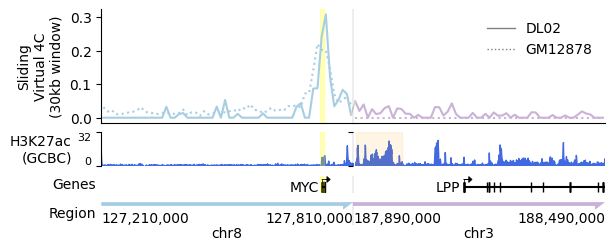

In [29]:
sampleA = get_sample_by_short_id(samples, "DL02")
sampleB = get_sample_by_short_id(samples_all_merge, "*GM12878")

anchor_chr = "chr8"
anchor_pos = 127735434
anchor_bin_radius=1
norm = HIC_NORM
measure = "observed"
resolution = 10000
radius = 60 * resolution
uvp_norm=True
sample_asterisk = "A"
gene_filter=["MYC", "BCL6", "LPP",]

svs = sample_svs_with_gene(sampleA, gene_filter[0])
assert len(svs) >0
sv = svs[1]
print(sv)

intra_segment = bin_align_segment(Segment(sv.chrB, sv.posB-radius, sv.posB, False), resolution)
inter_segment = bin_align_segment(Segment(sv.chrA, sv.posA, sv.posA+radius, False), resolution)

bw = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
bw_label="GCBC"

fig = plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=anchor_bin_radius, norm=norm, measure=measure, resolution=resolution, radius=radius, uvp_norm=uvp_norm, gene_filter=gene_filter)

ax_genes=fig.axes[4]


ax_enhancer = fig.axes[3]
ax_enhancer.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
fig.savefig(figure_path(f"fig4_{sampleA.meta.id_paper}_{sampleB.meta.id_paper}_{sample_asterisk}_2.svg"), bbox_inches ="tight")

chr3:188010000-188010000 (chr3:188010000) - chr8:127805000-127805000 (chr8:127805000)
(127200000.0, 127800000.0)


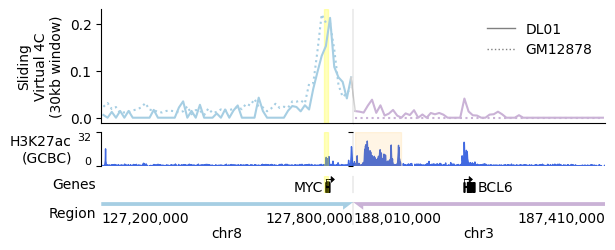

In [34]:
sampleA = get_sample_by_short_id(samples, "DL01")
sampleB = get_sample_by_short_id(samples_all_merge, "*GM12878")

anchor_chr = "chr8"
anchor_pos = 127735434
anchor_bin_radius=1
norm = HIC_NORM
measure = "observed"
resolution = 10000
radius = 60 * resolution
uvp_norm=True
sample_asterisk = "A"
gene_filter=["MYC", "BCL6", "LPP", ]

svs = sample_svs_with_gene(sampleA, gene_filter[0])
assert len(svs) >0
sv = svs[4]
print(sv)

intra_segment = bin_align_segment(Segment(sv.chrB, sv.posB-radius, sv.posB, False), resolution)
inter_segment = bin_align_segment(Segment(sv.chrA, sv.posA-radius, sv.posA, True), resolution)

bw = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
bw_label="GCBC"

fig = plot_virtual_comparison(sampleA, sampleB, sample_asterisk, anchor_chr, anchor_pos, intra_segment, inter_segment, bw, bw_label, anchor_bin_radius=anchor_bin_radius, norm=norm, measure=measure, resolution=resolution, radius=radius, uvp_norm=uvp_norm, gene_filter=gene_filter)

ax_genes=fig.axes[4]

text.set_clip_on(False)
ax_genes_right=fig.axes[5]
ax_genes_right.set_fc("none")

ax_enhancer = fig.axes[3]
ax_enhancer.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
fig.savefig(figure_path(f"fig4_{sampleA.meta.id_paper}_{sampleB.meta.id_paper}_{sample_asterisk}.svg"), bbox_inches ="tight")

# Circos

In [9]:
from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset
from collections import defaultdict

In [10]:
all_myc_rearranged = []
for sample in samples:
    myc_rearrangements = []
    seen_chr = set()
    for sv in read_curated_calls(sample.profile.curated):
        if sv_involves_gene(sv, "MYC") and sv.chrA != sv.chrB and ((sv.chrA not in seen_chr) and (sv.chrB not in seen_chr))  :
            myc_rearrangements.append(sv)
            seen_chr.add(sv.chrA if sv.chrB == "chr8" else sv.chrB)
    if len(myc_rearrangements) > 0:
        all_myc_rearranged.append((sample, myc_rearrangements))

In [37]:
partners = []
for sample, svs in all_myc_rearranged:
    for sv in svs:
        if sv.chrA == "chr8":
            partners.append((sv.chrB, sv.posB, sv.strandB, sv.chrA, sv.posA, sv.strandA, sample.meta.group,))
        elif sv.chrB == "chr8":
            partners.append((sv.chrA, sv.posA, sv.strandA, sv.chrB, sv.posB, sv.strandB, sample.meta.group))
partners.append(("chr8", 128025000, None, None, None, None, None))
partners.sort(key=lambda x: CHROM_INDICES[x[0]])

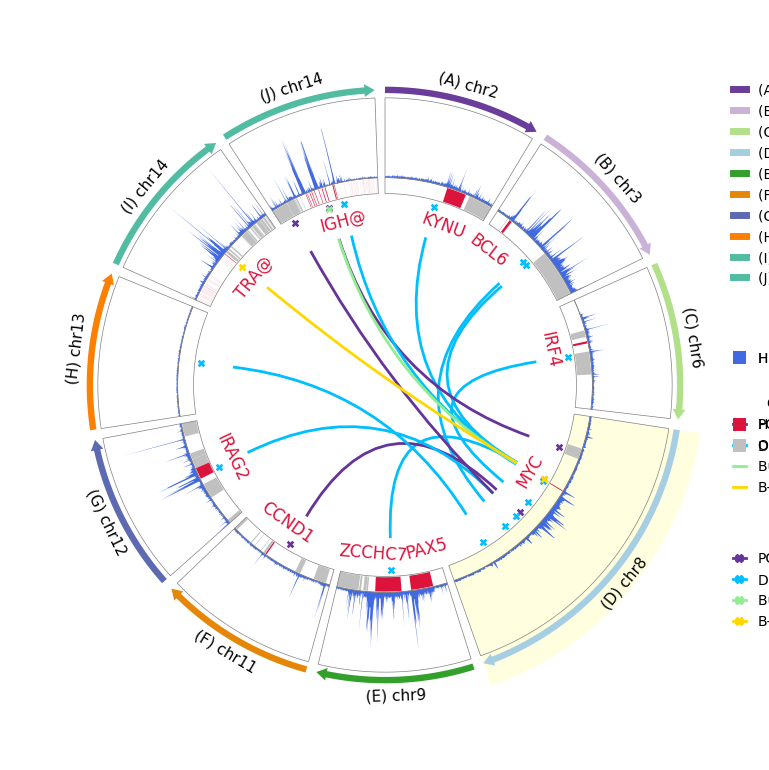

In [120]:
sectors = []
seen_chr = set()
for partner in partners:
    if partner[0] in seen_chr:
        continue
    sectors.append((partner[0], partner[1]))
    seen_chr.add(partner[0])
    
# Extra  for chr14 additional locus
sectors.append(("chr14_2", 22560000))
sectors[-2], sectors[-1] = sectors[-1], sectors[-2]

width = 500000
num_bins_bw = 420

gene_names = ["MYC", "KYNU", "BCL6", "PAX5", "ZCCHC7", "CCND1", "IRAG2", "IGHM", "IRF4", "TRAC"]
    
sector_starts = { sector[0]: max(0, sector[1] - width) for sector in sectors }
sector_starts["chr8"] = sector_starts["chr8"] - width
sector_ends = { sector[0]: max(0, min(sector[1] + width, CHROM_SIZES[sector[0].replace("_2","")])) for sector in sectors }
sector_ends["chr8"] = sector_ends["chr8"] + width
sector_dict = { sector[0]: sector_ends[sector[0]] - sector_starts[sector[0]]  for sector in sectors }
partner_dict = defaultdict(list)
partner_counts = defaultdict(int)
for (chr_partner, locus_partner, strand_partner, _, myc_pos, strand_myc, group) in partners:
    if chr_partner == "chr14" and locus_partner < 105000000:
        chr_partner = "chr14_2"
    partner_dict[chr_partner].append((myc_pos, strand_myc, locus_partner, strand_partner, group))
    partner_counts[chr_partner] += 1

circos = Circos(sector_dict, space=2)
bw = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
bw_label = "GCBC"
if "chr8" in bw.chroms().keys():
    prefix_chr = True

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
i_sector = 0
sector_labels = []
for sector in circos.sectors:
    chrom = sector.name.replace("_2","")
    start = sector_starts[sector.name]
    end = sector_ends[sector.name]
    sector_label = alphabet[i_sector]
    
    if chrom == "chr8":
        fc = "lightyellow"
    else:
        fc = "none"
    outer_track = sector.add_track((95, 100), r_pad_ratio=0.1)
    outer_track.axis(ec="none", fc=fc)
    outer_track.text(f"({sector_label}) {chrom}", fontsize=11)
    arrow_track = sector.add_track((90, 95), r_pad_ratio=0.2)
    arrow_track.arrow(0, end-start, color=CHROM_COLORS[chrom])
    arrow_track.axis(ec="none", fc=fc)

    bigwig_track = sector.add_track((65, 90), r_pad_ratio=0)
    bigwig_track.axis(ec="gray", fc=fc)
    chr_bw = chrom
    if not prefix_chr:
        chr_bw = chr_unprefix(chr_bw)
    data = np.nan_to_num(bw.stats(chr_bw, start, end, type="mean", nBins=num_bins_bw, numpy=True))
    positions = np.linspace(start, end, num_bins_bw) - start
    bigwig_track.fill_between(positions, data, y2=0, fc=BIGWIG_COLOUR, vmin=0, vmax=GLOBAL_BW_MAX)
    # bigwig_track.set_ylim((0, GLOBAL_BW_MAXA))

    gene_track = sector.add_track((60, 65), r_pad_ratio=0.1)
    scatter_track = sector.add_track((58, 60), r_pad_ratio=0)
    gene_label_track = sector.add_track((48, 58), r_pad_ratio=0.1)
    gene_track.axis(ec="gray", fc=fc)
    genes = GENE_ANNOTATIONS.genes_at_locus(chr_unprefix(chrom), start, end)
    for gene in genes:
        if gene.biotype != "protein_coding" and not (gene.name.startswith("IGH") or gene.name.startswith("TRA")):
            continue
        gene_start = max(0, gene.start - start)
        gene_end = min(gene.end - start, end-start)
        if gene.name in gene_names:
            gene_track.rect(gene_start, gene_end, color="crimson")
            middle = (gene_start + gene_end) / 2
            string = gene.name
            if gene.name == "IGHM":
                string = "IGH@"
            elif gene.name == "TRAC":
                string = "TRA@"
            if gene.name == "ZCCHC7":
                middle = gene_end + (gene_end - gene_start) * 0.2
            elif gene.name == "PAX5":
                middle = gene_start - (gene_end - gene_start) * 0.1
            gene_label_track.text(string, x=middle, color="crimson", fontsize=12)
        else:
            if gene.name.startswith("IGH"):
                gene_track.rect(gene_start, gene_end, color="crimson", alpha=1)
            elif gene.name.startswith("TRA"):
                gene_track.rect(gene_start, gene_end, color="crimson", alpha=1)
            else:
                gene_track.rect(gene_start, gene_end, color="silver", alpha=1)

    spacer = 50000
    if chrom == "chr8":
        for value in partner_dict.values():
            (myc_pos, strand_myc, locus_partner, strand_partner, group) = value[0]
            if group is not None:
                scatter_track.scatter([myc_pos - start], [0], marker="X", color=group_colors[group], s=30)
    else:
        for (myc_pos, strand_myc, locus_partner, strand_partner, group) in partner_dict[sector.name]:
            if locus_partner < 105000000 and sector.name == "chr14":
                continue
            scatter_track.scatter([locus_partner - start], [0], marker="X", color=group_colors[group], s=30)
    sector_labels.append((sector_label, chrom, (start, end)))
    i_sector += 1
    

for (chr_partner, partner_pos, strand_partner, _, myc_pos, strand_myc, group) in partners:
    if chr_partner == "chr8":
        continue
    if chr_partner == "chr14" and partner_pos < 105000000:
        chr_partner = "chr14_2"
    color = group_colors[group]
    lw=2
    circos.link_line((chr_partner, partner_pos - sector_starts[chr_partner]), ("chr8", myc_pos - sector_starts["chr8"]), color=color, lw=lw, alpha=1, r1=48, r2=48)


fig = circos.plotfig(figsize=(16,7))

legend_handles = [ Line2D([], [], lw=5, color=CHROM_COLORS[chr], label=f"({letter}) {chr}:{start}-{end}") for (letter, chr, (start, end)) in sector_labels]
region_legend = circos.ax.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(1,1),
    fontsize=10,
    title="Regions",
    # handlelength=2,
) 
circos.ax.add_artist(region_legend)

subset_groups = sorted(set([x[-1] for x in partners if x[-1] is not None]), reverse=True)
group_handles = [ Line2D([], [], lw=2, color=group_colors[group], label=group) for group in subset_groups ]
group_legend = circos.ax.legend(
    handles=group_handles,
    loc="upper left",
    bbox_to_anchor=(1,0.5),
    fontsize=10,
    title="Samples",
    # handlelength=2,
) 
circos.ax.add_artist(group_legend, )

subset_groups = sorted(set([x[-1] for x in partners if x[-1] is not None]), reverse=True)
group_handles = [ Line2D([], [], marker="X",markersize=6, lw=2, color=group_colors[group], label=group) for group in subset_groups ]
group_legend = circos.ax.legend(
    handles=group_handles,
    loc="upper left",
    bbox_to_anchor=(1,0.3),
    fontsize=10,
    title="Samples",
    # handlelength=2,
) 
circos.ax.add_artist(group_legend)

gene_legend = circos.ax.legend(
    handles = [
        Rectangle((0,0), 1, 1, fc="crimson", label=f"Highlighted Gene"),
        Rectangle((0,0), 1, 1, fc="silver", label=f"Other Genes"),
    ],
    loc = "upper left",
    bbox_to_anchor=(1,0.5),
    fontsize=10,
    title="Gene Track",
)
circos.ax.add_artist(gene_legend,)

bigwig_legend = circos.ax.legend(
    handles = [Rectangle((0,0), 1, 1, fc=BIGWIG_COLOUR, label=f"H3K27ac ({bw_label}) [0-{GLOBAL_BW_MAX}]")],
    loc="upper left",
    bbox_to_anchor=(1,0.6),
    fontsize=10,
    title="BigWig Track",
)

circos.ax.add_artist(bigwig_legend, )

fig.savefig(figure_path("fig5_circos.svg"), bbox_inches="tight")

# MYC Breakpoints

In [97]:
myc_rearranged = []
for sample in samples:
    myc_rearrangements = []
    for sv in read_curated_calls(sample.profile.curated):
        if (sv_involves_gene(sv, "MYC")):
            if sv.chrA == "chr8" and abs(sv.posA - 127700000) < 10000000:
                myc_rearrangements.append(sv)
            else:
                myc_rearrangements.append(CuratedCall(Breakpoint(sv.chrB, sv.posB, sv.posB, sv.posB, sv.strandB),
                                                      Breakpoint(sv.chrA, sv.posA, sv.posA, sv.posA, sv.strandA),
                                                      pairing=None,
                                                      category=None, ))
    myc_rearrangements = sorted(myc_rearrangements, key=lambda x: x.posA)
    if len(myc_rearrangements) > 0:
        myc_rearranged.append((sample, myc_rearrangements))
myc_rearranged = sorted(myc_rearranged, key=lambda x: x[1][0].posA)

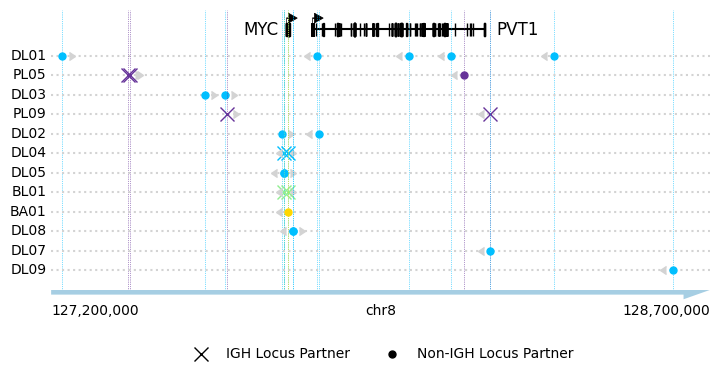

In [147]:
fig, ax = plt.subplots(2, 1, figsize=(8.5, 4), height_ratios=[3, 0.3])
fig.subplots_adjust(hspace=0)

bw = pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
ax_start = 127200000
ax_end = 128700000
chrom = "chr8"

# ax_bigwig = ax[0]
ax_gene = ax[0]
ax_region = ax[1]

plot_bigwig_track(bw, chrom, ax_start, ax_end, color=BIGWIG_COLOUR, ax=ax_bigwig)
ax_bigwig.set_ylim((0, GLOBAL_BW_MAX))
ax_bigwig.yaxis.set_visible(True)
ax_bigwig.spines[["left"]].set_visible(True)
ax_bigwig.set_ylabel("H3K27ac\n(GCBC)", rotation=0, ha="right", va="center", fontsize=10)
ax_bigwig.yaxis.set_visible(True)
ax_bigwig.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=9)
ax_bigwig.get_yticklabels()[0].set_va("bottom")
ax_bigwig.get_yticklabels()[-1].set_va("top")

plot_gene_track(chrom, ax_start, ax_end, gene_filter=["MYC", "PVT1"], min_rows=0, fontsize=12, ax=ax_gene, arrowhead_width=0.3, arrow_length=5000, all_same_line=True)
ax_gene.set_ylim((-0.8 - 0.6 * len(myc_rearranged), 0.6))

markers = ["P"] * len(myc_rearranged)
marker_y = -0.8
sample_markers = {}

legend_handles = []
for (sample, rearrangements), _ in zip(myc_rearranged, markers):
    # Get the breakpoint on chr3
    color = group_colors[sample.meta.group]
    ax_gene.axhline(marker_y, ls=":", color="lightgray")
    ax_gene.text(ax_start-1e4, marker_y, sample.meta.id_paper, ha="right", va="center", fontsize=10)
    for sv in rearrangements:
        pos = sv.posA
        strand = sv.strandA
        strand_m = 8 if strand == Strand.POS else 9
        strand_d = 15000
        strand_d = -strand_d if strand == Strand.POS else strand_d
        _, genesB = show_nearby_genes_stranded(sv, width=1000000, protein_coding=False)
        found_igh = False
        for gene in genesB:
            if gene.startswith("IGH"):
                found_igh=True
                break
        marker = "x" if found_igh else "."
        markersize = 10 if found_igh else 10
        ax_gene.plot(pos + strand_d, marker_y, marker=strand_m, color="lightgray")
        ax_gene.plot(pos, marker_y, marker=marker, color=color, markersize=markersize)
        ax_gene.axvline(pos, lw=0.5, ls=":", color=color)
        ax_bigwig.axvline(pos, lw=0.5, ls=":", color=color)
    legend_handles.append(Line2D([], [], lw=0, marker=marker, color=color, label=sample.meta.id_paper))
    sample_markers[sample.meta.id_paper] = marker
    marker_y -= 0.6

for obj in ax_gene.findobj(matplotlib.text.Text):
    if obj.get_text() == "PVT1":
        obj.set_x(128310000)


plot_track(ax_region, PlotRegion((0,0), PlotRegionType.DATA_SEGMENT, matched_segment=BinAlignedSegment(Segment(chrom, ax_start, ax_end), 0)), 
           TrackSpec(TrackType.TRACK_CHR_ARROWS, {"label_chr": True}))


legend_handles = [
    Line2D([], [], lw=0, marker="x", markersize=10, label="IGH Locus Partner", color="black"),
    Line2D([], [], lw=0, marker=".", markersize=10, label="Non-IGH Locus Partner", color="black"),
]

plt.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5, -2), frameon=False, ncol=2, fontsize=10)

fig.savefig(figure_path("supp5_summary_myc_breakpoints.svg"), bbox_inches="tight")

# MYC Reconstruction

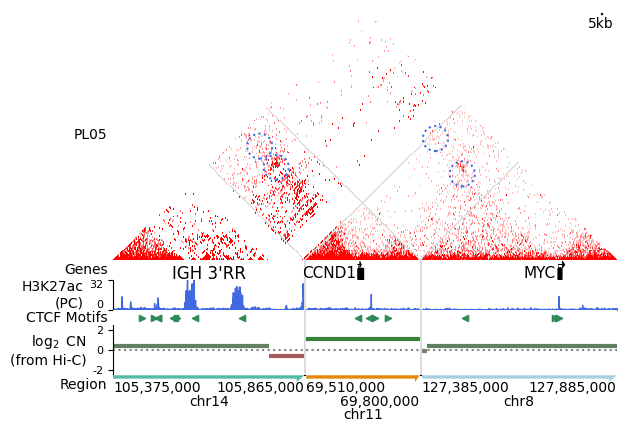

In [142]:
sample_id_paper = "PL05"
resolution = 5000
vmax=2
gene_filter = ["MYC", "CCND1"]
all_same_line=False
bigwig_filename = "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"
bigwig_label = bw_label = "H3K27ac\n(PC)"

sample = [s for s in samples if s.meta.id_paper == sample_id_paper][0]
bw_handle = pyBigWig.open(bigwig_filename)


assembly = Assembly([
    bin_align_segment(Segment("chr14", 105375000, 105865000), resolution),
    bin_align_segment(Segment("chr11", 69510000, 69800000), resolution),
    bin_align_segment(Segment("chr8", 127385000, 127885000), resolution),
])

tracks = [
    TrackSpec(
        track_type=TrackType.TRACK_GENES,
        track_kwargs={
            "min_rows": 0,
            "max_rows": 1,
            "gene_filter": gene_filter,
            "all_same_line": all_same_line,
            "fontsize": 11,
        },
        ylabel="Genes",
        rel_height=0.2
    ),
    TrackSpec(
        track_type=TrackType.TRACK_BIGWIG,
        track_kwargs={
            "bw_handle": pyBigWig.open(bigwig_filename),
            "color": BIGWIG_COLOUR,
            "show_ylim": True,
            "ymax": GLOBAL_BW_MAX,
        },
        ylabel=bigwig_label,
        rel_height=0.3,
    ),
    TrackSpec(
        track_type=TrackType.TRACK_BED_DIRECTIONAL,
        track_kwargs={
            "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
            "color": CTCF_COLOUR,
        },
        ylabel="CTCF Motifs",
        rel_height=0.15,
    ),
    TrackSpec(
        track_type=TrackType.TRACK_BLANK,
        rel_height=0.5,
    ),
    TrackSpec(
        track_type=TrackType.TRACK_CHR_ARROWS,
        track_kwargs={
            "label_chr": True
        },
        ylabel="Region",
        rel_height=0.2,
    )
]


hic_file = read_hic(f"../data/hic/{sample.meta.id_file}_inter_30.hic")
assembled = assemble_hic(hic_file, assembly, gap_size=1, norm=HIC_NORM)


points_to_plot=[]
neoloops = read_neoloops(sample.profile.neoloops)
for neoloop in neoloops:
    # if neoloop.resolution != resolution:
        # continue
    neoloop_regionA, neoloop_regionB = neoloop.to_regions()
    neoloop_posA, neoloop_posB = neoloop.to_positions()
    if ((neoloop_regionA.chr == assembly.segments[0].segment.chr and neoloop_regionB.chr == assembly.segments[1].segment.chr) and
        (assembly.segments[0].segment.start < neoloop_posA.pos < assembly.segments[0].segment.end and assembly.segments[1].segment.start < neoloop_posB.pos < assembly.segments[1].segment.end)) or \
        ((neoloop_regionB.chr == assembly.segments[0].segment.chr and neoloop_regionA.chr == assembly.segments[1].segment.chr) and 
        (assembly.segments[0].segment.start < neoloop_posB.pos < assembly.segments[0].segment.end and assembly.segments[1].segment.start < neoloop_posA.pos < assembly.segments[1].segment.end)):
            points_to_plot.append(neoloop)
    elif ((neoloop_regionA.chr == assembly.segments[1].segment.chr and neoloop_regionB.chr == assembly.segments[2].segment.chr) and
        (assembly.segments[1].segment.start < neoloop_posA.pos < assembly.segments[1].segment.end and assembly.segments[2].segment.start < neoloop_posB.pos < assembly.segments[2].segment.end)) or \
        ((neoloop_regionB.chr == assembly.segments[0].segment.chr and neoloop_regionA.chr == assembly.segments[1].segment.chr) and 
        (assembly.segments[2].segment.start < neoloop_posB.pos < assembly.segments[2].segment.end and assembly.segments[1].segment.start < neoloop_posA.pos < assembly.segments[1].segment.end)):
            points_to_plot.append(neoloop)
    elif ((neoloop_regionA.chr == assembly.segments[0].segment.chr and neoloop_regionB.chr == assembly.segments[2].segment.chr) and
        (assembly.segments[0].segment.start < neoloop_posA.pos < assembly.segments[0].segment.end and assembly.segments[2].segment.start < neoloop_posB.pos < assembly.segments[2].segment.end)) or \
        ((neoloop_regionB.chr == assembly.segments[2].segment.chr and neoloop_regionA.chr == assembly.segments[0].segment.chr) and 
        (assembly.segments[2].segment.start < neoloop_posB.pos < assembly.segments[2].segment.end and assembly.segments[0].segment.start < neoloop_posA.pos < assembly.segments[0].segment.end)):
            points_to_plot.append(neoloop)
fig = plot_triangle_and_tracks(sample.meta.id_paper, assembled, tracks=tracks, size_base=1.3, vmax=vmax, plot_points=points_to_plot, plot_point_kwargs={"ec": LOOP_COLOUR, "ls": ":", "lw": 1.5})

fig.axes[6].set_ylim(0, GLOBAL_BW_MAX)
fig.axes[8].set_ylim(0, GLOBAL_BW_MAX)
fig.axes[10].set_ylim(0, GLOBAL_BW_MAX)

# Text
fig.axes[1].text(0.5, 0.3, "IGH 3'RR", transform=fig.axes[1].transAxes, ha="center", va="center", fontsize=12)
fig.axes[3].findobj(matplotlib.text.Text)[0].set_clip_on(False)
fig.axes[21].findobj(matplotlib.text.Text)[2].set_y(-2)
fig.axes[23].findobj(matplotlib.text.Text)[2].set_y(-3)
fig.axes[23].findobj(matplotlib.text.Text)[1].set_y(-2)
fig.axes[25].findobj(matplotlib.text.Text)[2].set_y(-2)

# Copy Number
ax_cnv_left = fig.axes[16]
ax_cnv_mid = fig.axes[18]
ax_cnv_right = fig.axes[20]
xmin_left, xmax_left = fig.axes[1].get_xlim()
xmin_mid, xmax_mid = fig.axes[3].get_xlim()
xmin_right, xmax_right = fig.axes[5].get_xlim()

invert_left, invert_mid, invert_right = False, False, False
if xmin_left > xmax_left:
    invert_left = True
    xmin_left, xmax_left = xmax_left, xmin_left
if xmin_mid > xmax_mid:
    invert_mid = True
    xmin_mid, xmax_mid = xmax_mid, xmin_mid
if xmin_right > xmax_right:
    invert_right = True
    xmin_right, xmax_right = xmax_right, xmin_right

chr_left = assembly.segments[0].segment.chr
chr_mid = assembly.segments[1].segment.chr
chr_right = assembly.segments[2].segment.chr

plot_cnv_track(sample.meta.id_file, chr_left, ax=ax_cnv_left, locus_lim=(xmin_left, xmax_left), plot_segments=True, plot_scatter=False, cnv_lim=(-2.5,2.5))
plot_cnv_track(sample.meta.id_file, chr_mid, ax=ax_cnv_mid, locus_lim=(xmin_mid, xmax_mid), plot_segments=True, plot_scatter=False, cnv_lim=(-2.5,2.5))
plot_cnv_track(sample.meta.id_file, chr_right, ax=ax_cnv_right, locus_lim=(xmin_right, xmax_right), plot_segments=True, plot_scatter=False, cnv_lim=(-2.5,2.5))

for ax in [ax_cnv_left, ax_cnv_mid, ax_cnv_right]:
    ax.axhline(0, ls=":", color="gray")
    ax.set_ylabel("")
    
ax_cnv_left.spines[["left"]].set_visible(True)
ax_cnv_left.set_ylabel("$\\log_2$ CN\n(from Hi-C)", ha="right", va="center")
ax_cnv_left.set_yticks([-2, 0, 2], [-2, 0, 2], fontsize=8)

if invert_left:
    ax_cnv_left.invert_xaxis()
if invert_mid:
    ax_cnv_mid.invert_xaxis()
if invert_right:
    ax_cnv_right.invert_xaxis()

fig.savefig(figure_path(f"fig5_{sample.meta.id_paper}_complex.svg"), bbox_inches="tight")


### Square Representation

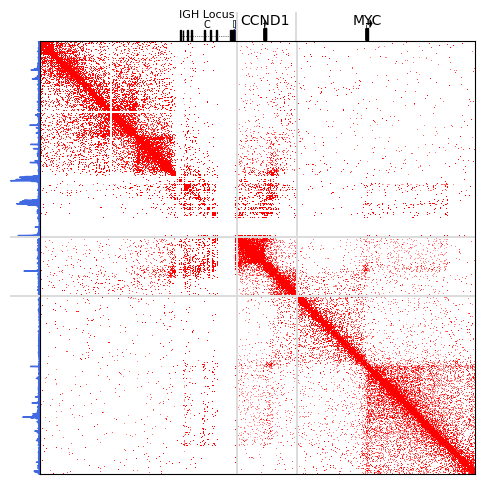

In [77]:
sample = [s for s in samples if s.meta.id_paper == "PL05"][0]
resolution = 5000

bigwig_label, bigwig_file = BW_DICT[sample.meta.group]
bw = pyBigWig.open(bigwig_file)

assembly = Assembly([
    bin_align_segment(Segment("chr14", 104875000, 105865000), resolution),
    bin_align_segment(Segment("chr11", 69510000, 69800000), resolution),
    bin_align_segment(Segment("chr8", 127385000, 128285000), resolution),
])

sample_hic = read_hic(sample.profile.hic)
assembled = assemble_hic(sample_hic, assembly, gap_size=2, norm=HIC_NORM)

plot_regions = assembled.plot_regions
region_ratios = [r.bin_range[1] - r.bin_range[0] for r in plot_regions]
corner_ratio = 30
height_ratios = [corner_ratio] + region_ratios

fig = plt.figure(figsize=(6,6))

spec = fig.add_gridspec(len(height_ratios), len(height_ratios), height_ratios=height_ratios, width_ratios=height_ratios, hspace=0, wspace=0)

for i, region in enumerate(plot_regions):
    ax_gene = fig.add_subplot(spec[0, 1+i])
    ax_bigwig = fig.add_subplot(spec[1+i, 0])

    is_first = i == 0
    is_last = i == len(plot_regions) - 1
    plot_track(ax_gene, region, TrackSpec(
        track_type=TrackType.TRACK_GENES,
        track_kwargs={
            "gene_filter": ["MYC", "CCND1", "IGHM"],
            "all_same_line": True,
            "centered_names": True,
            "fontsize": 10,
            "min_rows": 0,
            "max_rows": 1,
        },
    ))
    plot_track(ax_bigwig, region, TrackSpec(
        track_type=TrackType.TRACK_BIGWIG,
        track_kwargs={
            "bw_handle": bw,
            "color": BIGWIG_COLOUR,
            "vertical": True,
            "ymax": GLOBAL_BW_MAX,
            "show_ylim": True,
        },
    ))
    if i == 0:
        ax_gene.clear()
        xmin = region.matched_segment.segment.start
        xmax = region.matched_segment.segment.end
        for letter, (rmin, rmax, rects) in igh_locus.items():
            mid = (max(rmin, xmin) + min(rmax, xmax)) / 2
            color = locus_colors[letter]
            ax_gene.hlines(0, rmin,  min(rmax, xmax), colors=color, ls=":", lw=0.5, clip_on=False)
            ax_gene.text(mid, 0.5, letter, ha="center", va="bottom",  fontsize=7, color=color, clip_on=False)
            for (rectmin, rectmax) in rects:
                if xmin < rectmin < xmax and xmin < rectmax < xmax:
                    ax_gene.add_patch(Rectangle((rectmin, 0-0.5), rectmax-rectmin, 1, fc=color, ec=color, clip_on=False))
        ax_gene.text(mid, 1.5, "IGH Locus", fontsize=8, ha="center")
        ax_gene.set_xlim(region.matched_segment.segment.start, region.matched_segment.segment.end)
        ax_gene.set_ylim(-0.5, 2)
        ax_gene.set_yticks([])

    

ax_hic = fig.add_subplot(spec[1:, 1:])
ax_hic.matshow(assembled.data, cmap=REDMAP, aspect="auto", vmax=1)
ax_hic.set_yticks([])
ax_hic.set_xticks([])
fig.savefig(figure_path("supp_reconstruction3way.svg"), bbox_inches="tight")

### Square Representation - Large

In [6]:
sample = [s for s in samples if s.meta.id_paper == "PL05"][0]
arima_sample = read_sample(sample.meta.id_paper, sample.profile.hic, sample.profile.qc, None)


involved = ["chr8", "chr11", "chr14"]
boundaries = []
resolution = 1000000

all_chroms = []
for chromX in involved:
    row_of_chroms = []
    for chromY in involved:
        data = get_hic_direct_data(arima_sample, chromX, 0, CHROM_SIZES[chromX], chromY, 0, CHROM_SIZES[chromY], resolution=resolution, normalization="NONE")
        row_of_chroms.append(data)
    stacked = np.vstack(row_of_chroms)
    all_chroms.append(stacked)
    boundaries.append(stacked.shape[1])
all_chroms = np.hstack(all_chroms)

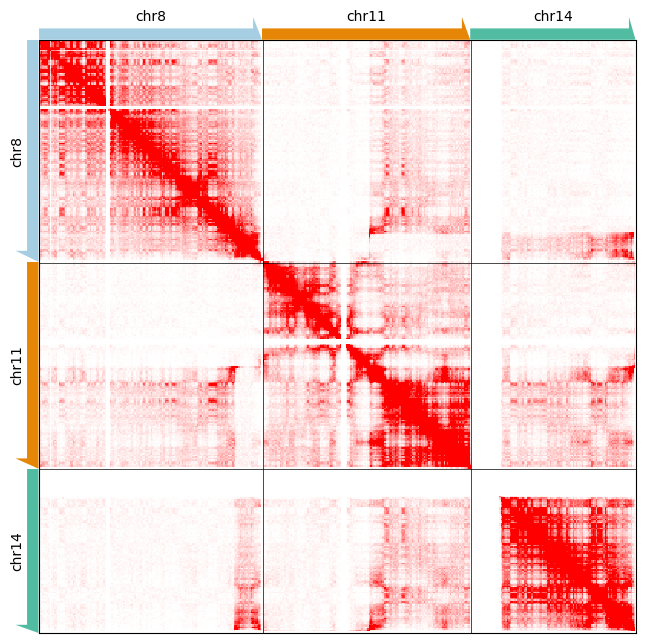

In [174]:
fig = plt.figure(figsize=(8,8))

height_ratios = [15] + boundaries
width_ratios=height_ratios
spec = GridSpec(len(involved)+1, len(involved)+1, figure=fig, hspace=0, wspace=0, height_ratios=height_ratios, width_ratios=width_ratios)

ax_central = fig.add_subplot(spec[1:, 1:])
ax_arrows_top = [fig.add_subplot(spec[0, 1+i]) for i in range(len(involved))]
ax_arrows_left = [fig.add_subplot(spec[1+i, 0]) for i in range(len(involved))]

for (chrom, ax_top, ax_left) in zip(involved, ax_arrows_top, ax_arrows_left):
    plot_track(ax=ax_top, plot_region=PlotRegion(bin_range=(0,0), plot_region_type=PlotRegionType.DATA_SEGMENT, matched_segment=BinAlignedSegment(segment=Segment(chrom, 0, CHROM_SIZES[chrom]), resolution=resolution)), track=TrackSpec(TrackType.TRACK_CHR_ARROWS))
    ax_top.xaxis.set_label_position("top")
    ax_top.text(0.5, 0.7, chrom, ha="center", va="top", fontsize=10, transform=ax_top.transAxes)
    ax_top.invert_yaxis()
    for text in ax_top.findobj(matplotlib.text.Text):
        text.set_va("bottom")
        if "chr" not in text.get_text():
            text.set_text("")
    ax_left.arrow(0, 0, 0, 1, fc=CHROM_COLORS[chrom], ec="none", length_includes_head=True, head_length=0.05, shape="right", width=1, head_width=2)
    ax_left.set_ylim((1, 0))
    ax_left.set_xlim(-1, 0)
    ax_left.set_ylabel(chrom, rotation=90, ha="center", va="top", fontsize=10)
    blank_axis(ax_left)

ax_central.matshow(all_chroms, cmap=REDMAP, vmax=30, aspect="auto")
for boundary in np.cumsum(boundaries)[:-1]:
    ax_central.axhline(boundary, color="black", lw=0.5)
    ax_central.axvline(boundary, color="black", lw=0.5)
ax_central.set_xticks([])
ax_central.set_yticks([])

fig.savefig(figure_path("supp5_complex_reconstruction_fullmat.svg"), bbox_inches="tight")

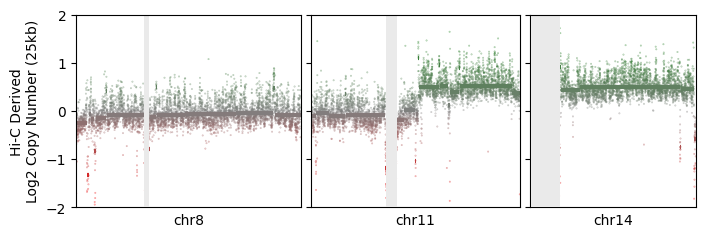

In [42]:
# Hi-C derived copy number
width_ratios=boundaries
fig, ax = plt.subplots(1, len(involved), figsize=(8,2.5), sharey=True, width_ratios=width_ratios)
fig.subplots_adjust(wspace=0.05)

centromeres = [(43900000, 47000000), (49000000, 55500000), (1000000, 19700000)]

for i, (chrom, (centr_start, centr_end)) in enumerate(zip(involved, centromeres)):
    plot_cnv_track(sample.meta.id_file, chrom, plot_scatter=True, plot_segments=True, ax=ax[i], cnv_lim=(-2,2))
    if i > 0:
        ax[i].set_ylabel("")
    ax[i].axvspan(centr_start, centr_end, fc="#eaeaea", ec="none", zorder=10)
    ax[i].spines[["top"]].set_zorder(100)
    ax[i].set_xlabel(chrom)

ax[0].set_ylabel("Hi-C Derived\nLog2 Copy Number (25kb)")

fig.savefig(figure_path("supp5_hic_cnv_chroms.svg"), bbox_inches="tight")

# ALL MYC Triangles

In [20]:
bw_dict = {
    "DLBCL": ("GCBC", "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw"),
    "PCN": ("PC", "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"),
}
bw_default = ("GCBC", "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
myc_pos = (127735434+127742951)/2
mycn_pos = (15940550+15947007)/2

In [21]:
def get_compartment_data(compartments, chr, start, end, res=100000):
    if res == 25000:
        compartment_regions = COMPARTMENT_REGIONS_25kb
    else:
        compartment_regions = COMPARTMENT_REGIONS_100kb
    pad_start = 0 
    pad_end = 0 
    comp_start = int(max(0, start // res* res))
    comp_end = int(min((end // res* res)+res, CHROM_SIZES[chr] // res * res))
    if start < 0:
        pad_start += -start // res
    print("DEBUG: ", end, CHROM_SIZES[chr] // res * res)
    if end > CHROM_SIZES[chr] // res * res:
        pad_end += (end - CHROM_SIZES[chr]) // res
    print(chr, comp_start, comp_end)
    comp_start_index = compartment_regions[(compartment_regions["chr"] == chr) & (compartment_regions["start"] == comp_start)]
    comp_end_index = compartment_regions[(compartment_regions["chr"] == chr) & (compartment_regions["start"] == comp_end)]
    print("Comp start and end", comp_start_index, comp_end_index)

    compartment_array = compartments[comp_start_index.index[0]:comp_end_index.index[0]]
    print("Comp array", compartment_array.min(), compartment_array.max())
    
    # Pad with zeros if needed
    if pad_start > 0:
        compartment_array = np.concatenate([np.zeros(int(pad_start)), compartment_array])
        comp_start = (start // res) * res
    if pad_end > 0:
        compartment_array = np.concatenate([compartment_array, np.zeros(int(pad_end))])
        comp_end = (end // res) * res + res
        
    return compartment_array, comp_start, comp_end

def plot_compartments(sample, chr, start, end, ax, res=100000, vmax=0.5):
    if res == 25000:
        comp_file = sample.extra_comp_25kb
    else:
        comp_file = sample.profile.compartments
    comp_list = read_compartments(comp_file, resolution=res)
    comp_x, comp_start, comp_end = get_compartment_data(comp_list, chr, start, end, res=res)
    vmin = -vmax
    ax.imshow(np.expand_dims(comp_x, axis=0), aspect="auto", cmap="seismic", extent=(comp_start, comp_end, 0, 1), vmin=vmin, vmax=vmax)
    blank_axis(ax)

def make_triangle_tracks(bigwig_filename: str, bigwig_label: str, gene_filter=None, all_same_line=False, centered_names=False, gene_rel_height=0.2, gene_fontsize=11):
    return [
        TrackSpec(
            track_type=TrackType.TRACK_GENES,
            track_kwargs={
                "min_rows": 0,
                "max_rows": 1,
                "gene_filter": gene_filter,
                "all_same_line": all_same_line,
                "fontsize": gene_fontsize,
                "centered_names": centered_names
            },
            ylabel="Genes",
            rel_height=gene_rel_height
        ),
        TrackSpec(
            track_type=TrackType.TRACK_BIGWIG,
            track_kwargs={
                "bw_handle": pyBigWig.open(bigwig_filename),
                "color": BIGWIG_COLOUR,
                "ymax": GLOBAL_BW_MAX,
                "show_ylim": True,
            },
            ylabel=bigwig_label,
            rel_height=0.4,
        ),
        TrackSpec(
            TrackType.TRACK_BLANK,
            rel_height=0.12,
        ),
        TrackSpec(
            track_type=TrackType.TRACK_BED_DIRECTIONAL,
            track_kwargs={
                "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
                "color": CTCF_COLOUR,
            },
            ylabel="CTCF Motifs",
            rel_height=0.15,
        ),
        TrackSpec(
            track_type=TrackType.TRACK_CHR_ARROWS,
            track_kwargs={
                "label_chr": True
            },
            ylabel="Region",
            rel_height=0.2,
        )
    ]

def plot_hic_centered_wrapper(sample: Sample, centerX: Position, centerY: Position, resolution: int, radius: int, norm=HIC_NORM, ax=None, crosshair: None | tuple[Position, Position] | str=None, decorate=False, **kwargs) -> tuple[plt.Axes, tuple[int, int], tuple[int, int]]:
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    arima_sample = read_sample(sample.meta.id_file, sample.profile.hic, sample.profile.qc, None)
    ax, xlim, ylim, _ = plot_hic_centered_matrix(arima_sample, centerX.chr, centerX.pos, centerY.chr, centerY.pos, ax=ax, resolution=resolution, radius=radius, normalization=norm, **kwargs)

    # Remove center xtick and ytick 
    ax.get_xticklabels()[1].set_visible(False)
    ax.get_yticklabels()[1].set_visible(False)
    ax.get_xticklabels()[0].set_fontsize(11)
    ax.get_yticklabels()[0].set_fontsize(11)
    ax.get_xticklabels()[1].set_fontsize(11)
    ax.get_yticklabels()[1].set_fontsize(11)
    ax.set_xlabel(ax.get_xlabel(), fontsize=11)
    ax.set_ylabel(ax.get_ylabel(), fontsize=11)

    if crosshair is not None:
        if crosshair == "center":
            ax.axvline(centerX.pos // resolution * resolution, color="gray", linestyle=":")
            ax.axhline(centerY.pos // resolution * resolution, color="gray", linestyle=":")
        elif isinstance(crosshair, tuple):
            posA, posB = crosshair
            ax.axvline(posA.pos // resolution * resolution, color="gray", linestyle=":")
            ax.axhline(posB.pos // resolution * resolution, color="gray", linestyle=":")

    if decorate is True:
        if sample.availability == "internal":
            extra = f" ({sample.group})"
        else:
            extra = ""
        ax.set_title(f"{sample.id_short}" + extra, loc="left", fontsize=12, x=0.1)
        ax.add_patch(Rectangle((0, 1.05), 0.06, 0.06, transform=ax.transAxes, color=COLOR_DICT[sample.group], clip_on=False))

    return ax, xlim, ylim

def plot_hic_centered_with_genes_and_bigwig(
        sample: Sample,
        sv: CuratedCall,
        resolution: int=25000, 
        radius: int=20*25000, 
        gene_filter: list[str] = None,
        figsize: tuple[int, int] = (3, 3),
        savefig=False,
        sv_index=0,
        all_same_line=False,
        show_arrows_top=True,
        show_arrows_left=True,
        bw_handle=None,
        bw_label="",
        centered_names=False,
        crosshairs=True,
        **kwargs
):


    centerX, centerY = sv.to_positions()

    fig = plt.figure(figsize=figsize)
    gene_track_width_ratio = 0.125
    bigwig_track_width_ratio=0.2
    spec = fig.add_gridspec(3, 3, width_ratios=[gene_track_width_ratio, bigwig_track_width_ratio, 1], height_ratios=[gene_track_width_ratio, bigwig_track_width_ratio, 1], wspace=0.02, hspace=0.02)

    ax_center = fig.add_subplot(spec[2, 2])
    ax_gene_left_y = fig.add_subplot(spec[2, 0])
    ax_gene_top_x = fig.add_subplot(spec[0, 2])
    ax_bigwig_left_y = fig.add_subplot(spec[2, 1])
    ax_bigwig_top_x = fig.add_subplot(spec[1, 2])

    _, (xmin, xmax), (ymin, ymax) = plot_hic_centered_wrapper(sample, centerX, centerY, resolution, radius, crosshair=True, ax=ax_center, **kwargs)
    print(ax_center.get_ylim())

    # Reduce fontsize of x and y tick labels
    ax_center.tick_params(axis="both", labelsize=9)

    # Remove center tick 
    ax_center.xaxis.get_major_ticks()[1].set_visible(False)
    ax_center.yaxis.get_major_ticks()[1].set_visible(False)

    # Draw marker at SV and crosshairs
    if crosshairs:
        ax_center.plot(centerX.pos, centerY.pos, marker="+", color=CROSS_COLOUR, markersize=20)
        ax_center.axvline(centerX.pos, color=CROSS_COLOUR, lw=1, linestyle=":")
        ax_center.axhline(centerY.pos, color=CROSS_COLOUR, lw=1, linestyle=":")

    plot_gene_track(centerX.chr, xmin, xmax, gene_filter=gene_filter, centered_names=centered_names, max_rows=1, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=10, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line, show_arrows=show_arrows_top)
    plot_gene_track(centerY.chr, ymin, ymax, vertical=True, gene_filter=gene_filter, centered_names=centered_names, protein_coding_only=False, ax=ax_gene_left_y, fontsize=10, max_rows=1, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line, show_arrows=show_arrows_left)



    plot_bigwig_track(bw_handle, centerX.chr, xmin, xmax, ax=ax_bigwig_top_x, color=BIGWIG_COLOUR) 
    plot_bigwig_track(bw_handle, centerY.chr, ymin, ymax, vertical=True, ax=ax_bigwig_left_y, color=BIGWIG_COLOUR,)
    ax_bigwig_top_x.set_ylim((0, GLOBAL_BW_MAX))
    ax_bigwig_top_x.yaxis.set_visible(True)
    ax_bigwig_top_x.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=8, rotation=90)
    ax_bigwig_top_x.yaxis.tick_right()
    ax_bigwig_top_x.yaxis.set_label_position("right")
    ax_bigwig_top_x.spines[["right"]].set_visible(True)
    ax_bigwig_top_x.get_yticklabels()[0].set_va("bottom")
    ax_bigwig_top_x.get_yticklabels()[-1].set_va("top")
    ax_bigwig_top_x.set_ylabel(bw_label.replace(" ","\n"), fontsize=8, ha="center", va="top")
    ax_bigwig_left_y.set_xlim((GLOBAL_BW_MAX, 0))
    ax_bigwig_left_y.xaxis.set_visible(True)
    ax_bigwig_left_y.set_xticks([GLOBAL_BW_MAX, 0], [ GLOBAL_BW_MAX, 0], fontsize=8)
    ax_bigwig_left_y.xaxis.tick_bottom()
    ax_bigwig_left_y.spines[["bottom"]].set_visible(True)
    ax_bigwig_left_y.get_xticklabels()[0].set_ha("left")
    ax_bigwig_left_y.get_xticklabels()[-1].set_ha("right")
    ax_bigwig_left_y.set_xlabel(bw_label.replace(" ","\n"), fontsize=8, ha="center", va="top")
    ax_bigwig_left_y.xaxis.set_label_position("bottom")
    
    # Add title with sample id (and colored box next to it with group color)
    group_color = group_colors[sample.meta.group]
    title = f"{sample.meta.id_paper} ({sample.meta.group})"
    fig.text(0.11, 0.99, "■", ha="left", va="top", fontsize=10, color=group_color, fontweight="bold")
    fig.text(0.22, 0.99, title, ha="left", va="top", fontsize=10, fontweight="bold")

    # if savefig:
        # fig.savefig(figure_path(f"fig5_alt_hic_{sample.meta.id_paper}_{'-'.join(gene_filter[:2])}.svg"), bbox_inches="tight")

    return fig, (xmin, xmax), (ymin, ymax)

def plot_extra_triangles(sample, sv, width, resolution, gene_filter, tracks, bw_handle=None, all_same_line=False, bw_label="", vmax=15, comp_res=100000, comp_vmax=0.1, centered_names=False, matrix_vmax=None, crosshairs=True):
    sample_id = sample.meta.id_file
    
    (chrA, posA, strandA, chrB, posB, strandB) = sv.chrA, sv.posA, sv.strandA, sv.chrB, sv.posB, sv.strandB
    1
    if (chrA != "chr8" and "MYC" in gene_filter) or (chrA != "chr2" and "MYCN" in gene_filter):
        chrA, posA, strandA, chrB, posB, strandB = sv.chrB, sv.posB, sv.strandB, sv.chrA, sv.posA, sv.strandA
    
    if strandA == Strand.POS: 
        startA = posA - width 
        endA = posA
        is_minus_strand_A = False
    else:
        startA = posA
        endA = posA + width
        is_minus_strand_A = True
    if strandB == Strand.NEG: 
        startB = posB
        endB = posB + width
        is_minus_strand_B = False
    else:
        startB = posB - width
        endB = posB
        is_minus_strand_B = True
    
    segmentA = bin_align_segment(Segment(chrA, startA, endA, is_minus_strand=is_minus_strand_A), resolution)
    segmentB = bin_align_segment(Segment(chrB, startB, endB, is_minus_strand=is_minus_strand_B), resolution)
    
    assembly = Assembly([
        segmentA,
        segmentB,
    ])
    
    hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
    assembled = assemble_hic(hic_file, assembly, gap_size=1, norm=HIC_NORM)
    

    # Get neoloops to plot
    points_to_plot = []
    neoloops = read_neoloops(sample.profile.neoloops)
    for neoloop in neoloops:
        # if neoloop.resolution != resolution:
            # continue
        neoloop_regionA, neoloop_regionB = neoloop.to_regions()
        neoloop_posA, neoloop_posB= neoloop.to_positions()
        if (neoloop_regionA.chr == assembly.segments[0].segment.chr and neoloop_regionB.chr == assembly.segments[1].segment.chr) or \
            (neoloop_regionB.chr == assembly.segments[0].segment.chr and neoloop_regionA.chr == assembly.segments[1].segment.chr):
            # plot only neoloops near MYC promoter
            if (neoloop_posA.chr == "chr8" and abs(neoloop_posA.pos - myc_pos) <= 100000) or \
                (neoloop_posB.chr == "chr8" and abs(neoloop_posB.pos - myc_pos) <= 100000) or \
                (neoloop_posA.chr == "chr2" and abs(neoloop_posA.pos - mycn_pos) <= 100000) or \
                (neoloop_posB.chr == "chr2" and abs(neoloop_posB.pos - mycn_pos) <= 1000000):
                points_to_plot.append(neoloop)
    
    fig = plot_triangle_and_tracks(sample.meta.id_paper, assembled, tracks=tracks, size_base=1.15, vmax=vmax, plot_points=points_to_plot, plot_point_kwargs={"ec": LOOP_COLOUR, "ls": ":", "lw": 1.5})

    ax_comp_left = fig.axes[7]
    ax_comp_right = fig.axes[9]
    
    xmin_left, xmax_left = fig.axes[1].get_xlim()
    xmin_right, xmax_right = fig.axes[3].get_xlim()
    
    invert_left, invert_right = False, False
    if xmin_left > xmax_left:
        invert_left = True
        xmin_left, xmax_left = xmax_left, xmin_left
    if xmin_right > xmax_right:
        invert_right = True
        xmin_right, xmax_right = xmax_right, xmin_right
    
    print(-comp_vmax, comp_vmax)
    plot_compartments(sample, chrA, xmin_left, xmax_left, ax_comp_left, res=comp_res, vmax=comp_vmax)
    plot_compartments(sample, chrB, xmin_right, xmax_right, ax_comp_right, res=comp_res, vmax=comp_vmax)
    ax_comp_left.set_xlim((xmin_left, xmax_left))
    ax_comp_right.set_xlim((xmin_right, xmax_right))
    print(xmin_left, xmax_left, xmin_right, xmax_right)
    ax_comp_left.set_ylabel("Compartments", ha="right", va="center")
    ax_comp_left.yaxis.set_visible(True)
    ax_comp_left.set_yticks([])
    ax_comp_right.set_ylabel("")
    if invert_left:
        ax_comp_left.invert_xaxis()
    if invert_right:
        ax_comp_right.invert_xaxis()

    cax = fig.axes[0].inset_axes([0.82, 0.7, 0.18, 0.05])
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-comp_vmax, vmax=comp_vmax), cmap="seismic"), cax=cax, orientation='horizontal', ticks=[-comp_vmax, 0, comp_vmax])
    cax.tick_params(rotation=-90, labelsize=7)
    cax.set_xticklabels([-comp_vmax, 0, "+"+str(comp_vmax)])
    cax.text(1,1.1, "Compartments", ha="right", va="bottom", transform=cax.transAxes, fontsize=8)
    
    fig.axes[4].set_ylim(0, GLOBAL_BW_MAX)
    fig.axes[6].set_ylim(0, GLOBAL_BW_MAX)

    fig2, _, _ = plot_hic_centered_with_genes_and_bigwig(
        sample, 
        sv,
        resolution, 
        width, 
        gene_filter=gene_filter,
        bw_handle=bw_handle,
        savefig=True,
        all_same_line=all_same_line,
        bw_label=bw_label,
        centered_names=centered_names,
        vmax=matrix_vmax,
        crosshairs=crosshairs,
    )
    return fig, fig2

-0.08 0.08
DEBUG:  128200000.0 145100000
chr8 127200000 128300000
Comp start and end         chr      start        end  blacklisted
15189  chr8  127200000  127299999        False         chr      start        end  blacklisted
15200  chr8  128300000  128399999        False
Comp array 0.0096958908493169 0.0465782426064985
DEBUG:  25025000.0 133200000
chr12 24000000 25100000
Comp start and end          chr     start       end  blacklisted
19682  chr12  24000000  24099999        False          chr     start       end  blacklisted
19693  chr12  25100000  25199999        False
Comp array -0.0325972678049601 0.0234989541682066
127200000.0 128200000.0 24025000.0 25025000.0
(26025000.0, 24025000.0)
-0.08 0.08
DEBUG:  129250000.0 145100000
chr8 128200000 129300000
Comp start and end         chr      start        end  blacklisted
15199  chr8  128200000  128299999        False         chr      start        end  blacklisted
15210  chr8  129300000  129399999        False
Comp array -0.01769035880214

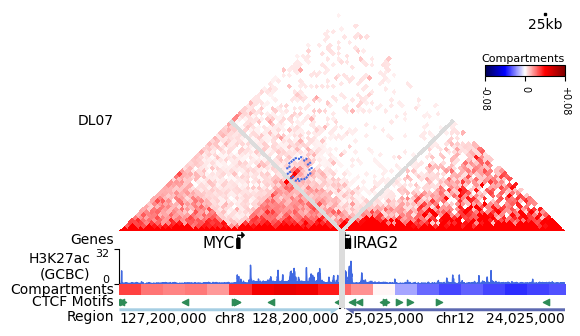

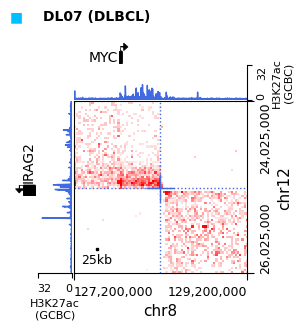

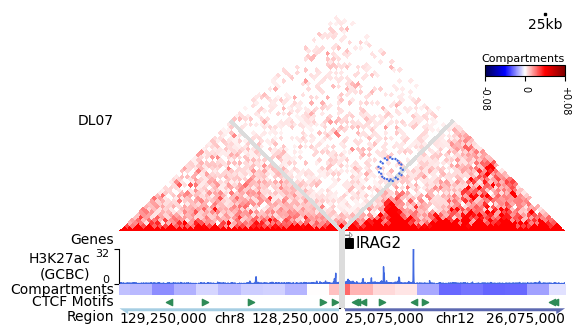

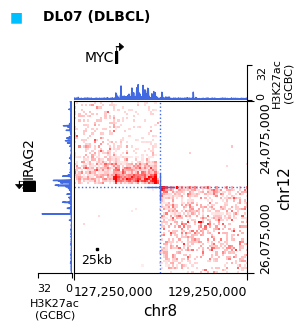

In [18]:
sample_id_paper = "DL07"
gene_filter = ["MYC","IRAG2"]
resolution = 25000
width = 40 * resolution
vmax=15
comp_res=100000
comp_vmax=0.08

sample = [s for s in samples if s.meta.id_paper == sample_id_paper][0]
bw_label, bw_file = bw_dict[sample.meta.group] if sample.meta.group in bw_dict.keys() else bw_default
tracks = make_triangle_tracks(bw_file, f"H3K27ac\n({bw_label})", gene_filter, all_same_line=True)

for sv in read_curated_calls(sample.profile.curated):
    if (sv.chrA == "chr8" and abs(sv.posA - myc_pos) < 1000000) or (sv.chrB == "chr8" and abs(sv.posB - myc_pos) < 1000000):
        fig1, fig2 = plot_extra_triangles(sample, sv, width, resolution, gene_filter, tracks, bw_handle=pyBigWig.open(bw_file), all_same_line=True, bw_label=f"H3K27ac ({bw_label})", vmax=vmax, comp_res=comp_res, comp_vmax=comp_vmax)

        stranding = "+" if sv.strandA == Strand.POS else "-"
        fig1.savefig(figure_path(f"fig5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}.svg"), bbox_inches="tight")
        fig2.savefig(figure_path(f"supp5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}_matrix.svg"), bbox_inches="tight")
    

-0.08 0.08
chr8 127700000 128800000
Comp start and end         chr      start        end  blacklisted
15194  chr8  127700000  127799999        False         chr      start        end  blacklisted
15205  chr8  128800000  128899999        False
Comp array 0.0011341684680286 0.0345327217667595
chr2 141800000 142900000
Comp start and end        chr      start        end  blacklisted
3908  chr2  141800000  141899999        False        chr      start        end  blacklisted
3919  chr2  142900000  142999999        False
Comp array -0.0292768529347323 0.0083837945657761
127750000.0 128750000.0 141800000.0 142800000.0
(128750000.0, 126750000.0)
-0.08 0.08
chr8 126700000 127800000
Comp start and end         chr      start        end  blacklisted
15184  chr8  126700000  126799999        False         chr      start        end  blacklisted
15195  chr8  127800000  127899999        False
Comp array -0.013552585932949 0.0298312203007408
chr2 142800000 143900000
Comp start and end        chr      sta

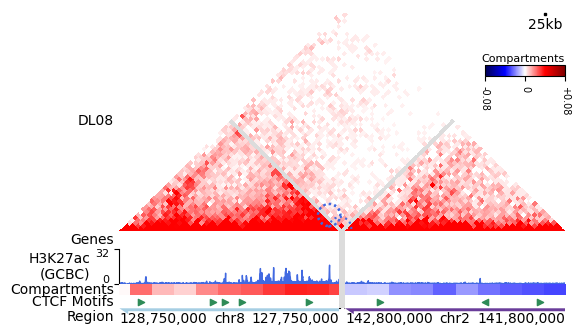

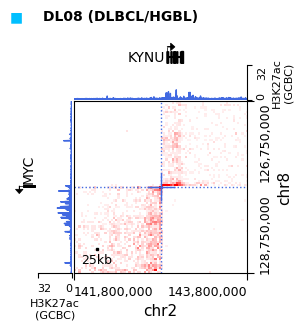

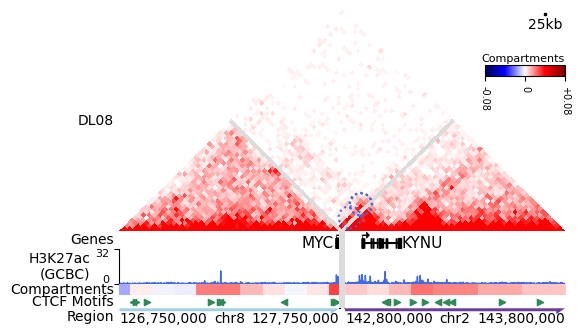

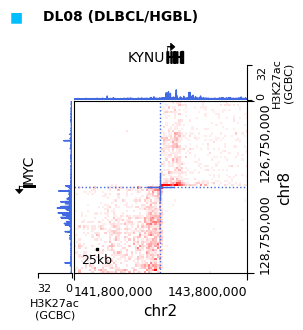

In [97]:
sample_id_paper = "DL08"
gene_filter = ["MYC","KYNU"]
resolution = 25000
width = 40 * resolution
vmax=15
comp_res=100000
comp_vmax=0.08

sample = [s for s in samples if s.meta.id_paper == sample_id_paper][0]
bw_label, bw_file = bw_dict[sample.meta.group] if sample.meta.group in bw_dict.keys() else bw_default
tracks = make_triangle_tracks(bw_file, f"H3K27ac\n({bw_label})", gene_filter, all_same_line=True)

for sv in read_curated_calls(sample.profile.curated):
    if (sv.chrA == "chr8" and abs(sv.posA - myc_pos) < 1000000) or (sv.chrB == "chr8" and abs(sv.posB - myc_pos) < 1000000):
        fig1, fig2 = plot_extra_triangles(sample, sv, width, resolution, gene_filter, tracks, bw_handle=pyBigWig.open(bw_file), all_same_line=True, bw_label=f"H3K27ac ({bw_label})", vmax=vmax, comp_res=comp_res, comp_vmax=comp_vmax)
        ax_gene = fig1.axes[3]
        matches = ax_gene.findobj(matplotlib.text.Text)
        if len(matches) > 0:
            matches[0].set_x(GENE_ANNOTATIONS.genes_by_name("KYNU")[0].end)
            matches[0].set_ha("left")
            
        stranding = "+" if sv.strandA == Strand.POS else "-"
        fig1.savefig(figure_path(f"fig5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}.svg"), bbox_inches="tight")
        fig2.savefig(figure_path(f"supp5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}_matrix.svg"), bbox_inches="tight")


-0.08 0.08
chr8 126700000 127800000
Comp start and end         chr      start        end  blacklisted
15184  chr8  126700000  126799999        False         chr      start        end  blacklisted
15195  chr8  127800000  127899999        False
Comp array -0.0110078177898295 0.0118900052768393
chr9 36200000 37300000
Comp start and end         chr     start       end  blacklisted
15731  chr9  36200000  36299999        False         chr     start       end  blacklisted
15742  chr9  37300000  37399999        False
Comp array -0.0025274646467349 0.024436335431781
126725000.0 127725000.0 36200000.0 37200000.0
(38200000.0, 36200000.0)
-0.08 0.08
chr8 127700000 128800000
Comp start and end         chr      start        end  blacklisted
15194  chr8  127700000  127799999        False         chr      start        end  blacklisted
15205  chr8  128800000  128899999        False
Comp array -0.0150361377531139 0.0288767415802282
chr9 37200000 38300000
Comp start and end         chr     start       en

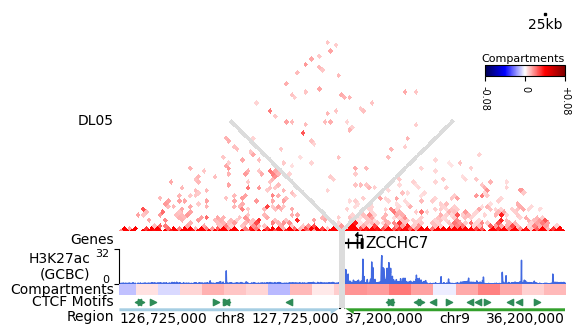

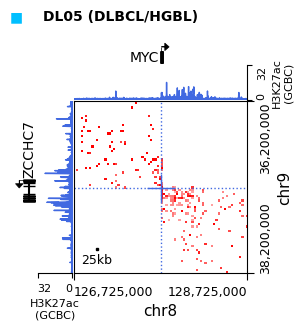

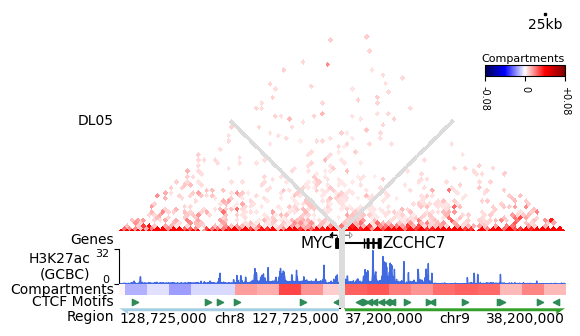

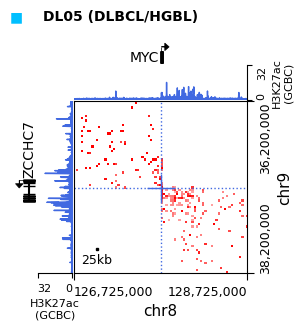

In [99]:
sample_id_paper = "DL05"
gene_filter = ["MYC","ZCCHC7"]
resolution = 25000
width = 40 * resolution
vmax=4
comp_res=100000
comp_vmax=0.08

sample = [s for s in samples if s.meta.id_paper == sample_id_paper][0]
bw_label, bw_file = bw_dict[sample.meta.group] if sample.meta.group in bw_dict.keys() else bw_default
tracks = make_triangle_tracks(bw_file, f"H3K27ac\n({bw_label})", gene_filter, all_same_line=True)

for sv in read_curated_calls(sample.profile.curated):
    if (sv.chrA == "chr8" and abs(sv.posA - myc_pos) < 1000000) or (sv.chrB == "chr8" and abs(sv.posB - myc_pos) < 1000000):
        fig1, fig2 = plot_extra_triangles(sample, sv, width, resolution, gene_filter, tracks, bw_handle=pyBigWig.open(bw_file), all_same_line=True, bw_label=f"H3K27ac ({bw_label})", vmax=vmax, comp_res=comp_res, comp_vmax=comp_vmax)

        stranding = "+" if sv.strandA == Strand.POS else "-"
        fig1.savefig(figure_path(f"fig5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}.svg"), bbox_inches="tight")
        fig2.savefig(figure_path(f"supp5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}_matrix.svg"), bbox_inches="tight")


-0.08 0.08
chr2 15000000 16100000
Comp start and end        chr     start       end  blacklisted
2640  chr2  15000000  15099999        False        chr     start       end  blacklisted
2651  chr2  16100000  16199999        False
Comp array -0.0081752976620972 0.0144212634623351
chr4 84700000 85800000
Comp start and end        chr     start       end  blacklisted
7742  chr4  84700000  84799999        False        chr     start       end  blacklisted
7753  chr4  85800000  85899999        False
Comp array -0.0043228501324586 0.0501473910479324
15025000.0 16025000.0 84725000.0 85725000.0
(86725000.0, 84725000.0)
-0.08 0.08
chr2 16100000 17200000
Comp start and end        chr     start       end  blacklisted
2651  chr2  16100000  16199999        False        chr     start       end  blacklisted
2662  chr2  17200000  17299999        False
Comp array -0.0112681707898237 0.0380342833872989
chr4 85700000 86800000
Comp start and end        chr     start       end  blacklisted
7752  chr4  8570000

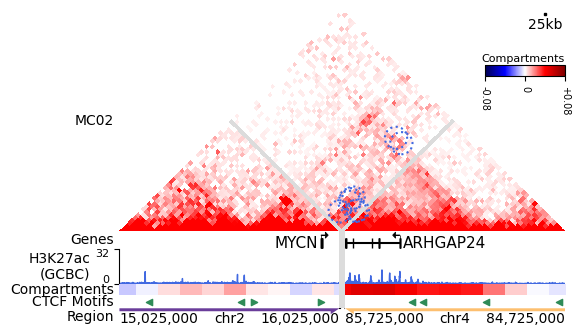

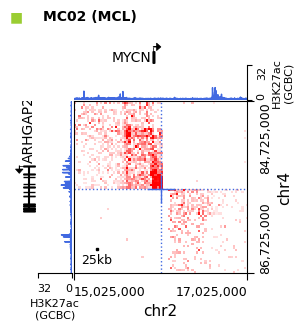

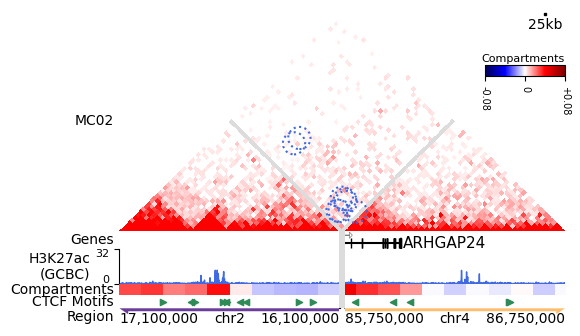

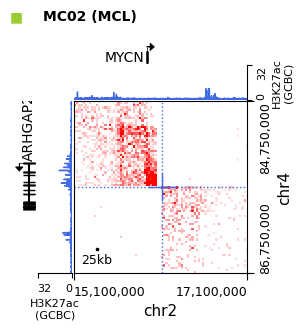

In [105]:
sample_id_paper = "MC02"
gene_filter = ["MYCN","ARHGAP24"]
mycn_pos = (15940550+15947007) / 2
resolution = 25000
width = 40 * resolution
vmax=10
comp_res=100000
comp_vmax=0.08

sample = [s for s in samples if s.meta.id_paper == sample_id_paper][0]
bw_label, bw_file = bw_dict[sample.meta.group] if sample.meta.group in bw_dict.keys() else bw_default
tracks = make_triangle_tracks(bw_file, f"H3K27ac\n({bw_label})", gene_filter, all_same_line=True)

for sv in read_curated_calls(sample.profile.curated):
    if (sv.chrA == "chr2" and abs(sv.posA - mycn_pos) < 1000000) or (sv.chrB == "chr2" and abs(sv.posB - mycn_pos) < 1000000):
        fig1, fig2 = plot_extra_triangles(sample, sv, width, resolution, gene_filter, tracks, bw_handle=pyBigWig.open(bw_file), all_same_line=True, bw_label=f"H3K27ac ({bw_label})", vmax=vmax, comp_res=comp_res, comp_vmax=comp_vmax)


        stranding = "+" if sv.strandA == Strand.POS else "-"
        fig1.savefig(figure_path(f"fig5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}.svg"), bbox_inches="tight")
        fig2.savefig(figure_path(f"supp5_{sample.meta.id_paper}_{sv.chrA}-{sv.posA}_{stranding}_{sv.chrB}-{sv.posB}_matrix.svg"), bbox_inches="tight")

# Insulation Composite

In [17]:
resolution = 10000
measure = "observed"
norm = HIC_NORM
assembly_start = 127100000
assembly_end = 128500000

segment = bin_align_segment(Segment(
    "chr8",
    assembly_start,
    assembly_end,
), resolution)

all_dlbcl = []
all_plasmacytoma = []

for sample in samples:
    sample_id = sample.meta.id_file
    group = sample.meta.group
    if group == "PCN":
        list_to_add_to = all_plasmacytoma
    elif group == "DLBCL":
        list_to_add_to = all_dlbcl
    else:
        continue
    # Only include if MYC intact
    myc_intact = True
    svs = pd.read_csv(f"../data/curated_breakpoints/{sample_id}_curated_breakpoints.tsv", sep='\s+', header=None, names=["chrA", "chrB", "strands", "posA", "posB", "sv_type"])
    for i, sv in svs.iterrows():
        genesA, genesB = show_nearby_genes_stranded_unrolled(sv["chrA"], sv["posA"], Strand.POS if sv["strands"][0] == "+" else Strand.NEG, sv["chrB"], sv["posB"], Strand.POS if sv["strands"][1] == "+" else Strand.NEG, width=1000000, buffer=25000, protein_coding=False)
        if ("MYC" in genesA or "MYC" in genesB) and (sv.chrA != sv.chrB or abs(sv.posA - sv.posB) > 5000000):
            myc_intact = False
            break
    if not myc_intact:
        continue
    if sample.meta.id_paper in {"PL13", "PL04"}: # exclude MYC amplified from composite plot
        continue
    hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
    data = get_hic_for_segment_pair(hic_file, pair_segments(segment, segment), norm=HIC_NORM, measure=measure)
    # Normalize by unique valid pairs
    data = data / (data.max() - data.min())
    uvp = get_uvp(sample_id)
    data = (data * uvp) / 10000000
    list_to_add_to.append((sample_id, data))

dlbcl_mean = np.mean([data for _, data in all_dlbcl], axis=0)
plasmacytoma_mean = np.mean([data for _, data in all_plasmacytoma], axis=0)

assembly = Assembly([
    segment
])

hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
assembled = assemble_hic(hic_file, assembly, gap_size=1, measure="observed", norm=norm)


In [18]:
insulations_dlbcl = []
insulations_plasmacytoma = []
window = 10*resolution
insulation_xaxis = None

for samples_group, list_group in zip([all_dlbcl, all_plasmacytoma], [insulations_dlbcl, insulations_plasmacytoma]):
    for sample_id, _ in samples_group:
#         cool_file = read_cooler(sample_id, resolution)
#         insulation_table = cooltools.insulation(cool_file, [window], verbose=False, nproc=8)
        insulation_table = pd.read_csv(f"../data/insulations/res_10000_window_100000/{sample_id}_insulation_r{resolution}_w{window}.csv")
        insulation_subset = insulation_table[(insulation_table.chrom == "chr8") & (insulation_table.start >= assembly_start) & (insulation_table.end <= assembly_end)]
        if insulation_xaxis is None:
            insulation_xaxis = insulation_subset["start"].values
        list_group.append((sample_id, insulation_subset[f"log2_insulation_score_{window}"], insulation_subset[f"is_boundary_{window}"]))

In [19]:
print("MMME")
print(pd.read_csv("../annotations/myc_crispri/ANBL6_CRISPRi_MMME_merged.hg38lo.bed", sep="\t", header=None))
mmme_enh_start = 128267064 
mmme_enh_end = 128273645

MMME
      0          1          2     3  4  5          6          7        8
0  chr8  128267064  128273645  MMME  1  *  128267064  128273645  #0000FF


In [20]:
print("GME-1")
print(pd.read_csv("../annotations/myc_crispri/Karpas422_CRISPRi_GME1_merged.hg38lo.bed", sep="\t", header=None))
gme1_enh_start = 128171021
gme1_enh_end = 128174465

GME-1
      0          1          2      3  4  5          6          7        8
0  chr8  128171021  128174465  GME-1  1  *  128171021  128174465  #0000FF


(0.0, 1.0)
(0.0, 1.0)


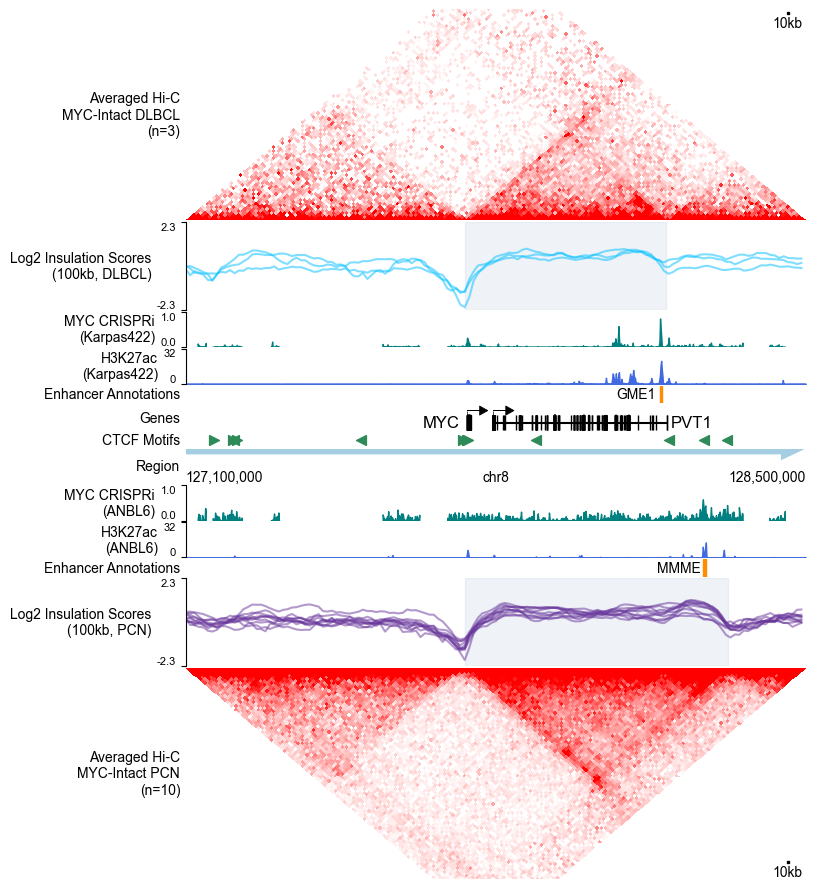

In [21]:
fig = plt.figure(figsize=(8, 11.3))

gs = fig.add_gridspec(13, 1, height_ratios=[12, 5, 2,  2, 1, 1.5, 0.8, 2, 2, 2, 1, 5, 12])
fig.subplots_adjust(hspace=0.025)

ax_top_triangle = fig.add_subplot(gs[0, 0])
ax_bottom_triangle = fig.add_subplot(gs[12, 0])

ax_top_insulations = fig.add_subplot(gs[1, 0])
ax_bottom_insulations = fig.add_subplot(gs[11, 0])

ax_bigwig_track_dlbcl = fig.add_subplot(gs[2, 0])
ax_h3k27ac_track_dlbcl = fig.add_subplot(gs[3, 0])
ax_enhancer_track_dlbcl = fig.add_subplot(gs[4, 0])
ax_gene_track = fig.add_subplot(gs[5, 0])
ax_ctcf_track = fig.add_subplot(gs[6, 0])
ax_chr_track = fig.add_subplot(gs[7, 0])
ax_bigwig_track_plasmacytoma = fig.add_subplot(gs[8, 0])
ax_h3k27ac_track_plasmacytoma = fig.add_subplot(gs[9, 0])
ax_enhancer_track_plasmacytoma = fig.add_subplot(gs[10, 0])

mmme_enh_rect = Rectangle((mmme_enh_start, -0.5), mmme_enh_end - mmme_enh_start, 1, color="darkorange")
gme1_enh_rect = Rectangle((gme1_enh_start, -0.5), gme1_enh_end - gme1_enh_start, 1, color="darkorange")
ax_enhancer_track_plasmacytoma.add_patch(mmme_enh_rect)
ax_enhancer_track_dlbcl.add_patch(gme1_enh_rect)
for ax_enhancer_track in [ax_enhancer_track_plasmacytoma, ax_enhancer_track_dlbcl]:
    ax_enhancer_track.set_xlim((assembly_start, assembly_end))
    ax_enhancer_track.set_ylim((-0.5, 0.5))
    blank_axis(ax_enhancer_track)
    ax_enhancer_track.set_ylabel("Enhancer Annotations", rotation=0, ha="right", va="center")
ax_enhancer_track_plasmacytoma.text(mmme_enh_end-1e4, 0, "MMME", ha="right", va="center") 
ax_enhancer_track_dlbcl.text(gme1_enh_start-1e4, 0, "GME1", ha="right", va="center")

plot_track(ax_gene_track, assembled.plot_regions[0], TrackSpec(
    track_type = TrackType.TRACK_GENES,
    track_kwargs = {
        "fontsize": 12,
        "min_rows": 0,
        "max_rows": 1,
        "gene_filter": ["MYC", "PVT1"],
        "all_same_line": True,
        # "arrow_length": 0.1,
        # "arrowhead_length_proportion": 0.01,
        # "arrowhead_width": 0.01,
    },
    ylabel="Genes"
))

plot_track(ax_bigwig_track_dlbcl, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BIGWIG,
    track_kwargs={
        "bw_handle": pyBigWig.open("../annotations/myc_crispri/Karpas422_MYC.filt.norm.hg38lo.cleaned.bw"),
        "color": "teal",
        "ymax": 1,
        "show_ylim": True,
    },
    ylabel="MYC CRISPRi\n(Karpas422)"
))
plot_track(ax_h3k27ac_track_dlbcl, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BIGWIG,
    track_kwargs={
        "bw_handle": pyBigWig.open("../annotations/H3K27ac/05_Karpas422_H3K27ac.bw"),
        "color": BIGWIG_COLOUR,
        "ymax": GLOBAL_BW_MAX,
        "show_ylim": True
    },
    ylabel="H3K27ac\n(Karpas422)"
))


plot_track(ax_bigwig_track_plasmacytoma, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BIGWIG,
    track_kwargs={
        "bw_handle": pyBigWig.open("../annotations/myc_crispri/ANBL6_MYC.filt.norm.hg38lo.cleaned.bw"),
        "color": "teal",
        "ymax": 1,
        "show_ylim": True,
    },
    ylabel="MYC CRISPRi\n(ANBL6)"
))
plot_track(ax_h3k27ac_track_plasmacytoma, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BIGWIG,
    track_kwargs={
        "bw_handle": pyBigWig.open("../annotations/H3K27ac/07_ANBL6_H3K27ac.bw"),
        "color": BIGWIG_COLOUR,
        "ymax": GLOBAL_BW_MAX,
        "show_ylim": True,
    },
    ylabel="H3K27ac\n(ANBL6)"
))

ax_h3k27ac_track_dlbcl.set_ylim((0, GLOBAL_BW_MAX))
ax_h3k27ac_track_plasmacytoma.set_ylim((0, GLOBAL_BW_MAX))

print(ax_bigwig_track_plasmacytoma.get_ylim())
print(ax_bigwig_track_dlbcl.get_ylim())

plot_track(ax_ctcf_track, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BED_DIRECTIONAL,
    track_kwargs={
        "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
        "color": CTCF_COLOUR,
        "s": 50,
    },
    ylabel="CTCF Motifs"
))

plot_track(ax_chr_track, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_CHR_ARROWS,
    track_kwargs={
        "label_chr": True
    },
    ylabel="Region"
))

pvt1_gene = ax_gene_track.findobj(matplotlib.text.Text)[1]
pvt1_gene.set_x(128290000)

vspan_col = "lightgrey"
vspan_alpha=0.2
ax_top_insulations.axvspan(127731000, 128185000, color="lightsteelblue", alpha=vspan_alpha)
ax_bottom_insulations.axvspan(127731000, 128325000, color="lightsteelblue", alpha=vspan_alpha)

for sample_id, insulation_data, _ in insulations_dlbcl:
    group = [ s.meta.group for s in samples if s.meta.id_file == sample_id][0]
    ax_top_insulations.plot(insulation_xaxis, (insulation_data), alpha=0.5, color=group_colors[group])
for sample_id, insulation_data, _ in insulations_plasmacytoma:
    group = [ s.meta.group for s in samples if s.meta.id_file == sample_id][0]
    ax_bottom_insulations.plot(insulation_xaxis, (insulation_data), alpha=0.5, color=group_colors[group])
ax_top_insulations.set_xlim(assembly_start, assembly_end)
ax_bottom_insulations.set_xlim(assembly_start, assembly_end)
# Set y lims the same
insulation_ymax = max(ax_top_insulations.get_ylim()[1], ax_bottom_insulations.get_ylim()[1])
insulation_ymin = min(ax_top_insulations.get_ylim()[0], ax_bottom_insulations.get_ylim()[0])
insulation_sym = max(abs(insulation_ymin), insulation_ymax)
insulation_ymax = insulation_sym
insulation_ymin = -insulation_sym
ax_top_insulations.set_ylim(insulation_ymin, insulation_ymax)
ax_bottom_insulations.set_ylim(insulation_ymin, insulation_ymax)
ax_top_insulations.set_yticks([])
ax_bottom_insulations.set_yticks([])
ax_top_insulations.set_ylabel(f"Log2 Insulation Scores\n({int_to_resolution(window)}, DLBCL)", rotation=0, ha="right", va="center")
ax_bottom_insulations.set_ylabel(f"Log2 Insulation Scores\n({int_to_resolution(window)}, PCN)", rotation=0, ha="right", va="center")
ax_top_insulations.set_xticks([])
ax_bottom_insulations.set_xticks([])
ax_top_insulations.spines[['top', 'right', 'left', "bottom"]].set_visible(False)
ax_bottom_insulations.spines[['top', 'right', 'left', "bottom"]].set_visible(False)


# Set bigwig ylims to be the same
bigwig_ymax = max(ax_bigwig_track_dlbcl.get_ylim()[1], ax_bigwig_track_plasmacytoma.get_ylim()[1])
ax_bigwig_track_dlbcl.set_ylim(0, bigwig_ymax)
ax_bigwig_track_plasmacytoma.set_ylim(0, bigwig_ymax)

hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
assembled = assemble_hic(hic_file, assembly, gap_size=1, measure="observed", norm=norm)

assembled_dlbcl = AssembledHic(
    data=dlbcl_mean,
    plot_regions=assembled.plot_regions,
)

assembled_plasmacytoma = AssembledHic(
    data=plasmacytoma_mean,
    plot_regions=assembled.plot_regions,
)

vmax = max(np.nanmax(assembled_dlbcl.data), np.nanmax(assembled_plasmacytoma.data)) / 15
plot_assembled_triangle(assembled_dlbcl, ax=ax_top_triangle, aspect="auto", vmax=vmax, rasterized=True)
plot_assembled_triangle(assembled_plasmacytoma, ax=ax_bottom_triangle, aspect="auto", vmax=vmax, rasterized=True)

ax_top_triangle.set_ylabel(f"Averaged Hi-C\nMYC-Intact DLBCL\n(n={len(insulations_dlbcl)})", rotation=0, ha="right", va="center")
ax_bottom_triangle.set_ylabel(f"Averaged Hi-C\nMYC-Intact PCN\n(n={len(insulations_plasmacytoma)})", rotation=0, ha="right", va="center")

for ax in [ax_top_insulations, ax_bottom_insulations, ax_h3k27ac_track_dlbcl, ax_h3k27ac_track_plasmacytoma, ax_bigwig_track_dlbcl, ax_bigwig_track_plasmacytoma]:
    ymin, ymax = ax.get_ylim()
    ax.yaxis.set_visible(True)
    ax.spines[["left"]].set_visible(True)
    if ymax > 3:
        ax.set_yticks([ymin, ymax], [int(ymin), int(ymax)], fontsize=8)
    else:
        ax.set_yticks([ymin, ymax], [f"{ymin:.1f}", f"{ymax:.1f}"], fontsize=8)
    ax.get_yticklabels()[0].set_va("bottom")
    ax.get_yticklabels()[-1].set_va("top")
# Change y axis limits
ymax = (assembled.data.shape[1])*2/5
ax_top_triangle.set_ylim((0, ymax))
ax_bottom_triangle.set_ylim((0, ymax))
# Flip y axis on bottom triangle
ax_bottom_triangle.invert_yaxis()
# Change position of anchored size bar on bottom triangle
for child in ax_bottom_triangle.get_children()[::-1]:
    if isinstance(child, AnchoredSizeBar):
        child.set_bbox_to_anchor((1, 0.1), transform=ax_bottom_triangle.transAxes)
        break
fig.savefig(figure_path("fig6_insulation_comparison.svg"), bbox_inches="tight")



### CTCF Site Comparisons

In [86]:
ctcfA = 128191258
ctcfB = 128322839
(ctcfB - ctcfA) / 1000

131.581

In [87]:
myc_intact_dlbcl = "DC06 DC03 DC05 DC04 DC01 DC02 DL11 DL10 DL06".split()
myc_intact_pcn = "PL12 PL11 PL08 PL07 PL06 PL10 PL02 PL14 PL03 PL01".split()
dlbclA = []
dlbclB = []
pcnA = []
pcnB = []
for (sample, insulations) in all_insulations:
    if sample.id_paper in myc_intact_dlbcl:
        listA = dlbclA
        listB = dlbclB
    elif sample.id_paper in myc_intact_pcn:
        listA = pcnA
        listB = pcnB
    else:
        continue
    for i, row in insulations.iterrows():
        if row.start <= ctcfA <= row.end:
            listA.append(row["log2_insulation_score_100000"])
        elif row.start <= ctcfB <= row.end:
            listB.append(row["log2_insulation_score_100000"])

In [74]:
pvalA = scipy.stats.mannwhitneyu(dlbclA, pcnA)
print(pvalA)

MannwhitneyuResult(statistic=15.0, pvalue=0.01601099081051716)


In [75]:
pvalB = scipy.stats.mannwhitneyu(dlbclB, pcnB)
print(pvalB)

MannwhitneyuResult(statistic=72.0, pvalue=0.030486156935263346)


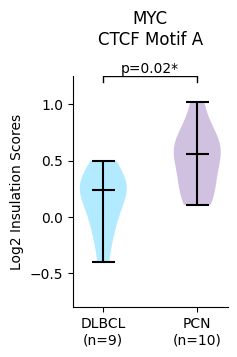

In [76]:
fig, ax = plt.subplots(figsize=(2, 3))
parts = ax.violinplot([dlbclA, pcnA], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(group_colors["DLBCL"])
parts['bodies'][1].set_facecolor(group_colors["PCN"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")

ax.plot([0,0, 1, 1], [1.2, 1.25, 1.25, 1.2], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
ax.text(0.5, 1.25, f"p={pvalA.pvalue:.2f}*", ha="center", va="bottom")
ax.set_xticks([0, 1], [f"DLBCL\n(n={len(dlbclA)})", f"PCN\n(n={len(pcnA)})"])
ax.set_title(f"MYC\nCTCF Motif A", y=1.1)
ax.set_ylim(-0.8, 1.25)
fig.savefig(figure_path("fig6_boxplot_A.svg"), bbox_inches="tight")

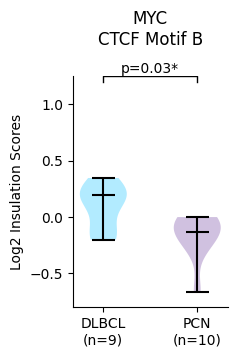

In [77]:
fig, ax = plt.subplots(figsize=(2, 3))

parts = ax.violinplot([dlbclB, pcnB], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(group_colors["DLBCL"])
parts['bodies'][1].set_facecolor(group_colors["PCN"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")

ax.plot([0,0, 1, 1], [1.2, 1.25, 1.25, 1.2], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
ax.text(0.5, 1.25, f"p={pvalB.pvalue:.2f}*", ha="center", va="bottom")
ax.set_title(f"MYC\nCTCF Motif B", y=1.1)
ax.set_xticks([0, 1], [f"DLBCL\n(n={len(dlbclA)})", f"PCN\n(n={len(pcnA)})"])
ax.set_ylim(-0.8, 1.25)
fig.savefig(figure_path("fig6_boxplot_B.svg"), bbox_inches="tight")

# All MYC Triangles

In [22]:
def plot_myc_locus(sample_id_paper, gene, lims=None):
    sample = [s for s in samples if s.meta.id_paper == sample_id_paper][0]
    gene_obj = GENE_ANNOTATIONS.genes_by_name(gene)[0]
    gene_chr = chr_prefix(str(gene_obj.contig))
    gene_start = gene_obj.start
    gene_end = gene_obj.end

    resolution = 25000
    radius = 40
    if lims is None:
        start = bin_align_value(gene_start - resolution * radius, resolution)
        end = bin_align_value(gene_end + resolution * radius, resolution)
    else:
        (start, end) = lims

    assembly = Assembly([bin_align_segment(Segment(gene_chr, start, end), resolution)])
    assembled = assemble_hic(read_hic(sample.profile.hic), assembly, norm="NONE")

    tracks = [
        # TrackSpec(TrackType.TRACK_BLANK, track_kwargs={}, rel_height=0.1),
        # TrackSpec(TrackType.TRACK_BLANK, track_kwargs={}, rel_height=0.5),
        TrackSpec(
            track_type=TrackType.TRACK_BIGWIG,
            track_kwargs={
                "bw_handle": pyBigWig.open("../annotations/H3K27ac/05_Karpas422_H3K27ac.bw"),
                "color": BIGWIG_COLOUR,
                "ymax": GLOBAL_BW_MAX,
                "show_ylim": True,
            },
            ylabel="H3K27ac\n(Karpas422)",
            rel_height=0.4,
        ),
        TrackSpec(
            track_type=TrackType.TRACK_BIGWIG,
            track_kwargs={
                "bw_handle": pyBigWig.open("../annotations/H3K27ac/07_ANBL6_H3K27ac.bw"),
                "color": BIGWIG_COLOUR,
                "ymax": GLOBAL_BW_MAX,
                "show_ylim": True,
            },
            ylabel="H3K27ac\n(ANBL6)",
            rel_height=0.4
        ),
        TrackSpec(TrackType.TRACK_GENES, track_kwargs={"gene_filter": [gene], "all_same_line": True, "min_rows": 0, "max_rows": 1, "fontsize": 11}, ylabel="Genes", rel_height=0.3),
        TrackSpec(
            track_type=TrackType.TRACK_BED_DIRECTIONAL,
            track_kwargs={
                "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
                "color": CTCF_COLOUR,
                "s": 50,
            },
            ylabel="CTCF Motifs",
            rel_height=0.25
        ),
        TrackSpec(TrackType.TRACK_CHR_ARROWS, track_kwargs = {"label_chr": True}, rel_height=0.25),
    ]

    vmax = assembled.data.mean() + assembled.data.std()
    fig = plot_triangle_and_tracks(sample_id_paper, assembled, tracks, size_base=0.8, vmax=vmax)
    fig.axes[0].yaxis.get_label().set_fontsize(20)

    
    return fig

/gpfs/data/snuderllab/jw8710/hic/notebooks/utilities.py:1762: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


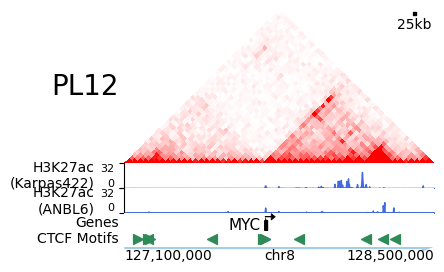

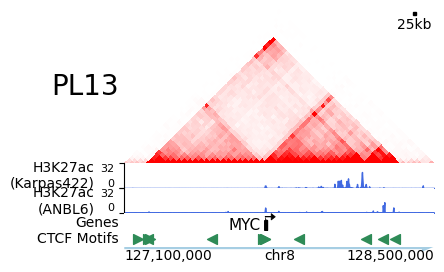

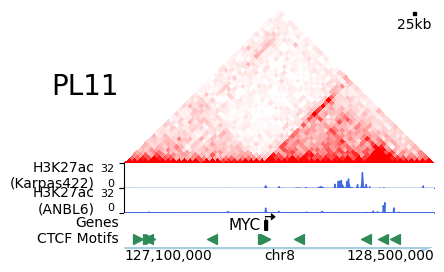

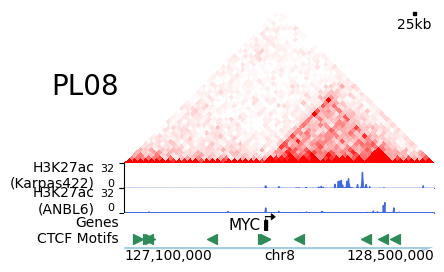

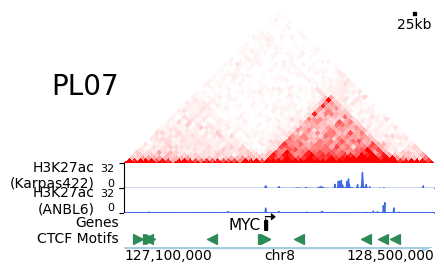

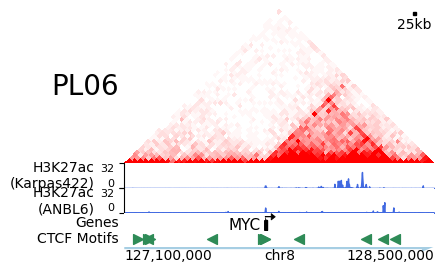

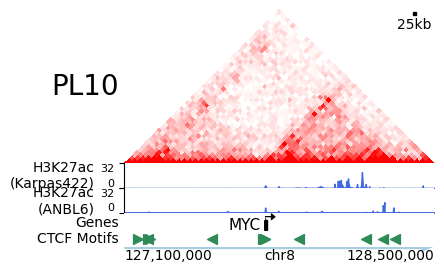

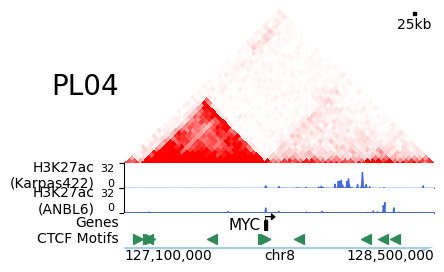

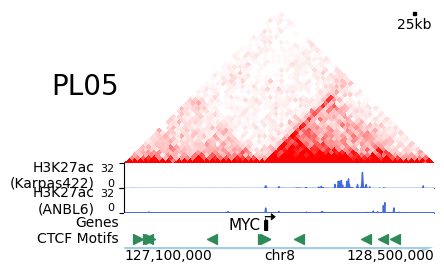

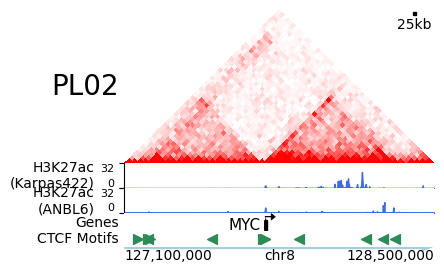

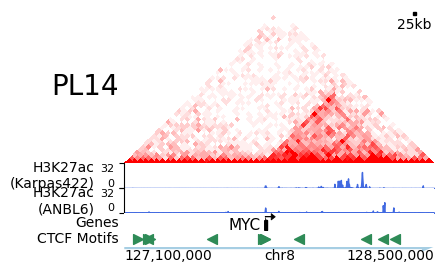

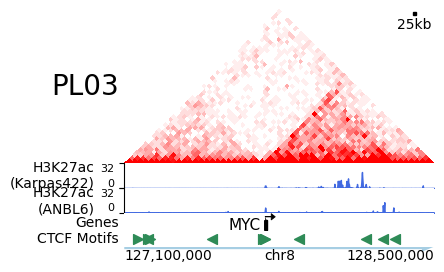

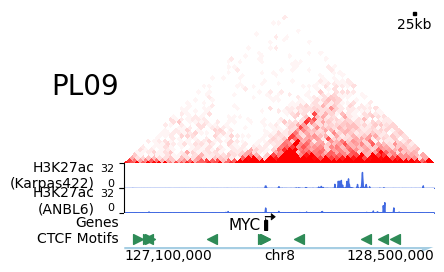

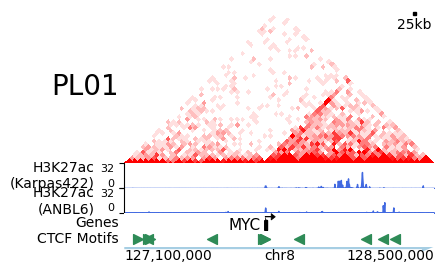

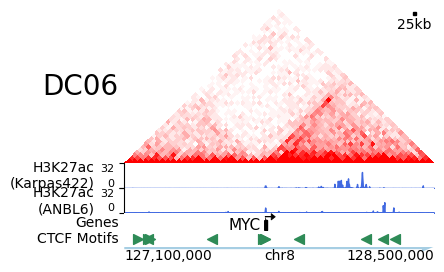

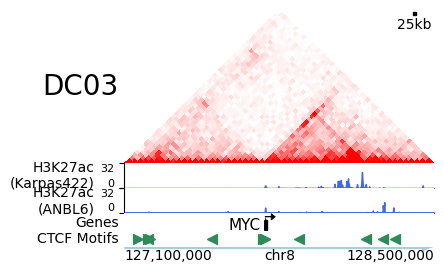

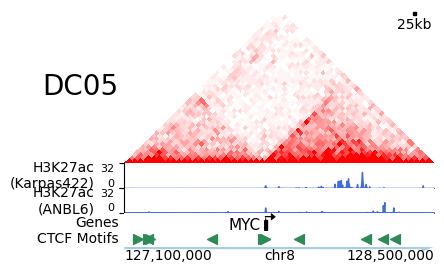

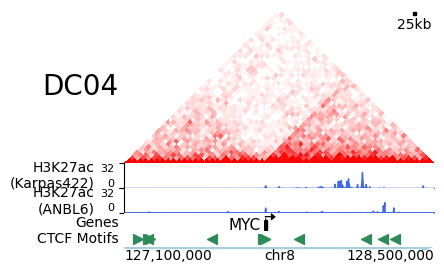

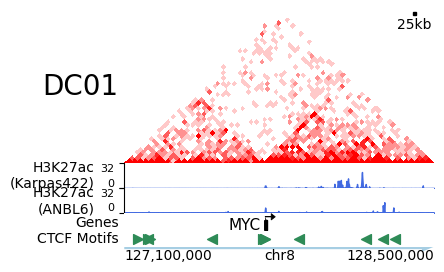

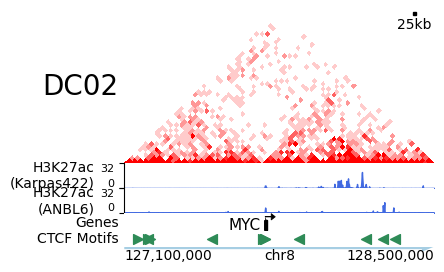

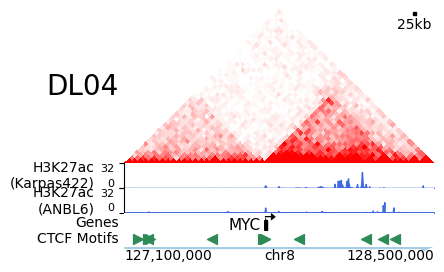

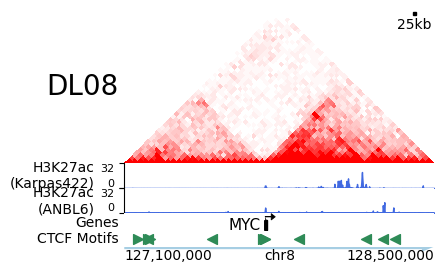

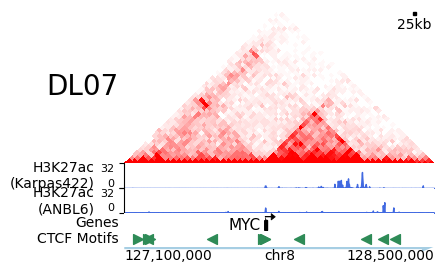

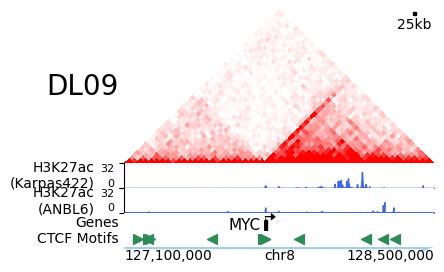

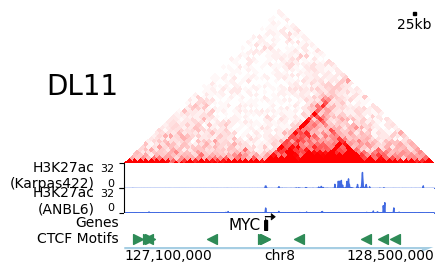

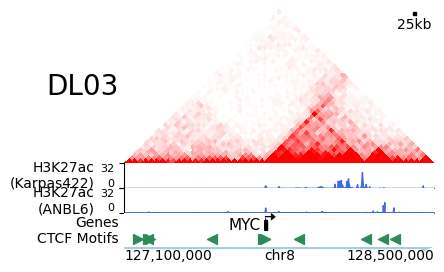

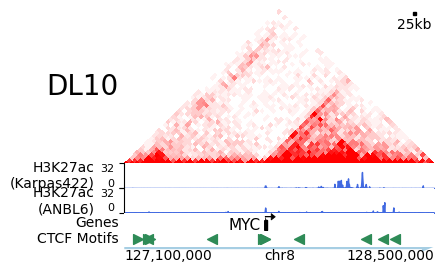

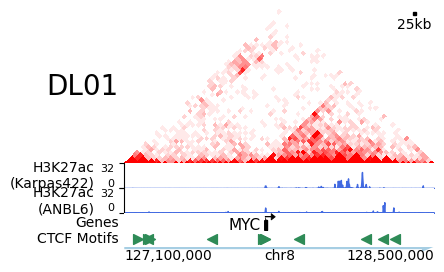

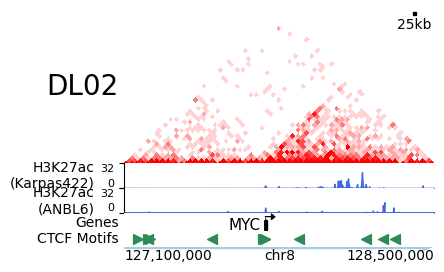

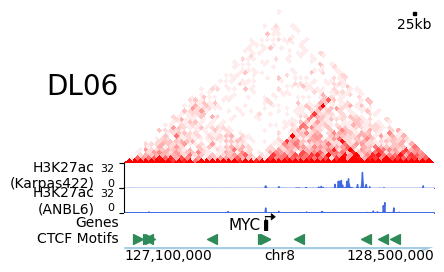

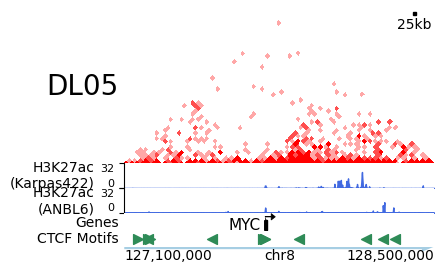

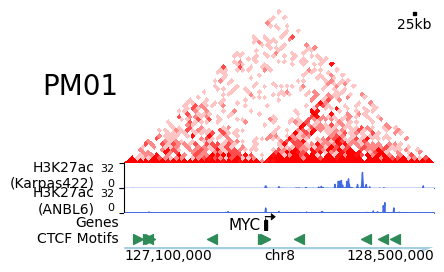

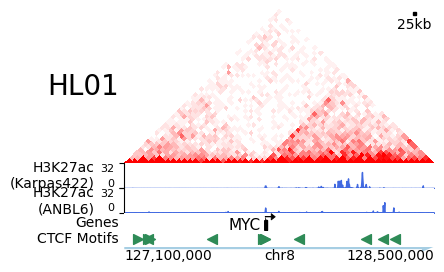

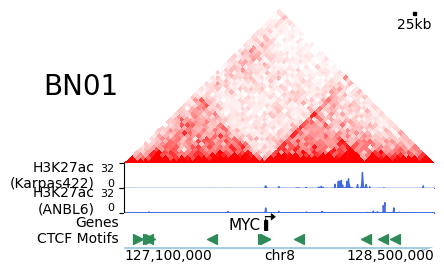

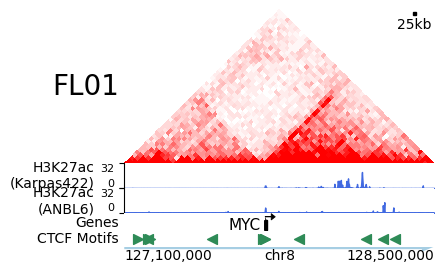

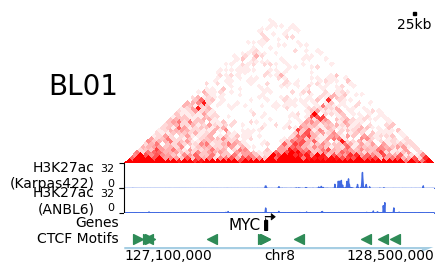

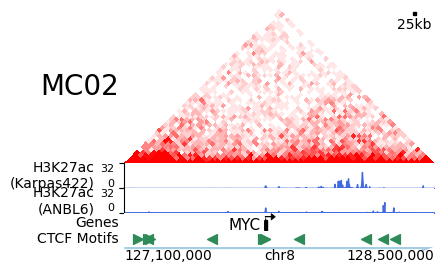

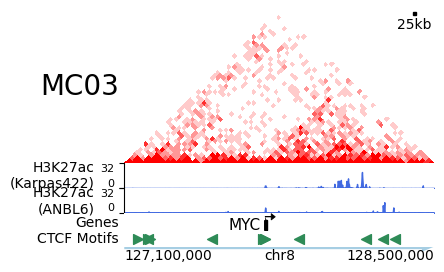

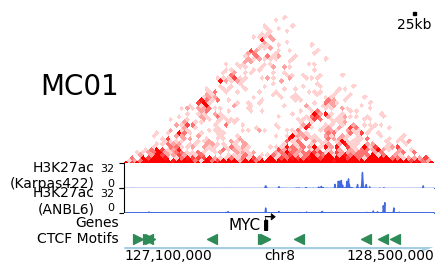

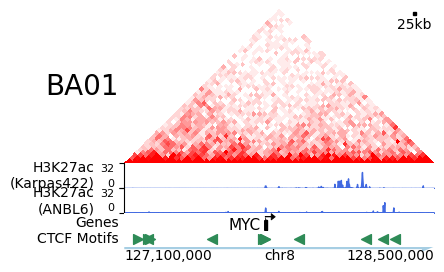

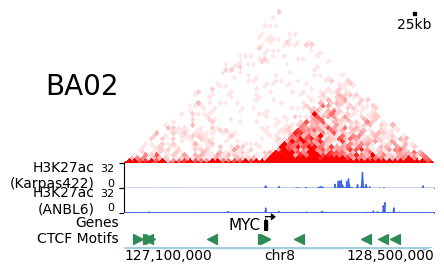

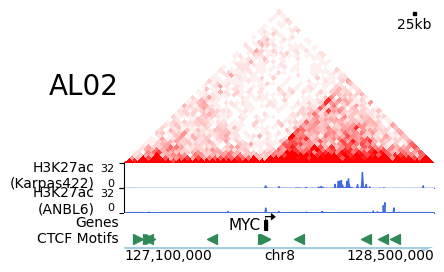

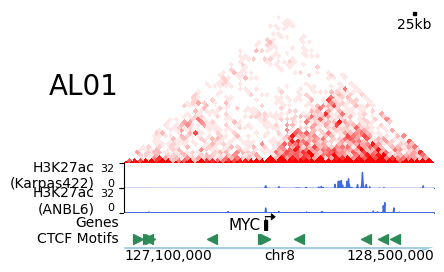

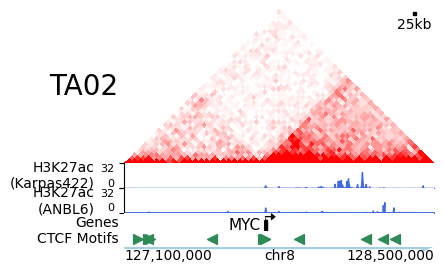

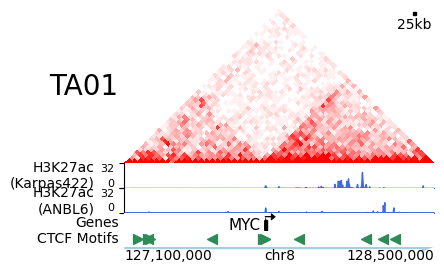

In [24]:
for sample in samples:
    fig = plot_myc_locus(sample.meta.id_paper, "MYC", lims=(127100000, 128500000))
    fig.savefig(figure_path(f"supp6_myc_triangle_{sample.meta.id_paper}.svg"), bbox_inches="tight")

# IKAROS Locus

In [10]:
resolution = 10000
measure = "observed"
norm = HIC_NORM
assembly_start = 49700000
assembly_end = 50900000

segment = bin_align_segment(Segment(
    "chr7",
    assembly_start,
    assembly_end,
), resolution)

all_other = []
all_plasmacytoma = []

for sample in samples:
    sample_id = sample.meta.id_file
    group = sample.meta.group
    if group == "PCN":
        list_to_add_to = all_plasmacytoma
    elif group == "DLBCL" or group == "CNS DLBCL":
        list_to_add_to = all_other
    else:
        continue

    hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
    data = get_hic_for_segment_pair(hic_file, pair_segments(segment, segment), norm="VC_SQRT", measure=measure)
    # Normalize by unique valid pairs
    data = data / (data.max() - data.min())
    uvp = get_uvp(sample_id)
    data = (data * uvp) / 10000000
    list_to_add_to.append((sample_id, data))

other_mean = np.mean([data for _, data in all_other], axis=0)
plasmacytoma_mean = np.mean([data for _, data in all_plasmacytoma], axis=0)

assembly = Assembly([
    segment
])

hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
assembled = assemble_hic(hic_file, assembly, gap_size=1, measure="observed", norm=norm)

In [12]:
ctcfA = 50092658
ctcfB = 50205513
ctcfEnd = 50418201
ctcfEnd2 = 50468195

In [13]:
insulations_other = []
insulations_plasmacytoma = []
window = 10*resolution
insulation_xaxis = None

for samples_group, list_group in zip([all_other, all_plasmacytoma], [insulations_other, insulations_plasmacytoma]):
    for sample_id, _ in samples_group:
        # cool_file = read_cooler(sample_id, resolution)
        # insulation_table = cooltools.insulation(cool_file, [window], verbose=False, nproc=1)
        insulation_table = pd.read_csv(f"../data/insulations/res_10000_window_100000/{sample_id}_insulation_r{resolution}_w{window}.csv")
        insulation_subset = insulation_table[(insulation_table.chrom == "chr7") & (insulation_table.start >= assembly_start) & (insulation_table.end <= assembly_end)]
        if insulation_xaxis is None:
            insulation_xaxis = insulation_subset["start"].values
        list_group.append((sample_id, insulation_subset[f"log2_insulation_score_{window}"], insulation_subset[f"is_boundary_{window}"]))

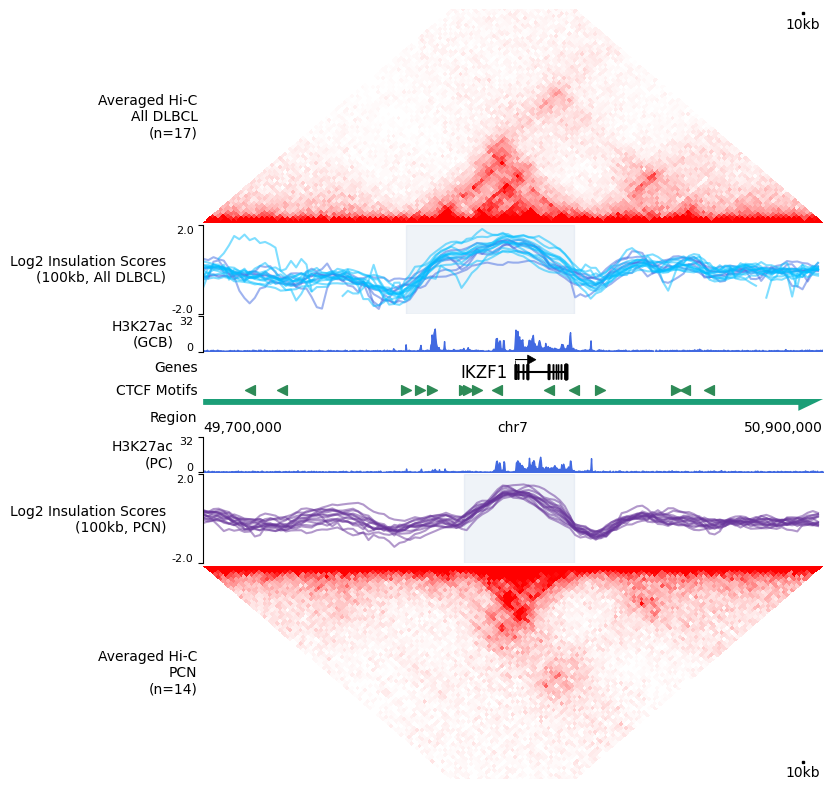

In [14]:
fig = plt.figure(figsize=(8, 10))

gs = fig.add_gridspec(9, 1, height_ratios=[12, 5,  2, 1.5, 0.8, 2,  2,  5, 12])
fig.subplots_adjust(hspace=0.025)

ax_top_triangle = fig.add_subplot(gs[0, 0])
ax_bottom_triangle = fig.add_subplot(gs[8, 0])

ax_top_insulations = fig.add_subplot(gs[1, 0])
ax_bottom_insulations = fig.add_subplot(gs[7, 0])

ax_h3k27ac_track_other = fig.add_subplot(gs[2, 0])
ax_gene_track = fig.add_subplot(gs[3, 0])
ax_ctcf_track = fig.add_subplot(gs[4, 0])
ax_chr_track = fig.add_subplot(gs[5, 0])
ax_h3k27ac_track_plasmacytoma = fig.add_subplot(gs[6, 0])

plot_track(ax_gene_track, assembled.plot_regions[0], TrackSpec(
    track_type = TrackType.TRACK_GENES,
    track_kwargs = {
        "fontsize": 12,
        "min_rows": 0,
        "max_rows": 1,
        "gene_filter": ["IKZF1"],
        "all_same_line": True,
        # "arrow_length": 0.1,
        # "arrowhead_length_proportion": 0.01,
        # "arrowhead_width": 0.01,
    },
    ylabel="Genes"
))


plot_track(ax_h3k27ac_track_other, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BIGWIG,
    track_kwargs={
        "bw_handle": pyBigWig.open("../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw"),
        "color": BIGWIG_COLOUR,
        "ymax": GLOBAL_BW_MAX,
        "show_ylim": True
    },
    ylabel="H3K27ac\n(GCB)"
))


plot_track(ax_h3k27ac_track_plasmacytoma, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BIGWIG,
    track_kwargs={
        "bw_handle": pyBigWig.open("../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw"),
        "color": BIGWIG_COLOUR,
        "ymax": GLOBAL_BW_MAX,
        "show_ylim": True,
    },
    ylabel="H3K27ac\n(PC)"
))

ax_h3k27ac_track_other.set_ylim((0, GLOBAL_BW_MAX))
ax_h3k27ac_track_plasmacytoma.set_ylim((0, GLOBAL_BW_MAX))

plot_track(ax_ctcf_track, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_BED_DIRECTIONAL,
    track_kwargs={
        "bed_file": "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed",
        "color": CTCF_COLOUR,
        "s": 50,
    },
    ylabel="CTCF Motifs"
))

plot_track(ax_chr_track, assembled.plot_regions[0], TrackSpec(
    track_type=TrackType.TRACK_CHR_ARROWS,
    track_kwargs={
        "label_chr": True
    },
    ylabel="Region"
))

pvt1_gene = ax_gene_track.findobj(matplotlib.text.Text)[1]
pvt1_gene.set_x(128290000)

vspan_col = "lightgrey"
vspan_alpha=0.2
ax_top_insulations.axvspan(ctcfA, ctcfEnd, color="lightsteelblue", alpha=vspan_alpha)
ax_bottom_insulations.axvspan(ctcfB, ctcfEnd, color="lightsteelblue", alpha=vspan_alpha)

for sample_id, insulation_data, _ in insulations_other:
    group = [ s.meta.group for s in samples if s.meta.id_file == sample_id][0]
    ax_top_insulations.plot(insulation_xaxis, (insulation_data), alpha=0.5, color=group_colors[group])
for sample_id, insulation_data, _ in insulations_plasmacytoma:
    group = [ s.meta.group for s in samples if s.meta.id_file == sample_id][0]
    ax_bottom_insulations.plot(insulation_xaxis, (insulation_data), alpha=0.5, color=group_colors[group])
ax_top_insulations.set_xlim(assembly_start, assembly_end)
ax_bottom_insulations.set_xlim(assembly_start, assembly_end)
# Set y lims the same
insulation_ymax = max(ax_top_insulations.get_ylim()[1], ax_bottom_insulations.get_ylim()[1])
insulation_ymin = min(ax_top_insulations.get_ylim()[0], ax_bottom_insulations.get_ylim()[0])
insulation_sym = max(abs(insulation_ymin), insulation_ymax)
insulation_ymax = insulation_sym
insulation_ymin = -insulation_sym
ax_top_insulations.set_ylim(insulation_ymin, insulation_ymax)
ax_bottom_insulations.set_ylim(insulation_ymin, insulation_ymax)
ax_top_insulations.set_yticks([])
ax_bottom_insulations.set_yticks([])
ax_top_insulations.set_ylabel(f"Log2 Insulation Scores\n({int_to_resolution(window)}, All DLBCL)", rotation=0, ha="right", va="center")
ax_bottom_insulations.set_ylabel(f"Log2 Insulation Scores\n({int_to_resolution(window)}, PCN)", rotation=0, ha="right", va="center")
ax_top_insulations.set_xticks([])
ax_bottom_insulations.set_xticks([])
ax_top_insulations.spines[['top', 'right', 'left', "bottom"]].set_visible(False)
ax_bottom_insulations.spines[['top', 'right', 'left', "bottom"]].set_visible(False)

hic_file = read_hic(f"../data/hic/{sample_id}_inter_30.hic")
assembled = assemble_hic(hic_file, assembly, gap_size=1, measure="observed", norm=norm)

assembled_other = AssembledHic(
    data=other_mean,
    plot_regions=assembled.plot_regions,
)

assembled_plasmacytoma = AssembledHic(
    data=plasmacytoma_mean,
    plot_regions=assembled.plot_regions,
)

vmax = max(np.nanmax(assembled_other.data), np.nanmax(assembled_plasmacytoma.data)) / 10
plot_assembled_triangle(assembled_other, ax=ax_top_triangle, aspect="auto", vmax=vmax, rasterized=True)
plot_assembled_triangle(assembled_plasmacytoma, ax=ax_bottom_triangle, aspect="auto", vmax=vmax, rasterized=True)

ax_top_triangle.set_ylabel(f"Averaged Hi-C\nAll DLBCL\n(n={len(insulations_other)})", rotation=0, ha="right", va="center")
ax_bottom_triangle.set_ylabel(f"Averaged Hi-C\nPCN\n(n={len(insulations_plasmacytoma)})", rotation=0, ha="right", va="center")

for ax in [ax_top_insulations, ax_bottom_insulations, ax_h3k27ac_track_other, ax_h3k27ac_track_plasmacytoma, ]:
    ymin, ymax = ax.get_ylim()
    ax.yaxis.set_visible(True)
    ax.spines[["left"]].set_visible(True)
    if ymax > 3:
        ax.set_yticks([ymin, ymax], [int(ymin), int(ymax)], fontsize=8)
    else:
        ax.set_yticks([ymin, ymax], [f"{ymin:.1f}", f"{ymax:.1f}"], fontsize=8)
    ax.get_yticklabels()[0].set_va("bottom")
    ax.get_yticklabels()[-1].set_va("top")
# Change y axis limits
ymax = (assembled.data.shape[1])*2/5
ax_top_triangle.set_ylim((0, ymax))
ax_bottom_triangle.set_ylim((0, ymax))
# Flip y axis on bottom triangle
ax_bottom_triangle.invert_yaxis()
# Change position of anchored size bar on bottom triangle
for child in ax_bottom_triangle.get_children()[::-1]:
    if isinstance(child, AnchoredSizeBar):
        child.set_bbox_to_anchor((1, 0.1), transform=ax_bottom_triangle.transAxes)
        break
fig.savefig(figure_path("supp6_insulation_comparison_IKAROS.svg"), bbox_inches="tight")


In [24]:
res = 10000
window = 10*res
insulation_xaxis = None
all_insulations = [] 
for sample in samples:
    insulation_table = pd.read_csv(f"../data/insulations/res_10000_window_100000/{sample.meta.id_file}_insulation_r{res}_w{window}.csv")
    insulation_subset = insulation_table[(insulation_table.chrom == "chr7") & (insulation_table.start >= assembly_start) & (insulation_table.end <= assembly_end)]
    if insulation_xaxis is None:
        insulation_xaxis = insulation_subset["start"].values
    all_insulations.append((sample.meta, insulation_subset))

In [25]:
dlbclA = []
dlbclB = []
pcnA = []
pcnB = []
for (sample, insulations) in all_insulations:
    if sample.group == "DLBCL" or sample.group == "CNS DLBCL":
        listA = dlbclA
        listB = dlbclB
    elif sample.group == "PCN":
        listA = pcnA
        listB = pcnB
    else:
        continue
    for i, row in insulations.iterrows():
        if row.start <= ctcfA <= row.end:
            listA.append(row["log2_insulation_score_100000"])
        elif row.start <= ctcfB <= row.end:
            listB.append(row["log2_insulation_score_100000"])

In [26]:
len(dlbclA), len(dlbclB), len(pcnA), len(pcnB)

(17, 17, 14, 14)

In [27]:
pvalA = scipy.stats.mannwhitneyu(dlbclA, pcnA)
print(pvalA)

MannwhitneyuResult(statistic=24.0, pvalue=0.00017605850609452354)


In [28]:
pvalB = scipy.stats.mannwhitneyu(dlbclB, pcnB)
print(pvalB)

MannwhitneyuResult(statistic=213.0, pvalue=0.00020610911542984692)


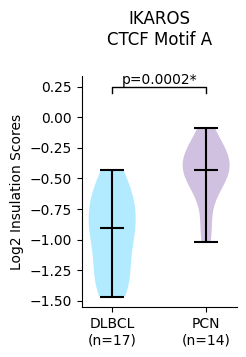

In [29]:
fig, ax = plt.subplots(figsize=(2, 3))
parts = ax.violinplot([dlbclA, pcnA], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(group_colors["DLBCL"])
parts['bodies'][1].set_facecolor(group_colors["PCN"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")

ypos = 0.2
ax.plot([0,0, 1, 1], [ypos, ypos+0.05, ypos+0.05, ypos], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
# ax.scatter([0]*len(dlbclA), dlbclA, marker=".")
# ax.scatter([1]*len(pcnA), pcnA, marker=".")
ax.text(0.5, ypos+0.05, f"p={pvalA.pvalue:.4f}*", ha="center", va="bottom")
ax.set_xticks([0, 1], [f"DLBCL\n(n={len(dlbclA)})", f"PCN\n(n={len(pcnA)})"])
# ax.set_title(f"chr8:\n{ctcfA//10000*10000:,}-\n{ctcfA//10000*10000+10000:,}", y=1.05, fontsize=10)
ax.set_title(f"IKAROS\nCTCF Motif A", y=1.1)
# ax.set_ylim(-0.8, 1.25)
fig.savefig(figure_path("supp6_boxplot_IKAROS_A.svg"), bbox_inches="tight")

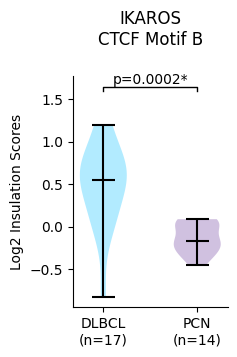

In [30]:
fig, ax = plt.subplots(figsize=(2, 3))

parts = ax.violinplot([dlbclB, pcnB], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(group_colors["DLBCL"])
parts['bodies'][1].set_facecolor(group_colors["PCN"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")

ypos = 1.6
ax.plot([0,0, 1, 1], [ypos, ypos+0.05, ypos+0.05, ypos], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
# ax.scatter([0]*len(dlbclB), dlbclB, marker=".")
# ax.scatter([1]*len(pcnB), pcnB, marker=".")
ax.text(0.5, ypos+0.05, f"p={pvalB.pvalue:.4f}*", ha="center", va="bottom")
# ax.set_title(f"chr8:\n{ctcfB//10000*10000:,}-\n{ctcfB//10000*10000+10000:,}", y=1.05, fontsize=10)
ax.set_title(f"IKAROS\nCTCF Motif B", y=1.1)
ax.set_xticks([0, 1], [f"DLBCL\n(n={len(dlbclA)})", f"PCN\n(n={len(pcnA)})"])
# ax.set_ylim(-0.8, 1.25)
fig.savefig(figure_path("supp6_boxplot_IKAROS_B.svg"), bbox_inches="tight")